In [1]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, TimeDistributed, SimpleRNN, GlobalMaxPooling1D
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4584\960080068.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


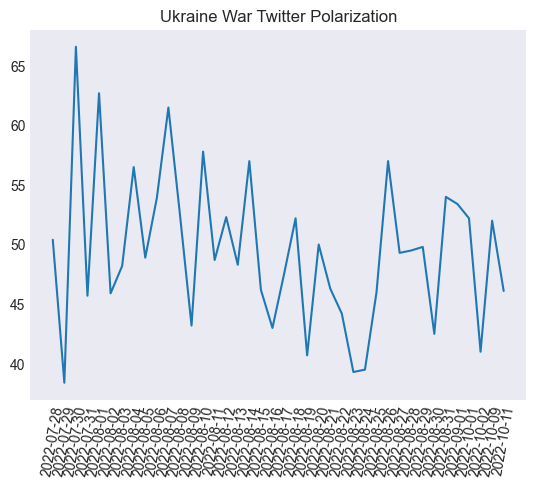

In [2]:
dates = ["2022-07-28", "2022-07-29", "2022-07-30", "2022-07-31", "2022-08-01", 
          "2022-08-02", "2022-08-03", "2022-08-04", "2022-08-05", "2022-08-06", 
         "2022-08-07", "2022-08-08", "2022-08-09", "2022-08-10", "2022-08-11", 
         "2022-08-12", "2022-08-13", "2022-08-14", "2022-08-15", "2022-08-16", 

         "2022-08-17", "2022-08-18", "2022-08-19", "2022-08-20", "2022-08-21",
         "2022-08-22","2022-08-23", "2022-08-24", "2022-08-25", "2022-08-26", "2022-08-27", 
         "2022-08-28", "2022-08-29","2022-08-30", "2022-08-31", "2022-09-01", "2022-10-01", "2022-10-02", "2022-10-09","2022-10-11"]

polarization = [50.4, 38.4, 66.6, 45.7, 62.7, 45.9,48.2,56.5,48.9,53.9,61.5,
                52.5,43.2,57.8,48.7,52.3,48.3,57.0,46.2,43.0,47.5,52.2,40.7,
                50.0,46.3,44.2, 39.3, 39.5, 46.0, 57.0, 49.3, 49.5, 49.8, 42.5, 54.0, 53.4, 52.2, 41.0, 52, 46.1]

plt.style.use('seaborn-dark')
plt.plot(dates, polarization)
plt.xticks(rotation=80)
plt.title("Ukraine War Twitter Polarization")

plt.show()

In [3]:
train_data = pd.read_csv("snli/train.csv")
test_data = pd.read_csv("snli/test.csv")
validation_data = pd.read_csv("snli/dev.csv")

train_data = train_data[:10000]
test_data = test_data[:10000]
validation_data = validation_data[:10000]

dataset = pd.concat([train_data, test_data, validation_data])

stop_words = stopwords.words('english')

# Display the first 5 lines of the dataset
print(dataset.head())

      gold_label                             sentence1_binary_parse  \
0        neutral  ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...   
1  contradiction  ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...   
2     entailment  ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...   
3        neutral  ( Children ( ( ( smiling and ) waving ) ( at c...   
4     entailment  ( Children ( ( ( smiling and ) waving ) ( at c...   

                              sentence2_binary_parse  \
0  ( ( A person ) ( ( is ( ( training ( his horse...   
1  ( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...   
2  ( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...   
3  ( They ( are ( smiling ( at ( their parents ) ...   
4             ( There ( ( are children ) present ) )   

                                     sentence1_parse  \
0  (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...   
1  (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...   
2  (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...   
3  (ROOT (NP

In [4]:
dataset = dataset[['gold_label', 'sentence1', 'sentence2']]
dataset.dropna(axis=0, inplace=True) #removing missing values

In [5]:
dataset = dataset.loc[dataset['gold_label'] != "-"]
dataset = dataset.loc[dataset['gold_label'] != "neutral"]
dataset = dataset.sample(frac = 1)

sentence1 = dataset['sentence1']
sentence2 = dataset['sentence2']
label = dataset['gold_label']


In [6]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

sentence1 = CleanFeatures(sentence1)
sentence2 = CleanFeatures(sentence2)

In [7]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape 
all_sentences = all_sentences.reshape(-1,1 )
all_sentences = all_sentences.reshape(all_sentences.shape[0])

In [8]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(all_sentences)
sentence1_seq = tokenizer.texts_to_sequences(sentence1)
sentence1 = pad_sequences(sentence1_seq)

sentence2_seq = tokenizer.texts_to_sequences(sentence2)
sentence2 = pad_sequences(sentence2_seq, maxlen= sentence1.shape[1])


In [9]:
label_ = LabelEncoder()
labels = label_.fit_transform(label)
vocabulary = len(tokenizer.word_index)
labels = to_categorical(labels)

In [10]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 19877, 34)

In [11]:
all_sentences = all_sentences.reshape(all_sentences.shape[1], 2, all_sentences.shape[2])
all_sentences.shape

(19877, 2, 34)

In [12]:
def glove_word_embedding(file_name, vocabulary):
    embeddings_index = {}
    with open(file_name, encoding="utf-8") as file_:  
        for line in file_:
            arr = line.split()
            single_word = arr[0]
            w = np.asarray(arr[1:], dtype='float32')
            embeddings_index[single_word] = w
    
    max_words = vocabulary + 1
    word_index = tokenizer.word_index  # Assuming tokenizer is defined elsewhere
    embedding_matrix = np.zeros((max_words, 50)).astype(object)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    
    return embedding_matrix


In [14]:
model_rnn = tf.keras.models.Sequential()
model_rnn.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2],)))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add((tf.keras.layers.TimeDistributed(GlobalMaxPooling1D())))
model_rnn.add(tf.keras.layers.Flatten())
model_rnn.add(tf.keras.layers.Dense(2, activation='softmax'))
model_rnn.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_rnn.layers[0].trainable = False
model_rnn.summary()

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Embedding
import tensorflow as tf

model_cnn = tf.keras.models.Sequential()
model_cnn.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2])))
# Reshape output of Embedding layer to match Conv1D input shape
model_cnn.add(tf.keras.layers.Reshape((all_sentences.shape[2], all_sentences.shape[1]*50)))
model_cnn.add(Conv1D(128, 5, activation='relu'))
# Calculate the output shape after the convolution
output_shape_after_conv = model_cnn.layers[-1].compute_output_shape(input_shape=(None, all_sentences.shape[2], all_sentences.shape[1]*50))
# Determine the pooling size compatible with the output shape
pool_size = min(4, output_shape_after_conv[1])
try:
    model_cnn.add(MaxPooling1D(pool_size=pool_size))
except ValueError:
    pass  # Skip max pooling if pool_size is not compatible with the output shape
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv1D(128, 5, activation='relu'))
# Calculate the output shape after the convolution
output_shape_after_conv = model_cnn.layers[-1].compute_output_shape(input_shape=output_shape_after_conv)
# Determine the pooling size compatible with the output shape
pool_size = min(4, output_shape_after_conv[1])
try:
    model_cnn.add(MaxPooling1D(pool_size=pool_size))
except ValueError:
    pass  # Skip max pooling if pool_size is not compatible with the output shape
model_cnn.add(Dropout(0.1))
model_cnn.add(Flatten())
model_cnn.add(Dense(2, activation='softmax'))
model_cnn.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_cnn.layers[0].trainable = False
model_cnn.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 34, 50)         447050    
                                                                 
 time_distributed (TimeDist  (None, 2, 34, 128)        22912     
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 2, 34, 128)        0         
                                                                 
 time_distributed_1 (TimeDi  (None, 2, 34, 128)        32896     
 stributed)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 2, 34, 128)        0         
                                                                 
 time_distributed_2 (TimeDi  (None, 2, 128)            0

In [15]:
from tensorflow.keras.layers import LSTM

model_lstm = tf.keras.models.Sequential()
model_lstm.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2])))
# Remove the extra dimension by reshaping the input
model_lstm.add(tf.keras.layers.Reshape((all_sentences.shape[1], all_sentences.shape[2]*50)))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(Flatten())
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_lstm.layers[0].trainable = False
model_lstm.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2, 34, 50)         447050    
                                                                 
 reshape_1 (Reshape)         (None, 2, 1700)           0         
                                                                 
 lstm (LSTM)                 (None, 2, 128)            936448    
                                                                 
 dropout_4 (Dropout)         (None, 2, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 128)            131584    
                                                                 
 dropout_5 (Dropout)         (None, 2, 128)            0         
                                                                 
 flatten_2 (Flatten)         (None, 256)              

In [16]:
from tensorflow.keras.layers import GRU

model_gru = tf.keras.models.Sequential()
model_gru.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2])))
# Remove the extra dimension by reshaping the input
model_gru.add(tf.keras.layers.Reshape((all_sentences.shape[1], all_sentences.shape[2]*50)))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dropout(0.1))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dropout(0.1))
model_gru.add(Flatten())
model_gru.add(Dense(2, activation='softmax'))
model_gru.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_gru.layers[0].trainable = False
model_gru.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2, 34, 50)         447050    
                                                                 
 reshape_2 (Reshape)         (None, 2, 1700)           0         
                                                                 
 gru (GRU)                   (None, 2, 128)            702720    
                                                                 
 dropout_6 (Dropout)         (None, 2, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 2, 128)            99072     
                                                                 
 dropout_7 (Dropout)         (None, 2, 128)            0         
                                                                 
 flatten_3 (Flatten)         (None, 256)              

In [18]:
from tensorflow.keras.layers import Bidirectional, GRU

model_bi_gru = tf.keras.models.Sequential()
model_bi_gru.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2])))
# Remove the extra dimension by reshaping the input
model_bi_gru.add(tf.keras.layers.Reshape((all_sentences.shape[1], all_sentences.shape[2]*50)))
model_bi_gru.add(Bidirectional(GRU(128, return_sequences=True)))
model_bi_gru.add(Dropout(0.1))
model_bi_gru.add(Bidirectional(GRU(128, return_sequences=True)))
model_bi_gru.add(Dropout(0.1))
model_bi_gru.add(Flatten())
model_bi_gru.add(Dense(2, activation='softmax'))  # Removed extra parenthesis
model_bi_gru.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_bi_gru.layers[0].trainable = False
model_bi_gru.summary()

model_bi_lstm = tf.keras.models.Sequential()
model_bi_lstm.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2])))
# Remove the extra dimension by reshaping the input
model_bi_lstm.add(tf.keras.layers.Reshape((all_sentences.shape[1], all_sentences.shape[2]*50)))
model_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_bi_lstm.add(Dropout(0.1))
model_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_bi_lstm.add(Dropout(0.1))
model_bi_lstm.add(Flatten())
model_bi_lstm.add(Dense(2, activation='softmax'))  # Removed extra parenthesis
model_bi_lstm.layers[0].set_weights([glove_word_embedding("snli/glove.6B.50d.txt", vocabulary)])
model_bi_lstm.layers[0].trainable = False
model_bi_lstm.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2, 34, 50)         447050    
                                                                 
 reshape_3 (Reshape)         (None, 2, 1700)           0         
                                                                 
 bidirectional (Bidirection  (None, 2, 256)            1405440   
 al)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 2, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 2, 256)            296448    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 2, 256)           

In [19]:
model_rnn.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model_cnn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_lstm.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_gru.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bi_gru.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bi_lstm.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])



In [20]:
training_bi_gru = model_bi_gru.fit(all_sentences, labels,
                                   epochs=100,
                                   batch_size=1024,
                                   use_multiprocessing=True,
                                   workers=-1)


Epoch 1/100
20/20 [==============================] - 17s 332ms/step - loss: 0.6969 - accuracy: 0.4998
Epoch 2/100
20/20 [==============================] - 7s 339ms/step - loss: 0.6879 - accuracy: 0.5407
Epoch 3/100
20/20 [==============================] - 7s 329ms/step - loss: 0.6809 - accuracy: 0.5555
Epoch 4/100
20/20 [==============================] - 7s 337ms/step - loss: 0.6713 - accuracy: 0.5736
Epoch 5/100
20/20 [==============================] - 7s 336ms/step - loss: 0.6563 - accuracy: 0.5963
Epoch 6/100
20/20 [==============================] - 7s 338ms/step - loss: 0.6392 - accuracy: 0.6142
Epoch 7/100
20/20 [==============================] - 7s 339ms/step - loss: 0.6161 - accuracy: 0.6412
Epoch 8/100
20/20 [==============================] - 7s 333ms/step - loss: 0.5919 - accuracy: 0.6606
Epoch 9/100
20/20 [==============================] - 7s 353ms/step - loss: 0.5612 - accuracy: 0.6861
Epoch 10/100
20/20 [==============================] - 7s 340ms/step - loss: 0.5121 - accur

In [21]:
training_bi_lstm = model_bi_lstm.fit(all_sentences, labels,
                                     epochs=100,
                                     batch_size=1024,
                                     use_multiprocessing=True,
                                     workers=-1)


Epoch 1/100
20/20 [==============================] - 17s 389ms/step - loss: 0.6941 - accuracy: 0.5003
Epoch 2/100
20/20 [==============================] - 8s 403ms/step - loss: 0.6901 - accuracy: 0.5368
Epoch 3/100
20/20 [==============================] - 8s 391ms/step - loss: 0.6829 - accuracy: 0.5472
Epoch 4/100
20/20 [==============================] - 8s 391ms/step - loss: 0.6690 - accuracy: 0.5809
Epoch 5/100
20/20 [==============================] - 8s 387ms/step - loss: 0.6488 - accuracy: 0.6067
Epoch 6/100
20/20 [==============================] - 8s 393ms/step - loss: 0.6163 - accuracy: 0.6399
Epoch 7/100
20/20 [==============================] - 8s 393ms/step - loss: 0.5855 - accuracy: 0.6711
Epoch 8/100
20/20 [==============================] - 8s 392ms/step - loss: 0.5297 - accuracy: 0.7160
Epoch 9/100
20/20 [==============================] - 8s 384ms/step - loss: 0.4774 - accuracy: 0.7494
Epoch 10/100
20/20 [==============================] - 8s 394ms/step - loss: 0.4217 - accur

In [22]:
training_gru = model_gru.fit(all_sentences, labels,
                             epochs=100,
                             batch_size=1024,
                             use_multiprocessing=True,
                             workers=-1)


Epoch 1/100
20/20 [==============================] - 9s 141ms/step - loss: 0.6949 - accuracy: 0.4963
Epoch 2/100
20/20 [==============================] - 3s 147ms/step - loss: 0.6892 - accuracy: 0.5374
Epoch 3/100
20/20 [==============================] - 3s 148ms/step - loss: 0.6830 - accuracy: 0.5546
Epoch 4/100
20/20 [==============================] - 3s 150ms/step - loss: 0.6755 - accuracy: 0.5627
Epoch 5/100
20/20 [==============================] - 3s 142ms/step - loss: 0.6633 - accuracy: 0.5831
Epoch 6/100
20/20 [==============================] - 3s 139ms/step - loss: 0.6479 - accuracy: 0.6056
Epoch 7/100
20/20 [==============================] - 3s 159ms/step - loss: 0.6294 - accuracy: 0.6267
Epoch 8/100
20/20 [==============================] - 3s 151ms/step - loss: 0.6073 - accuracy: 0.6493
Epoch 9/100
20/20 [==============================] - 3s 150ms/step - loss: 0.5803 - accuracy: 0.6752
Epoch 10/100
20/20 [==============================] - 3s 152ms/step - loss: 0.5490 - accura

In [23]:
training_cnn = model_cnn.fit(all_sentences, labels,
                             epochs=100,
                             batch_size=1024,
                             use_multiprocessing=True,
                             workers=-1)


Epoch 1/100
20/20 [==============================] - 5s 193ms/step - loss: 0.6986 - accuracy: 0.4994
Epoch 2/100
20/20 [==============================] - 4s 175ms/step - loss: 0.6887 - accuracy: 0.5445
Epoch 3/100
20/20 [==============================] - 4s 177ms/step - loss: 0.6824 - accuracy: 0.5666
Epoch 4/100
20/20 [==============================] - 3s 171ms/step - loss: 0.6726 - accuracy: 0.5864
Epoch 5/100
20/20 [==============================] - 3s 170ms/step - loss: 0.6591 - accuracy: 0.6042
Epoch 6/100
20/20 [==============================] - 4s 181ms/step - loss: 0.6387 - accuracy: 0.6345
Epoch 7/100
20/20 [==============================] - 4s 182ms/step - loss: 0.6162 - accuracy: 0.6526
Epoch 8/100
20/20 [==============================] - 4s 180ms/step - loss: 0.5855 - accuracy: 0.6887
Epoch 9/100
20/20 [==============================] - 3s 171ms/step - loss: 0.5633 - accuracy: 0.7017
Epoch 10/100
20/20 [==============================] - 4s 183ms/step - loss: 0.5424 - accura

In [24]:
training_lstm = model_lstm.fit(all_sentences, labels,
                               epochs=100,
                               batch_size=1024,
                               use_multiprocessing=True,
                               workers=-1)


Epoch 1/100
20/20 [==============================] - 8s 159ms/step - loss: 0.6934 - accuracy: 0.5018
Epoch 2/100
20/20 [==============================] - 4s 176ms/step - loss: 0.6910 - accuracy: 0.5318
Epoch 3/100
20/20 [==============================] - 4s 176ms/step - loss: 0.6858 - accuracy: 0.5471
Epoch 4/100
20/20 [==============================] - 3s 168ms/step - loss: 0.6756 - accuracy: 0.5607
Epoch 5/100
20/20 [==============================] - 3s 159ms/step - loss: 0.6611 - accuracy: 0.5907
Epoch 6/100
20/20 [==============================] - 3s 166ms/step - loss: 0.6427 - accuracy: 0.6135
Epoch 7/100
20/20 [==============================] - 3s 174ms/step - loss: 0.6161 - accuracy: 0.6390
Epoch 8/100
20/20 [==============================] - 4s 175ms/step - loss: 0.5859 - accuracy: 0.6667
Epoch 9/100
20/20 [==============================] - 3s 174ms/step - loss: 0.5512 - accuracy: 0.6974
Epoch 10/100
20/20 [==============================] - 3s 159ms/step - loss: 0.5124 - accura

In [25]:
training = model_rnn.fit(all_sentences,labels,
                         epochs= 100,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                    )

Epoch 1/100
20/20 [==============================] - 20s 870ms/step - loss: 0.7112 - accuracy: 0.4972
Epoch 2/100
20/20 [==============================] - 18s 879ms/step - loss: 0.6969 - accuracy: 0.5120
Epoch 3/100
20/20 [==============================] - 18s 888ms/step - loss: 0.6927 - accuracy: 0.5195
Epoch 4/100
20/20 [==============================] - 18s 901ms/step - loss: 0.6919 - accuracy: 0.5253
Epoch 5/100
20/20 [==============================] - 18s 908ms/step - loss: 0.6913 - accuracy: 0.5286
Epoch 6/100
20/20 [==============================] - 18s 890ms/step - loss: 0.6903 - accuracy: 0.5346
Epoch 7/100
20/20 [==============================] - 18s 898ms/step - loss: 0.6886 - accuracy: 0.5388
Epoch 8/100
20/20 [==============================] - 18s 899ms/step - loss: 0.6854 - accuracy: 0.5580
Epoch 9/100
20/20 [==============================] - 18s 911ms/step - loss: 0.6847 - accuracy: 0.5571
Epoch 10/100
20/20 [==============================] - 18s 903ms/step - loss: 0.681

In [26]:
model_rnn.evaluate(all_sentences,labels, batch_size = 1024,use_multiprocessing=True, workers = -1)
evaluation_cnn = model_cnn.evaluate(all_sentences, labels,
                                     batch_size=1024,
                                     use_multiprocessing=True,
                                     workers=-1)
evaluation_lstm = model_lstm.evaluate(all_sentences, labels,
                                       batch_size=1024,
                                       use_multiprocessing=True,
                                       workers=-1)
evaluation_gru = model_gru.evaluate(all_sentences, labels,
                                     batch_size=1024,
                                     use_multiprocessing=True,
                                     workers=-1)
evaluation_bi_gru = model_bi_gru.evaluate(all_sentences, labels,
                                           batch_size=1024,
                                           use_multiprocessing=True,
                                           workers=-1)
evaluation_bi_lstm = model_bi_lstm.evaluate(all_sentences, labels,
                                             batch_size=1024,
                                             use_multiprocessing=True,
                                             workers=-1)


20/20 [==============================] - 5s 143ms/step - loss: 0.0022 - accuracy: 0.9995


In [27]:
y_pred_cnn = model_cnn.predict(all_sentences, batch_size=1024, verbose=1)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

y_pred_lstm = model_lstm.predict(all_sentences, batch_size=1024, verbose=1)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

y_pred_gru = model_gru.predict(all_sentences, batch_size=1024, verbose=1)
y_pred_gru = np.argmax(y_pred_gru, axis=1)

y_pred_bi_gru = model_bi_gru.predict(all_sentences, batch_size=1024, verbose=1)
y_pred_bi_gru = np.argmax(y_pred_bi_gru, axis=1)

y_pred_bi_lstm = model_bi_lstm.predict(all_sentences, batch_size=1024, verbose=1)
y_pred_bi_lstm = np.argmax(y_pred_bi_lstm, axis=1)

y_pred = model_rnn.predict(all_sentences, batch_size=1024, verbose= 1)
y_pred = np.argmax(y_pred, axis = 1)

20/20 [==============================] - 6s 299ms/step


In [28]:
from sklearn.metrics import accuracy_score

# Define the list of models and their corresponding predictions
models = ["RNN", "CNN", "LSTM", "GRU", "Bidirectional GRU", "Bidirectional LSTM"]
predictions = [y_pred, y_pred_cnn, y_pred_lstm, y_pred_gru, y_pred_bi_gru, y_pred_bi_lstm]

# Define the list of true labels
y_tests = [np.argmax(labels, axis=1)] * len(models)

# Calculate accuracy for each model
accuracies = [accuracy_score(y_test, pred) for y_test, pred in zip(y_tests, predictions)]

# Print model name and accuracy value
for model, accuracy in zip(models, accuracies):
    print(f"Model: {model}, Accuracy: {accuracy}")


Model: RNN, Accuracy: 0.9022488303063843
Model: CNN, Accuracy: 0.9766061276852643
Model: LSTM, Accuracy: 0.9994969059717261
Model: GRU, Accuracy: 0.999345977763244
Model: Bidirectional GRU, Accuracy: 0.9993962871660713
Model: Bidirectional LSTM, Accuracy: 0.9995472153745535


In [30]:
# For model_rnn
model_rnn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# For other models (CNN, LSTM, GRU, Bidirectional GRU, Bidirectional LSTM), compile similarly
model_cnn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_lstm.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_gru.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bi_gru.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bi_lstm.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


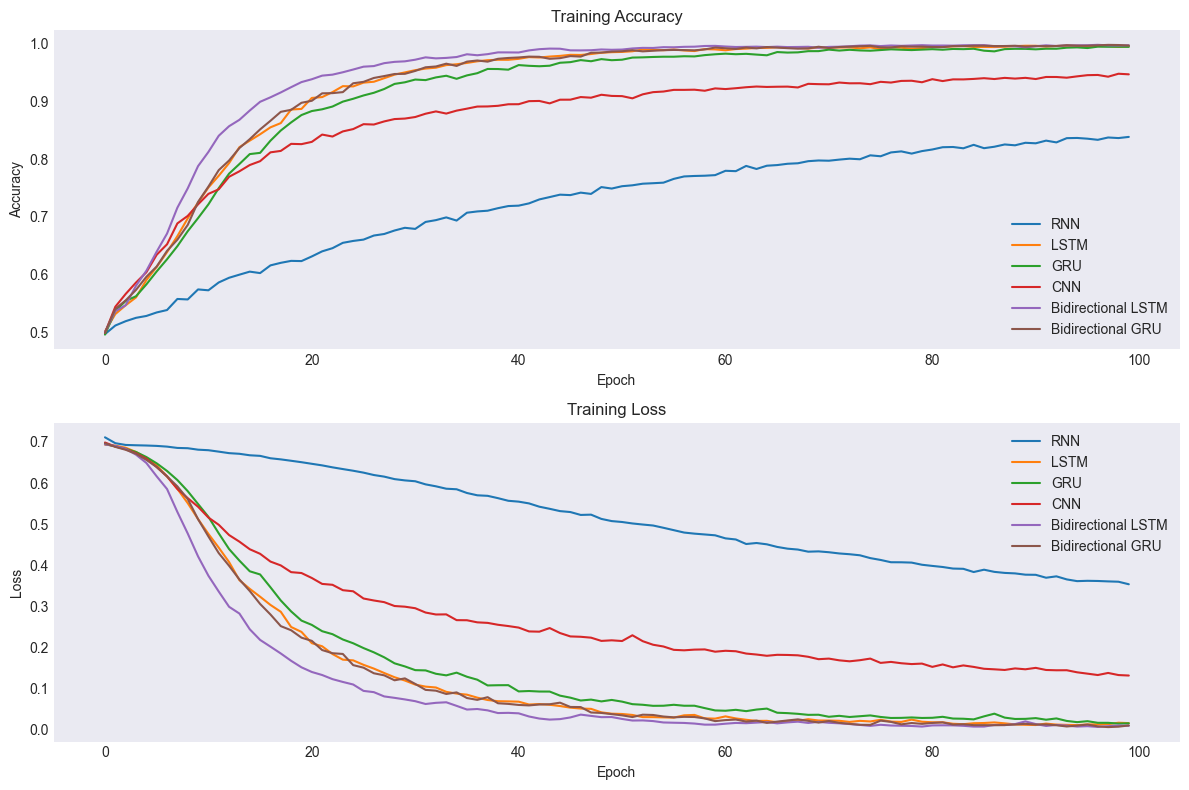

In [38]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.figure(figsize=(12, 8))

# Training Accuracy
plt.subplot(2, 1, 1)
plt.plot(training.history['accuracy'], label='RNN')
plt.plot(training_lstm.history['accuracy'], label='LSTM')
plt.plot(training_gru.history['accuracy'], label='GRU')
plt.plot(training_cnn.history['accuracy'], label='CNN')
plt.plot(training_bi_lstm.history['accuracy'], label='Bidirectional LSTM')
plt.plot(training_bi_gru.history['accuracy'], label='Bidirectional GRU')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(2, 1, 2)
plt.plot(training.history['loss'], label='RNN')
plt.plot(training_lstm.history['loss'], label='LSTM')
plt.plot(training_gru.history['loss'], label='GRU')
plt.plot(training_cnn.history['loss'], label='CNN')
plt.plot(training_bi_lstm.history['loss'], label='Bidirectional LSTM')
plt.plot(training_bi_gru.history['loss'], label='Bidirectional GRU')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
from sklearn.metrics import classification_report

# Define the list of models, their corresponding predictions, and true labels
models = ["RNN", "CNN", "LSTM", "GRU", "Bidirectional GRU", "Bidirectional LSTM"]
predictions = [y_pred, y_pred_cnn, y_pred_lstm, y_pred_gru, y_pred_bi_gru, y_pred_bi_lstm]
true_labels = [np.argmax(labels, axis=1)] * len(models)

# Generate and print classification reports for each model
for model_name, prediction, true_label in zip(models, predictions, true_labels):
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_label, prediction))
    print()


Classification Report for RNN:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      9844
           1       0.92      0.89      0.90     10033

    accuracy                           0.90     19877
   macro avg       0.90      0.90      0.90     19877
weighted avg       0.90      0.90      0.90     19877


Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9844
           1       0.98      0.98      0.98     10033

    accuracy                           0.98     19877
   macro avg       0.98      0.98      0.98     19877
weighted avg       0.98      0.98      0.98     19877


Classification Report for LSTM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9844
           1       1.00      1.00      1.00     10033

    accuracy                           1.00     19877
   macro avg       1.00      1.0

In [42]:
ukr_tweets = pd.read_csv('filename.csv')
ukr_tweets.columns
tweets = ukr_tweets["tweet"]

In [43]:
def preprocess(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],all_sentences.shape[2])
  return pred_input

In [48]:
def logical_link(model, sen1, sen2):
    randsent1 = preprocess(sen1)
    randsent2 = preprocess(sen2)
    full_input = np.asarray([randsent1, randsent2])
    full_input = full_input.reshape(1, 2, all_sentences.shape[2])
    y_predict = model.predict(full_input)
    y_pred = np.argmax(y_predict)
    class_name = ['contradiction', 'entailment']
    return class_name[y_pred]

def percentage_count(model, n):
    entailment_count = 0
    contradiction_count = 0

    for pred in range(n):
        if logical_link(model, tweets.sample(), tweets.sample()) == 'entailment':
            entailment_count += 1
        else:
            contradiction_count += 1
    
    percentage = 100 * float(contradiction_count) / float(n)

    return 'The percentage of contradictory statements is ' + str(percentage) + '%'

# Adjust this part based on your actual models
models = [model_rnn, model_cnn, model_lstm, model_gru, model_bi_gru, model_bi_lstm]

# Define the number of iterations
n = 1000  # Adjust the number as needed

# Loop over all models and calculate the percentage of contradictory statements
polarization = []
for model in models:
    result = percentage_count(model, n)
    polarization.append(result)
    print(result)


marjorie taylor greene tells tucker carlson 'this war russia ukraine' https://t.co/qy3efiqn0z
@sdallnct @mmayhem2020 @edkrassen 34 people convicted colluding russia???
1/1 [==============================] - 0s 441ms/step
@karilake @cpac poor reagan! russia beaten death. russia didn’t beat america. 👍🏼❤️🇺🇸🙂 https://t.co/qsed7ac4ir
@trollstoy88 literally made up. there’s russophobia here. one scared russia. put place. right next dump excrement.
1/1 [==============================] - 0s 30ms/step
someone repeatedly links russia whether it’s oligarchs &amp; freebies/discounts two different countries joking fsb linked pranksters promoting russian propaganda - telling us align russia. harry &amp; meghan putin puppets!
@azgeopolitics regardless china does, us wants bundle china russia.
1/1 [==============================] - 0s 32ms/step
@reuters still angry african nations keep choosing russia france.
@patbr0dy it’s actually youtube, he’s talking russia’s ideology, hope helps :) https://t.co/v

1/1 [==============================] - 0s 35ms/step
@mazzenilsson anti war pro putin pro russian imperialism? russia aggressor invaded ukraine. agenda obviously here. want war end, tell russia get ukraine!
ukraine russia mon, 27 feb 2023 18:00:00 cst
1/1 [==============================] - 0s 40ms/step
@johnjthesane @kanekoathegreat wonder feelings would russia re-armed cuba nuclear missiles.
การคืนไครเมียให้ยูเครนเป็นไปไม่ได้ คาบสมุทรแห่งนี้เป็นส่วนสำคัญของรัสเซีย เครมลิน #ยูเครน #ukrainerussiawar #ukraine #รัสเซียยูเครน #รัสเซีย #russia
1/1 [==============================] - 0s 33ms/step
@adamkinzinger @tuckercarlson hey adam, care russia? compassion stolen children biden helping cross borders, amount people crossing border everyday biden. dislike every time read one liberal posts.
@endwokeness americas biggest threat isn’t russia/china whatever…it’s self imploding descending complete chaos
1/1 [==============================] - 0s 57ms/step
@katya1943 @veravanhorne that’s years russi

1/1 [==============================] - 0s 41ms/step
@earlhuffmanjr1 @remarks yeah man! nazis stuff! good thing russia invaded ukraine stop nazis right? congress better make insulin affordable soon, earl lightheaded meds
@wallstreetsilv smells like #uspoli #regimechina/colour revolution. s. africa rolling blackouts long time, yrs. 'verge collapse' now? anything joint military drills month russia &amp; china? #cdnpoli #com
1/1 [==============================] - 0s 40ms/step
@boz561 @mmayhem2020 @edkrassen fbi wouldn’t take it. tried turn in. nobody would touch election. misinformation spread russia. remember einstein?
obsessão ocidente em despedaçar rússia levou uma operação militar https://t.co/f5c287niel
1/1 [==============================] - 0s 41ms/step
china russia ready smoke 🍻
invasion ukraine russia displaced millions, creating biggest refugee crisis since world war ii. @skolimowski @patrickjdo talked trying settle abroad https://t.co/lxrowlxv8j
1/1 [=============================

1/1 [==============================] - 0s 25ms/step
@dhouseatxhouse @charterunmai escalate sure ukraine likely attack crimea using us provided weapons summer… chinese begin supplying russia weapons…ukraine soldiers left… ukrainian nazis r real… grandfather one ww2 https://t.co/ujcpzhozuj
@curpdavid does, russia come hungary.
1/1 [==============================] - 0s 26ms/step
@akos_gerei @pm_viktororban szijjarto says article posted hungary new gas deal september 2021. always working make hungary reliant russia.
@visegrad24 likely another moscow's theatre prove population russia surrounded enemies.
1/1 [==============================] - 0s 26ms/step
@chrisblec much money ukraine must give back us? 🧐 yellen go there, sign papers, ukraine lands, part usa now, fk know state pay debt future? usa give shit ukraine russia, money!!
@telesurenglish u.s. punishing china drawing 12 point peace treaty ukraine &amp; russia. dare china interfere u.s.’ $120 billion proxy war.
1/1 [==================

1/1 [==============================] - 0s 25ms/step
@crypto_picture @dougeyolfson us remove missiles easter europe, did. russia left cuba went bankrupt
"we need world know we’re still here." hundreds marked one year since russia invaded ukraine vigil. https://t.co/2c6eonnqbr https://t.co/z1vwktmqlx
1/1 [==============================] - 0s 27ms/step
@enkognedo @gunthereagleman agree america’s destroyed within, want blame russia countries warmongers
@edemotivated @alessiourban can't even simple math... 30% chinese export vanishes want russia take slack? hahahahaha https://t.co/bvlmiifb6l
1/1 [==============================] - 0s 28ms/step
@apmassaro3 can’t beleive see complaining countries waged wars russia false pretences. least russia try protect people. us afghanistan, libya, syria iraq. mention vietnam.
@awakenedoutlaw @boychukkaren yeah, karen! (russia's usage cross) https://t.co/le3qndcisk
1/1 [==============================] - 0s 28ms/step
@domaiforeman @bitcoincarni @earlobekelo

1/1 [==============================] - 0s 29ms/step
@dvatw scared know russia going win ukraine they're frightened death world see then, us &amp; nato toothless - guarantee nato tries go ukraine china immediately align russia battlefield
central bankers' war take russia's wealth https://t.co/sdiijx1net
1/1 [==============================] - 0s 51ms/step
sparks fly fox news charles payne loses gerlado rivera: 'you think russia gonna drop bomb president biden?!' via @westjournalism https://t.co/bo8ny97qzj
china crosses "red line" advancing russia's war effort https://t.co/s99e4fcntp
1/1 [==============================] - 0s 25ms/step
@ronfilipkowski yes, compete china make enemy 2nd greatest power (w citizens) earth? good old, agent orange, changing subject russia, who's attacking usa vigorously 20 yrs, china.
@lisahar43261796 @veepeggy @simonateba russia dictatorship increasingly totalitarian far dangerous putin soviet union run politburo.
1/1 [==============================] - 0s 31ms/

1/1 [==============================] - 0s 37ms/step
@ronfilipkowski better start companies. add stop business russia, oh wait, that's buddy killing innocent people, guess gets pardon.
sanctions stopped russia's war effort, biden claims new ones sure https://t.co/jtsbf8lavv
1/1 [==============================] - 0s 39ms/step
@rickyja56396441 @azgeopolitics us cannot say anything china giving russia anything… us arms dealer world &amp; weapons killing yemeni people decade. also ask people afghanistan, iraq syria, china give help russia.
@maria_drutska everyone else: "just stop attacking countries committing crimes humanity!" russia: "........" https://t.co/42z2mma1qr
1/1 [==============================] - 0s 46ms/step
mysterious deaths russia: vyacheslav rovneiko, director russian inter-regional fuel union, found dead home 22 february. 8th oil gas executive eleventh russian top manager die mysterious circumstances since early 2022. https://t.co/zp3fbkp4dj
@ronfilipkowski yes, compete chi

1/1 [==============================] - 0s 30ms/step
apple pays $12.1 million fine alleged app market abuse russia – antimonopoly service https://t.co/9g2ujzhnoz
😢such loss. both, ukraine russia.
1/1 [==============================] - 0s 26ms/step
@vonclownsewitz people realize yeltsin russia thatcher/trump detractors? (couldn't think suitably controversial western leftist political figures)
guerra russia ucraina: tra martiri del donbass https://t.co/grx89kiukq
1/1 [==============================] - 0s 34ms/step
russia's war ukraine responsible 'massive' human rights violations, u.n. chief says https://t.co/tytba2zd7h
russia obsessed capturing one town #russia #ukraine #bakhmut #donetsk https://t.co/eqrrpr5mo7
1/1 [==============================] - 0s 31ms/step
@zaleskiluke @rsbnetwork trump right russia hoax, right biden corruption, right economy biden global chaos biden elected, niw find right origins covid he's wrong 2020? he's right too. it'll reveal soon enough
@twitdisturbr @accab

1/1 [==============================] - 0s 29ms/step
@dashdobrofsky ironic. want save “democracy” (an error ignorance i’m sure) ignoring 1st amendment. i’d wager msm spreads lies day fox year. think hunter’s laptop; russia collusion; squashing covid dissent.
russia claims bakhmut roads cut; scholz macron mull ultimatum; moscow warns war transnistria attack https://t.co/tzh8uz8iyr #odysee via @odyseeteam
1/1 [==============================] - 0s 29ms/step
@clies13 @treaschest @sprtukr wisdom @amanpour guiding mantra "truthful, neutral". both-siderism/ both-siding incomprehensible", "what create false equivalence, either factually morally." russia terrorist state. genocidal war. 1/2
@globonews @natuzanery @cesartralli boa noite! sobre cogitação atual aumento combustível. ano passado quando aumentaram os combustíveis, alegaram que principal fator era guerra entre rússia e ucrânia, onde disseram que barril de petróleo disparou? isso foi fato real ou fakenews?
1/1 [==========================

1/1 [==============================] - 0s 26ms/step
clearly sociopathic elites decided ukraine important china sudden china enemy helping russia.
@tim_the_sandman @jonathantcasey russia invaded donbas 2014.
1/1 [==============================] - 0s 27ms/step
know. thats wy love russia bekijk de video van karmachronicles! #tiktok https://t.co/jj0ammbz6d
moscow police receive religious-inscribed armor panels – russia news / new voice ukraine https://t.co/juekx1b9hc
1/1 [==============================] - 0s 28ms/step
cia agent facebooking russia. cia agent actually illegal israeli settlements. (with covid-19).
@kamvtv trying make reason go war. politicians makes tons money war stock own. boeing, defense contractors etc. shame send 18 year olds war profit. russia deal set long time ago. another way greedy politicians score
1/1 [==============================] - 0s 40ms/step
us, nato, uk, canada, australia, countries cannot defeat russia billions money sent military aid equipment, hell ever

1/1 [==============================] - 0s 28ms/step
@awakenedoutlaw @boychukkaren https://t.co/cbzjhsd4bc fuck consider educated, list countries (nazis) including russia uses iron cross still. https://t.co/noswhtlu78
@elizabethdelune @bigda99875148 @kathiincali @mmpadellan make things up? mistakes world? 2.2 million drafted military will. that’s nothing. millennials say wouldn’t even fight country another country invaded us like russia ukraine.
1/1 [==============================] - 0s 31ms/step
@chiefsp1 @ilovelucy907 @muellershewrote could try reading senate intelligence committee report, mueller report. could ask manafort gave confidential polling information russian intelligence. meeting trump tower, 100 known contacts russia. won’t.
@tobinmalachi @dabruiser5 @mccainsuzanne @repmtg ok russia, syria, belarus, china far. north korea shown interest don’t think would join efforts outside providing weapons. add little support north korea.
1/1 [==============================] - 0s 33ms/s

@bbqr0ast problem see, #russia #china violate historical territorial claims #germany #ukraine. https://t.co/j4nq8f0lf3
@nytimes @washingtonpost china looking arms sales help economic issues. china see value selling cold war era weapons ukraine, help russia. russia may never able pay china, isolate chinese economy inciting riots.
1/1 [==============================] - 0s 51ms/step
https://t.co/2ig9ahjgsb @hillaryclinton #russian russians believe do. ukraine 8 yrs killing russian speaking people donbass. know russians donbas ukraine say thank #putin @elonmusk @violadavis @mfa_russia @gop
@eocmedia @insidethegames @olympic_russia @iocmedia @olympics @visegrad24 @olympic_russia @iocmedia @olympics @visegrad24 @insidethegames 🇮🇹 giorgio pagano, 2012 ad: "spero che questo cominci ad essere un elemento importante verso un vero e proprio accordo di associazione tra russia ed unione europea"
1/1 [==============================] - 0s 28ms/step
@ognurseratchet hate russia much go lazy ass help po

1/1 [==============================] - 0s 47ms/step
@jmoosman @defenceu @kpszsu even ir believe ukraine shot 300 jets, insane, russia still like 1000+ planes stock? stop dreaming bud. worth attack ukraine full force, know that. russia already won, even leave ukraine never happen.
@russianembassy @mfa_russia @bbcworld @telegraph @guardian @ft @daily_express @dailymirror @dailymailuk @thesun @skynews https://t.co/zucrtuzpvf
1/1 [==============================] - 0s 40ms/step
#polyanskiy: initiatives aimed restoring libyan statehood full failed implemented desired pace. scheduled elections thwarted roadmap libyan political dialogue forum expired, political process #libya stagnating. https://t.co/02onnmxfl5
narrative building &gt; biden considering issuing executive order us-china investments &gt; china 'clearly' taken russia's side ukraine war, u.s. says &gt; taiwan criminalize spreading rumors disinformation prepares possible war china
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 44ms/step
kyiv denies russia's claims captured settlement north bakhmut https://t.co/6y0ppaf611 https://t.co/jckujzm0np
@treaschest russia oxymorons like come true
1/1 [==============================] - 0s 41ms/step
@vekony @visegrad24 east germany poopin loving russogerman living germany. russia never really left germany.
@leyh___brian @creasonjana russia already made clear intent withdraw response weaponry supplies ukraine; unless offer compromise vein, words bear fruit.
1/1 [==============================] - 0s 40ms/step
tax $$$ (before spacex) russia =🥳 🙄
idk mean prolly lost real family, one russia people care battle field n goes like meh care much people that's going die anyway death must means greater good right?
1/1 [==============================] - 0s 48ms/step
@moranojdonal would never claim politician represents whole nation. like nationalistic views. represents russia anyway 😆🤮
@loriand91684621 day left russia, said good riddance. 

1/1 [==============================] - 0s 28ms/step
@charliekirk11 state polish government 1939? nobody cares. hitler stopped. now, it’s time stop imperial ambitions russia.
@charmed0504 @jdeadonwriter @lwellscfp @computeblu @justforpeacenow @karaalyskennedy primarily, i’m monarchist world’s presidents flawed, can’t think one admire. eu full fascists &amp; communists run china/russia! think kc retire. i’m fan, expecting accept camilla queen wrong. kc needs prioritise!
1/1 [==============================] - 0s 45ms/step
@bbooker450 @marcusagricola @kanekoathegreat go ask russia banned ukrainian channels long time ago. putin imprisoned killed opposition there. contrast ukraine war, decision totally understandable considering level russian propaganda
@repswalwell wrong. obama/biden gave blankets. trump gave war fighting equipment training. biden told world small incursion russia ok……
1/1 [==============================] - 0s 28ms/step
@mcfaul admit russia winning?
ukraine calls transfer c

1/1 [==============================] - 0s 28ms/step
@catskeptic @rawlinsonrandy @sarah_graphix well, since smart, imagine biden would attack inhabitants of, say, want live independently states orlando boston, who, example, trump would bombed 8 years trump decides protect russia 👌👌
russia got organism 46b worried spy balloons shit
1/1 [==============================] - 0s 26ms/step
@guenondevievola @cerbervs88 @camaradamachado @conquistador154 problema globalismo é os problemas principalmente culturais e quem causou isso foi os eua não china tanto é que cultura americana não pega muito bem lá... e rússia é totalmente contra globalismo cultural em geral, diferente dos liberaloides ucranianos
@russianembassy @kremlinrussia_e @mfa_russia @rusembukraine @bbcworld @skynews @lbcnews @itvnews @ftworldnews @guardianworld @telegraphworld 💪🇷🇺✌️✌️✌️💯🙏❤️✊
1/1 [==============================] - 0s 29ms/step
@mappypoop tbh ukraine simps better people think russia saviour traditional gender roles
krem

1/1 [==============================] - 0s 25ms/step
ukraine army facing difficulty soledar russia, president zelensky says - bbc news #canada #germany #america #ukraine #bakhmut https://t.co/na1zijuydv
@its_the_dr bloody hell nato. circumstance go war russia b end $ support.europe pay equally. spill american blood.
1/1 [==============================] - 0s 29ms/step
@kramarenkomari3 yeah, still russia cant beat him, hahaha
@jensen2405 @ricwe123 russians give peace, accept peace, russia kill them.
1/1 [==============================] - 0s 27ms/step
@edkrassen nice try. don’t hurt though. first one obvious lie. don’t care notice lies. also believed mueller report russia collusion bs.
love twitters love japan love usa love eu love russia love india love england love taiwan love canada love france love germany love australia love italy love brazil love israel #こんにちは #笑 (｡◕‿◕｡)♡ https://t.co/ek6eyouztr
1/1 [==============================] - 0s 29ms/step
@lyla_lilas strengthen sanctions? hel

1/1 [==============================] - 0s 36ms/step
@mfa_russia @russianembassyc @muzeypobedy @rvio_ru @mil_hist_rf @mod_russia @rusembusa @rsgovuk @embassyofrussia @rusembau @mission_russian sounds made
@repmtg support divorcing blue states red states, wouldn’t support ukraine keeping sovereignty russia? mean, since self-determination something purport value.
1/1 [==============================] - 0s 25ms/step
@newsmax well maybe miss rice tell us russia wmds us best interest invade
@thatmattobrien @vocemlibertatis @trhlofficial no. russia knows nato effectively already ukraine. worried comes next. came next senile hack president engaging nuclear brinkmanship ask me, right afraid.
1/1 [==============================] - 0s 28ms/step
@fugatecheryl @browningreality @marshablackburn might want read minsk agreement sweetheart! ukrain crooked russia. odd see guys scream fascism defending funding literal nazi azov brigade 🤣🤣🤣
@huxijin_gt hu, imagine china democracy friends like russia, nk, s

1/1 [==============================] - 0s 41ms/step
@saabornothing @dbyrd000 @luke46256075 @tam_khan sure. like every attack ukraine made “just trap” “they going get encircled” promised russian counterattacks never came over. like russia destroyed 560% himars ukraine evidence.
russia saransk, new wave searches jehovah's witnesses. three believers arrested february 24, 2023 mordovia https://t.co/8uomcaugqc
1/1 [==============================] - 0s 41ms/step
@blackishmonday @peacepumpkinpic @wallacemick nonsense; parroting us warmonger nato expansionist perspective refusing intelligent thing also look russia's perspective. https://t.co/papbqnurf4
@auntxnmex @willycuz @warmonitors help ukraine want, i’m saying let russia them. problem government clearly power fund programs would help american citizens. always did. they’re choosing print money send overseas instead.
1/1 [==============================] - 0s 38ms/step
kremlin’s ‘ideologist’-turned-critic dies aged 72 — rt russia &amp; forme

1/1 [==============================] - 0s 26ms/step
@causealiveness @edkrassen many don’t want religious anti oppressive gay rhetoric either don’t want see people expressing freedoms free country stay asses home move n korea, russia afghanistan! take pick!
@endgameww3 interesting see leads. can't see russia pushing moldova moldova decide take back transnistria. russia seen weak force now, may respond missiles can't see military fight front.
1/1 [==============================] - 0s 28ms/step
@roseminoan winter 1941, stalin reestablished russian orthodox church russia. reestablished control "nkvd" (later renamed kgb) --- boost morale russians whilst fought germans.
@repswalwell trump office russia dare attack. boss weak russia laughed attacked!
1/1 [==============================] - 0s 26ms/step
@johnberkeley9 @fd81013b0d86479 @simonmaginn know quite well. lot ukrainians canada. love russia among them. sooner ukraine free abusive russians, better. russians terrible neighbours europe hun

1/1 [==============================] - 0s 35ms/step
@kaykosmos i've saying months putin russia behave like abusive ex angry former partner turned someone else. rejected one longer control seeks destroy.
@contigiu @ste_mazzu invece russia e cina vogliono il nostro bene, hai visto quanto bene hanno portato russi ucraina? è perché hanno cuore la loro salute!
1/1 [==============================] - 0s 26ms/step
russia-ukraine war glance: know day 370 invasion https://t.co/ejwpn2g4ds #ukraine
day 369 war ukraine- russia carries 5 airstrikes &amp; 13 missile strikes 25 localities https://t.co/q6kno5opaw
1/1 [==============================] - 0s 25ms/step
@malachimoney310 it’s though, all. russia committing war crimes genocide level seen since nazi germany you’re describing gaslighting highest degree
@akmalmakhdum1 @geopolitica81 @visegrad24 i’m guessing showing ones kyiv, way behind front lines. don’t think understand works. front lines desolate waste land civilians. russia drone strikes non 

1/1 [==============================] - 0s 36ms/step
@flwillregret22 sorry florida citizens, i've calling "little russia" awhile now. even state bad.
@tberlaga nra investigation accepting donations russia donating money trump. but, really, stay topic. one talking all. whole "what about" bullshit childish.
1/1 [==============================] - 0s 30ms/step
belgium froze russian assets total 58 billion euros, also blocked transactions related russia 191 billion euros, - ministry finance country 🅆🄰🅁 🄵🄰🄲🅃🅂 https://t.co/iymhl0kqe4 https://t.co/kqhcnajqqj
@tobinmalachi @dabruiser5 @mccainsuzanne @repmtg think underestimating russia. again, art war, underestimating enemy dangerous. us powerful lost many wars. vietnam, korean, afghanistan. w/ putins military experience, assume followed losses closely.
1/1 [==============================] - 0s 28ms/step
@earlhuffmanjr1 @remarks oh sorry earl, forgot supposed write dissertation history nato vs russia tweet. i’ll mail bum f*ck ohio apparently tim

1/1 [==============================] - 0s 30ms/step
continued: @rishisunak @conservatives @ukhomesecretary @uklabour @defencehq @potus - total disillusionment war russia. stop wasting money nhs, police needs it. suffering lack police intervention. crime soaring. cars stolen daily. uk
@alex72926397 @brian80406512 @rachglioness @dc_draino ones? felons know trump's policies worked. attacked 5 years russia hoax conspiracy....started hidebeast/dnc, carried dozens including fbi.
1/1 [==============================] - 0s 29ms/step
alan kohler: ukraine war poses grave growing danger australia | new daily @alankohler #australia #ukrainewar #china #russia #auspol https://t.co/lcnkjoxrju
@uconnwbb @dorkajuhasz14 @loulpzs8 uconn husky warriors ! thank wins ladies !!
1/1 [==============================] - 0s 30ms/step
@reformparty_uk @ticerichard globalists tried mentally wear brexiteers since 2016 years abuse, threats, delay leaving eu, obnoxious demands second referendum, culminating botched brin

1/1 [==============================] - 0s 37ms/step
@modelbuilder @dudetweetsalot home russia regurgitate everything, putin says. happy now, move russia, may tfg take flees prosecution.
@jennifermerode @olgatokariuk @avalaina meaningless tribunal could isolate russia create opportunity atrocities. try ceasefire initiate peace discussions instead?
1/1 [==============================] - 0s 40ms/step
@saltopus_rex @odara_100 @realscottritter russia decided ally nazi germany, enabling hitler's war divided europe them.
@reighostwww rússia
1/1 [==============================] - 0s 38ms/step
@blacklabeladvsr @tammaro_lig @noahpinion invading whom? part russia ukraine “greedy nato” invade?
@repswalwell well, he’s right biden’s failure keep russia ukraine i. first place. unless war mission administration.
1/1 [==============================] - 0s 45ms/step
@harveywall8angr @warmonitors yeah thats russia retreated 6 months+ "russia stronk" https://t.co/yno2xtxndq
@mariela_russia samen den
1/1 [=

1/1 [==============================] - 0s 28ms/step
preocupado porque escrevi "leste europeu" em uma prova, ao invés de dizer logo que questão envolve rússia. 😬😬😬😬😬
british supermarket shelves empty, great britain fouked, soon us also going tubes 🤣 #russia #china #putin #usa #biden #germany #nato #ukraine #america #ukrainerussianwar #eu #uk #europe #turkey #brics #canada #iran #india #japan #france #hungary
1/1 [==============================] - 0s 27ms/step
@rusembnz know russia wasting money this, they’re scared nato want stop. bums.
@mfa_russia @medvedevrussiae @rusembusa @nato @rusbotschaft @osce @rusmission_eu @mission_russian @russiaun @dpol_un @ambrusfrance @rusembitaly u lot rly need fucking grow west aint trying eliminate russia good one attacking ur country urselfs ur killing ur ppl getting fed fleeing, get life get ukraine, ur land aint attacked byt west never never
1/1 [==============================] - 0s 27ms/step
@flingan67 he’s russia women men goats nervous.😀
@misesny 

1/1 [==============================] - 0s 27ms/step
@jsargent57 @joricahaya @sarcastic_spell @donaldjtrumpjr russia "protecting" russian speakers https://t.co/uaffxde6ha
@davidsacks yeah right, also speak one russia? ask trumps friend jim paris complained ukraine corruption,
1/1 [==============================] - 0s 27ms/step
@projectlincoln guys still pretend conservatives? don’t even think qualify liberals. leftists don’t respect american values. go live russia china leave us alone.
@alichemist15 @jordanbpeterson stood russia nukes fine decades. can’t show weakness now. need stopped now.
1/1 [==============================] - 0s 26ms/step
@sentedcruz oh rafael. much profited investing companies manufacture china? nixon opened relations china people complained things made japan. tax breaks encouraged overseas manufacturing. gop follows money china, russia… .
@warmonitors never listened russia, never listened concern, letters, protest... listen
1/1 [==============================] - 0s

1/1 [==============================] - 0s 26ms/step
@lucas_rzo @brlegionario putin pensa duas vezes antes de fazer isso pois já foi alertado pelos eua, e sabe que rússia seria destruída em menos de 1 semana. ele seria preso e seu pais dividido em uma dezena de estados menores. capacidade militar de rússia e china é uma piada perto poderio da otan.
central asia sees upside russia’s closed airspace https://t.co/8brkf2li9h https://t.co/a7puy2iuza
1/1 [==============================] - 0s 27ms/step
russia-ukraine crisis: price rise (inflation) expected india | current affairs upsc | 4th march #canda #germany #ukraine #kyiv #usa https://t.co/kkwrqueaaa
desantis would dictator making, trump would utterly destroy us favor russia, saudi arabia, ect.
1/1 [==============================] - 0s 27ms/step
@magalakanqax @olaaboo @voiceofkalinin @zelenskyyua even today turkey reportedly around 6 million crimean tatars, likely descendants fled throughout past century genocide, deportations, general in

1/1 [==============================] - 0s 32ms/step
@mauran_pierre @xjifhx @nato @uknato @royalairforce @britisharmy @estnato @defencehq psst! russia invaded ukraine, nato spunkchops!
volga boatman gets lost russian forest. memory 1977 – island river volga heart brezhnev’s russia. https://t.co/3ydv4c2mv7
1/1 [==============================] - 0s 28ms/step
peace ukraine close impossible point side afford it. russia can't allow nato proxy entity border, us can't allow russia defeat nato ukraine. either ukraine russia loses everything collapses.
@x111111111111xc @thephil1 @disclosetv russia moved non-nato country hope joining nato corrupt is. cares facts right? neutrality baltics would’ve meant invasion russia, aren’t stupid.
1/1 [==============================] - 0s 30ms/step
@ronfilipkowski better start companies. add stop business russia, oh wait, that's buddy killing innocent people, guess gets pardon.
@neal_cowboy @angelroark13 @raheemkassam know. day trump elected left never said ba

1/1 [==============================] - 0s 27ms/step
zelensky ha incontrato kiev il capo del tesoro statunitense janet yellen. "le sanzioni devono essere ulteriormente rafforzate per negare alla russia la capacità di finanziare una guerra", ha dichiarato il presidente ucraino.
@nexta_tv hope true, bild simply regurgitating russian disinformation. would unwise impose deadlines ukrainian forces. i'm prepared support ukraine indefinitely -- russia fully denazified. #russiaisanazistate #russiaislosing https://t.co/rczdt5xnfq
1/1 [==============================] - 0s 27ms/step
propaganda network like russia’s! see, always knew! traitors! https://t.co/4t4wynmsft
@therickwilson support war "freedom....not fascism", hakeem jeffries. appeasement never works....russia must stopped matter what. mtg example least among us supporting wholly unqualified chasing click-bait $. destroy gop! dustbin good enough.
1/1 [==============================] - 0s 26ms/step
@leslibless go back russia, comrade - nee

1/1 [==============================] - 0s 25ms/step
comunque andrà finire che nonno biden lo mandano pensione torna trumph che riallaccia rapporti con italia e russia zelensky verrà offerto come segno di pace addio arcobaleni auto elettriche europa e ogni paese tornerà essere sovrano
@wsj america dirty disgusting russia.
1/1 [==============================] - 0s 27ms/step
zelensky says bakhmut fight 'more complicated' #bakhmut #conflict #russia #ukraine https://t.co/ecauwoicxq
@jimstewartson @johnbli40029937 @mpukita believe donald trump conspired russia steal 2016 election? get vaccines?
1/1 [==============================] - 0s 30ms/step
@richard16175814 @trueblue2955 @sixamtrain @ronfilipkowski miss bit world leaders laughed him? people booed wherever went? trump balloon flew london? honoured him? absolute garbage. research? could’ve sworn russia went ukraine, way around.
@russianembassy @kremlinrussia_e @mfa_russia @rusembukraine @bbcworld @skynews @lbcnews @itvnews @ftworldnews @g

1/1 [==============================] - 0s 40ms/step
ukraine war: russia disastrous 12 months – expect next https://t.co/vpisexl6au
larry summers: sanctions russia effective https://t.co/nrsqflvrgp https://t.co/3tzjr7absq
1/1 [==============================] - 0s 48ms/step
@stefanoeltorito @tullio_ostilio @ukrinit "riconciliazione con la russia? neanche tra 100 anni". significa che il popolo ucraino, russo, l'europa, il mondo intero e le sue forze occidentali, nato e cinesi pagheranno questa ostinazione un crescendo di conflitto che si allargherà... https://t.co/m2ueet2acc
#america's treasury secretary #ukraine today. average #american voters know ukraine massive priority u.s. govt officials? #russia #ukrainerussianwar
1/1 [==============================] - 0s 41ms/step
@jonathonvillar @faytuks sometimes people make hard choices wasn’t easy that’s made america great idea means russia call patriots friends believe makes look like retrumplian liberals
@vomnox @surusbarca @gavintobin @rued

1/1 [==============================] - 0s 25ms/step
@ltsjustmelol @d_pad_chad @libertycappy power sign treaties nations yes see reason russia member nato
@vernonforga yes...the russia collusion hoax cost us millions.
1/1 [==============================] - 0s 27ms/step
@machiavelli_8 @blackrussiantv glory russia!
#banksy art showing ukraine dealt russia. #slavaukraini love #stamps https://t.co/rzruwpao2t
1/1 [==============================] - 0s 29ms/step
@sdgriz @coffeereligious russia invaded 8 years later! imminent threat year ago. invasion unjustified. continue argue opposite means invasion supporter, truth teller.
@rcostadias curiosamente, quando você vai ver mapa da fome na ucrânia, regiões mais afetadas são leste, próximas rússia e com maior população russa. justamente regiões que deram mais voto para candidatos pró-russia (opzzh).
1/1 [==============================] - 0s 27ms/step
@blacktemplar76 @grrls_sxy_shoes @wyonaf @justsomeguy2u @johngil59519052 ukraine invites american 

1/1 [==============================] - 0s 28ms/step
@jd_offleash ya, russia. question much wanna destroy leave? enjoy 'stars' coffee.
в честь выхода illuvium: beyond, мы расскажем вам: ✅ различные типы криптовалютных кошельков ✅ как создать imx-кошелек, используя только адрес электронной почты ✅ как immutablex приносит пользу таким геймерам, как вы
1/1 [==============================] - 0s 29ms/step
@twitdisturbr @accabbat @kylenabecker funny,i promised stay away topic twitter nazi apologists like got best decided encorage educate themselfs russia is. would illusions thats anything different us comes conquest
@mikehd47548862 @citroloco @embajadarusaes @mae_rusia @kremlinrussia @mod_russia con una vida con riquezas, todos los honores libertades en un país con racionalidad, donde se puede tener hijos una cultura responsable tradicional. cosa que hoy podemos decir de europa ni de eeuu. por hablar de su economía, que nos da 3000 patadas.
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
@repmtg lot cooler worked deal new state russia - went f instead.
bem-vindo ao mundo multipolar: china diz que não tolerará ameaças americanas por alegações de fornecer assistência militar à rússia. porta-voz ministério das relações exteriores, mao ning, disse que washington "não tem direito de atacar relações sino-russas".
1/1 [==============================] - 0s 26ms/step
@adrenahlin @spokespersonchn russia attack
russia ready today make steps towards peaceful settlement conflict. since first days: two rounds talks held peaceful settlement belarus, [the negotiators] left istanbul, kiev refused everything,
1/1 [==============================] - 0s 28ms/step
@tedodor80 @kboz3 maybe russia flood market
beltway insider: biden/meets ukraine president, russia-ukraine war one year later, gop ohio, harvey weinstein https://t.co/gucbvbrkcn
1/1 [==============================] - 0s 38ms/step
beltway insider: biden/meets ukraine president, ru

1/1 [==============================] - 0s 30ms/step
@davidstacy410 @tayooye @davidsacks immediately minsk 2 signed, russia committed "overwhelming majority" violations, withdrew implementation group... claimed party bound minsk 2. ukraine none things. stop lying. https://t.co/r13ascloiu
52nd #un #human rights council session begins #iran #china #russia #ukraine #united states https://t.co/3nkhl1jbux
1/1 [==============================] - 0s 30ms/step
@xx7ccbtrm2 @fluffythefox0 well main government russia good u back ww2 gotta say tho soviet union better current day russia
@repswalwell well, he’s right biden’s failure keep russia ukraine i. first place. unless war mission administration.
1/1 [==============================] - 0s 26ms/step
@onetwocheck_com @matyaszrno curani na cizi majetek vykazuje jakousi deviaci. je na leceni.
@nonewwar @cynischecineast @cindyhoedel @nato 100% russian lies, evil, even evil people like want us dead hands imperial russia based ignorant slander. evil unb

1/1 [==============================] - 0s 36ms/step
@repswalwell oddly enough, didn’t need military assistance time….because us real leader &amp; russia would attack ukraine, knowing would consequences. biden charge….russia knew would cower bankrupt america.
got message "friend" russia. thinking translator broken maybe unrecognizable dialect one republics. #osint #ukrainerussiawar #ukraine https://t.co/2urjd9mwxu
1/1 [==============================] - 0s 37ms/step
😎😎😎 russia, continue say plane machulishchi airfield damage, simply flying mood. believe, course believe. illustration (c) bogdan protsishyn https://t.co/bdq2vjoioa
@jamnewscaucasus "the mvd omon collaborated kgb soviet airborne forces, activities nagorno-karabakh, moldova, baltic states part moscow's broader measures" (a.i. dolmatov, kgb alpha team training manual (1993), 40–41). #decolonize russia's modern history!
1/1 [==============================] - 0s 25ms/step
@jeffpropulsion dollar printing machine! u.s dollar printi

1/1 [==============================] - 0s 39ms/step
@noelreports prigozhin disinformation beating gerasimov day prigozhin hit job dancing general matovnikov, deputy commander-in-chief russian land forces &amp; “hero russia”. guys want join wagner, matovnikov wants start new career naked belly dancer...yup
@oilygoatlady @panthercr02 @dom_lucre story much different telling russia's propaganda engine. realistic "democracy" empowers "president" ask entire top levels government resign? politicians actually work putin that? https://t.co/sdd02ly1n9
1/1 [==============================] - 0s 40ms/step
@realtuckfrumper stay russia seagal
@laptabadibaduda @katrinapanova @udp95467400 https://t.co/dbckevn7r5 there, use "1990 deal russia". national security archives. see many times given assurances many different people. makes difference paper. read!
1/1 [==============================] - 0s 36ms/step
@twitdisturbr @derekinmexico @accabbat @yvonneks23 @gordwhite1 @muppetmastertm @kylenabecker instal

1/1 [==============================] - 0s 36ms/step
@jackposobiec go war russia china, won’t need draft. every person country need fight war stay borders.
father alexey (the mother absent) detained, interrogated. police found anti-war comment made alexey fined "discrediting military russia" day. police chief describes alexey "going nation interests".
1/1 [==============================] - 0s 31ms/step
@sentedcruz oh rafael. much profited investing companies manufacture china? nixon opened relations china people complained things made japan. tax breaks encouraged overseas manufacturing. gop follows money china, russia… .
@scottsa20301286 @jaredunbanned @cosmotexan @trhlofficial one raised cuba! there's evidence that. nato membership problem, russia invading finland sweden? russian imperialism putin's view ukrainian statehood legitimacy.
1/1 [==============================] - 0s 27ms/step
@gryph911 @generalmayhem79 @thevivafrei @kylenabecker @adamkinzinger @tuckercarlson russia breaking 

war declared. know that. compassion declared. try that. two feet brakes russian aggression declared. think comes next russia wins. think.
@russophilels yeah, russia, putler declared president life democratic country leaders chosen people. wanker supporting russian aggression deserves everything comes them.
1/1 [==============================] - 0s 26ms/step
@jackposobiec bad eu demands country join. bad russia.
"leftists" undermine real anti-imperialism. russia literally border claim power projection "imperialist" there? part country historically part russia whose people voted 3 times since 2012 rejoin russia? and…
1/1 [==============================] - 0s 27ms/step
america using ukraine fight russia &amp; china.
@derrickevans_wv go russia get paid push putin propaganda
1/1 [==============================] - 0s 30ms/step
@scaurus9 @rimma68114123 немцов активно участвовал
nato taking part ukraine conflict arms supplies, says putin https://t.co/ob2prm5a06 via @france24 nato “taking part”

1/1 [==============================] - 0s 33ms/step
@wanderlustag1 @udaymahurkar nice joke. oil market big. india export russia. never depends india. india depends remittance
social credit scores thought world economic forum. rule, living autocracy. thought china russia biggest threats. wait till #klausschwab dictates way life.
1/1 [==============================] - 0s 35ms/step
@corriere dipende dalle capacità che avrà l'ucraina questa primavera e se la russia riuscirà tenere testa, viceversa.
course entitled support whomever like, including russia china. however, really seems fringe minority american so-called "patriots" made mission support everything "mainstream"
1/1 [==============================] - 0s 25ms/step
@alex_vuving @derekjgrossman massive flaw perspective russia ally. pakistan longer represents great military threat. honor belongs china. russia never intervene help india china. indians seem know this.
russia tries close ring around bakhmut thawing ground turns mud @sigh

1/1 [==============================] - 0s 34ms/step
@nytimes so, can’t allow lose war end game? always obama’s plan regime change russia, biden prepared push obama’s plan bitter end, willing go head head putin?
‘privatization force’ presses russia (part one) https://t.co/xwcxsvehvu
1/1 [==============================] - 0s 30ms/step
@maxxrockatanski @dom_lucre ukraine even country still part russia, invade country.
@twist_404 @tylermo43301600 @faytuks us never said fight directly russia. however, say sanction russia build nato's eastern flank supply weapons. done. us already said, directly fight. us defend allies.
1/1 [==============================] - 0s 23ms/step
@drock29012 @radiosvoboda dialog? russia gets hell ukraine start dialog reparations?
finally, perplexing "card carrying realist" acknowledge russia's actions fit key idea realist theory: always possibility "bad actor" (i.e. "a hitler" now, "a putin"), states never disarm. https://t.co/vxaca8g2lt
1/1 [========================

@adamkinzinger @tuckercarlson many illegal immigrant children yall stolen? im sure russia's number drop bucket compared yall
@repswalwell go tell fang fang, isn’t helping russia!
1/1 [==============================] - 0s 23ms/step
@realstevefriend @kyleseraphin @fbi @specialreport @bretbaier i’m going hold breath. it’s akin lindsay graham saying would get bottom trump russia. one conservatives faux reporter asked finally get bottom it. similar here. nothing come all.
@skynews whatever, china leaked purpose, trying world domination. get ready join russia ukraine. end well.
1/1 [==============================] - 0s 23ms/step
@seanmccarthycom certain point got give copy lenin's "the development capitalism russia" gathering dust, going happen
@cryptop05061106 @warmonitor3 myth americans want conquer russia. 2022, americans barely thought russia all. seriously, it’s sad. putin like problem child crying attention, except crying means launching expansionist wars aggression.
1/1 [=============

1/1 [==============================] - 0s 34ms/step
@kasparov63 @anneapplebaum would russia like yeltsin chose nemtsov
- preprint study, columbia, ucla, kse institute researchers discovered russia's average seaborne oil export price exceeds $60 per barrel g-7 price cap. https://t.co/wcucy0dgbk
1/1 [==============================] - 0s 23ms/step
eu sanctions russia create opportunity emerging producers | https://t.co/co1wo5mxyz https://t.co/0geonlnphk #oilprice
@adamkinzinger @tuckercarlson absolutely obsessed russia. don’t research issue border specially???
1/1 [==============================] - 0s 22ms/step
@russianembassy @kremlinrussia_e @mfa_russia @bbcworld @skynews @theeconomist @guardianworld @spectator @ftworldnews @iajournal_ch @standardnews west launch anything! west reacted animal huge insecurity ego issues. good russians, must die embarrassment every time putler speaks. #russiaisaterroiststate https://t.co/zykt3bmyla
western sanctions supply cuts russia put pressure global 

1/1 [==============================] - 0s 37ms/step
@lvivtyler "bone-chilling" person ukrainian ideologues describe total destruction russia? also, many people demanding total destruction either countries actually live there? many volunteered participate combatants?
@officialspgb @prageru lenin wanted communism russia, knew state capitalism best could do, absence leftist revolts germany rich countries.
1/1 [==============================] - 0s 38ms/step
@admirim serbia influenced russia 🇷🇺 even china 🇨🇳 impress something fucked up… 90s done humans ruskis could make connection serbia culturally…
🇺🇸🇺🇦⚔️🇷🇺 american philosopher political theorist noam chomsky explained us interference ukraine nato's expansion russia's borders led war ukraine: https://t.co/pj1gbqlik7
1/1 [==============================] - 0s 39ms/step
@jonscoff @kirstiemallsopp @nixonandike @_peterhunt mate, can’t even tolerate alternate opinion without visceral reaction. think that’s dictionary definition bigot. wish well 

1/1 [==============================] - 0s 33ms/step
@cmafranco eu sou última pessoa apoiar putin ou rússia. mas q não gosto é de lavagens cerebrais. e dar milhases, q até disse qual era p modelo míssil "russo q atacou polónia" quando afinal tinha sido ucrânia, é maior demonstração de lavagem cerebral.
@charliekirk11 unlike magats - think critically topics. say this, ukraine still russia improving continues improve. russia takes - sync russian corruption https://t.co/jut9pvhqht
1/1 [==============================] - 0s 22ms/step
russia plans destroy nato tanks https://t.co/35qelpt1lb https://t.co/c723jn9whi
#shorts #sdv #segundadetremurasdv #bitcoin 🌎 #mundo 🇧🇷 #brasil assista em: kwai 🔗 https://t.co/aum9uu4bap helo 🔗 https://t.co/xsg8j62hgz tiktok 🔗 https://t.co/rbgij9qprn putin condecora steven seagal com 'ordem da amizade' por serviços à rússia. https://t.co/zzofnutosd
1/1 [==============================] - 0s 29ms/step
🚨🇷🇺 medvedev: russia destroy "all human civilization" "not ukrai

1/1 [==============================] - 0s 23ms/step
@maxabrahms cower russia china like israel russia?
@bigrussianshop russia respond us flotilla moved towards crimea,in 2015 so. russia take kiev lviv.
1/1 [==============================] - 0s 31ms/step
russia's response china's 12-point ukraine peace plan.putin spokesperson: "anything leads peace deserves great deal attention.the details need painstakingly analyzed taking account interests different sides."--the https://t.co/94r38vol2w
fuck ukraine fuck russia fuck china too! stand united states america!🇺🇲🇺🇲🇺🇲
1/1 [==============================] - 0s 24ms/step
@evanemoth @rabbithole45 @dc_draino i’m russia 100% think it’s awful shouldn’t intervening risk ww 3 worse
stamps, cards, envelopes sale via ukrposhta (ukrainian post) https://t.co/s5dwfi7nhl.
1/1 [==============================] - 0s 27ms/step
6. protecting civilians &amp; pows. maria suggests russia burn ukrainian pows alive, like olenivka, castrate them, starve them, torture

1/1 [==============================] - 0s 33ms/step
@ronfilipkowski 😂 russia him. hasn’t relevant states decades.
@re_vireadireita propaganda russa tá forte. cara cola um adesivo na traseira de um carro e espalha fake e pior é que não falta gente pra compartilhar. adreno pode ser comprado em farmácia, baita teoria da conspiração pra justificar invasão da ucrânia. 89% dos ucranianos odeiam rússia
1/1 [==============================] - 0s 22ms/step
@guillotine_stan @claredalymep @fluxus2 feel free move uk. russia
@piotr50894220 @wei2yue sound goofy. go russia say approve government. said, propaganda powerful tool, russians approve regime, seems like due know
1/1 [==============================] - 0s 22ms/step
@washtimesoped dividing us milking american taxpayers billions much never reaches ukraine holds fighters could turn tide waiting ukraine surrender russia. democrats know exactly working.
war ukraine enters second year, tufts economist examines effective sanctions russia been. https:

1/1 [==============================] - 0s 23ms/step
@francis_scarr admits russia started it. much nonsense "defense."
redana pmc. risse collettive vicino ai centri commerciali. solo kharkiv oggi 245 arresti. il movimento redana e’ nato russia. appuntamento dai socials👇 https://t.co/0zvkljhlog
1/1 [==============================] - 0s 22ms/step
@twitdisturbr @derekinmexico @accabbat @yvonneks23 @gordwhite1 @muppetmastertm @kylenabecker installed zelensky. pro trump. start war?after russia invaded ukranian soil? whole another lvl mental gymnastics to) read many boos lived reality. better stop reading russian propagands online open history book
joe biden evil, arrogant, vindictive politician, never discloses true intentions; ugly, self serving. ignored vladimir putin's plea letting ukraine join nato; since, wanted station us troops doorstep russia.
1/1 [==============================] - 0s 23ms/step
order friendship recognizes people russia considers contributed bettering international re

1/1 [==============================] - 0s 26ms/step
@repswalwell wrong didn’t need arms funding ukraine trump don’t need biden. need sit negotiate russia wrong didn’t need arms funding ukraine trump don’t need biden.
@apex_ww @thewarmonitor don’t blink russia 🇷🇺
1/1 [==============================] - 0s 26ms/step
@tulsigabbard or, maybe we’re simply trying stop russia erasing ukraine map way moldova, georgia, baltics poland.
sparks fly fox news charles payne loses gerlado rivera: 'you think russia gonna drop bomb president biden?!' via @westjournalism https://t.co/bo8ny97qzj
1/1 [==============================] - 0s 24ms/step
@ericareport oh hell no!!!!! send russia. wanted now, he's (somewhat) alive, would anyone want buried nearby. forever? 🤢🤢🤢🤮🤮🤮🤬🤬🤬
@macroswaves @westoque @joelkatz @davidsacks georgia &amp; ukraine nato russia able invade them. countries form alliances counter aggressive powers
1/1 [==============================] - 0s 32ms/step
nobody change person 🤔 that's persona

1/1 [==============================] - 0s 36ms/step
may 2024 us election -as us may collapse,&amp; many vote democrats,the neocons cant steal enough votes win,they want ww3 with🇷🇺 greatest thing helping humanity 🇷🇺 winning - lose lose #russia https://t.co/bfeh2hjopd https://t.co/f0pqiypayd
order friendship recognizes people russia considers contributed bettering international relations. https://t.co/kpcd6eg69f
1/1 [==============================] - 0s 38ms/step
@sir_bonk_a_lot @ricwe123 tell - i’m one made claims media definitely fan ukraine year ago russia invaded. find bit odd. doesn’t mean support putin lol
red alert! russia issues alarming threat attack united states https://t.co/knkadhlapk via @youtube
1/1 [==============================] - 0s 37ms/step
@edkrassen nice try. don’t hurt though. first one obvious lie. don’t care notice lies. also believed mueller report russia collusion bs.
i’ve bearish western analysts—more starting agree👇 - graham allison stephen kotkin underline b

1/1 [==============================] - 0s 42ms/step
@t0mmytime see ya russia boi
@spokespersonchn china always correct things please give support russia need end ukrania regime thanks always beging part right good ones ! china forever !!
1/1 [==============================] - 0s 42ms/step
@goodfoodgal russia fine, ok worry russia, worry backyard.
@nypost maté pro putin pro russian propagandist - made widely known anyone donates money two, firmly bed putin &amp; russia.
1/1 [==============================] - 0s 33ms/step
@pedromeiyering @jooy98_ @sergioajbarrett amigo, otan século passado… e os eua armou ucrânia agora pos invasão! para de passar pano pra ditador que tá feio! tu mostra um nível de humanidade bem baixo! pq quem começou tirar vidas foi rússia !
@johnfarren15 @dc_healey wanted regime change? course. cia forced regime change, ukraine russia’s backyard us’s.
1/1 [==============================] - 0s 36ms/step
@russia @russiabeyond @rusheritageuk @aeroflot_world @aeromundoavge

1/1 [==============================] - 0s 25ms/step
@blawson92 @km12094068 @russianembassy @kremlinrussia_e @mfa_russia @rusembukraine @bbcworld @skynews @lbcnews @itvnews @ftworldnews @guardianworld @telegraphworld yes, biden, obama, trump, bush etc... many many republican democratic congress people traitors constitutional oaths.
@mickisjewelry @therightmelissa btw: may problem you, would recommend take look may happens usa eu badly damaged or, god forbids, taken russia. -50% military potential, economic political isolation, enemy gates (in canada!)..
1/1 [==============================] - 0s 23ms/step
@fiorella7117 capitanes de anguilla antigua barbuda botswana colombia costa rica curacao djibouti dominica eritrea georgia grenada hong kong indonesia malawi mauritius mozambique new caledonia nepal niger russia singapore syria tonga trinidad tobago tunisia usa
“in heart could see sayyidina muhammad ﷺ entire horizon” unfathomable sacrifice imam hussain ع - amr jabbar✨visit https://t.co/

1/1 [==============================] - 0s 24ms/step
@digaetanolena @jql1962 want something china, support ukraine. ukraine loses, bet china russia gunning us.
@donaldjtrumpjr right. conservative - support ukraine. anyone supports russia left - even donald jr. russia run kgb office, 100% russian communist putin. period.
1/1 [==============================] - 0s 24ms/step
@vonderleyen @royalfamily nazie alarm eu commissioner, german nazi ursula von der leyen, father ordered bombing nazi germany blamed russia! https://t.co/o11ke3qu8y
4- quantities north african countries importing much take own. #russia-n products likely make way back #europe.
1/1 [==============================] - 0s 27ms/step
ukraine analyst: budanov says china going give weapons russia even discussed. far never lied
@kazachokb @peimenipusha many people world like russians. even dictatorships close russia, people like russians.
1/1 [==============================] - 0s 24ms/step
@_alfiantri @txtdarihi itu namanya kedikt

1/1 [==============================] - 0s 25ms/step
@trhlofficial russia gas station mafia country attached. ukraine money-laundering version village bicycle. everybody ride.
@davidafrench russia collusion hoax
1/1 [==============================] - 0s 24ms/step
@myronsjet @drey247 @gonzalolira1968 think real fears potential invasion belarus, russia hoarding ammo case. also probably want throttle progress ukraine fall apart quickly war ends russia achieves political goals.
@repmtg pardon? know love russian money pocketing, standpoint average american, russia threat. defeat ukraine wont stop there. know that.
1/1 [==============================] - 0s 25ms/step
@salamandraxe @ronaldosella @hoje_no golpe só se na sua cabeça. povo queria é se libertar da rússia, desenvolvimento. coisa que nunca.
@sbongington @getzpro @catturd2 russia!!!!
1/1 [==============================] - 0s 24ms/step
@msnbc let’s see .. media totally deliberately ignores valid revealing story merited investigation bid

1/1 [==============================] - 0s 24ms/step
russia tries close ring around bakhmut thawing ground turns mud https://t.co/7gptlolhnp
putin gives actor steven seagal russia's friendship award https://t.co/1xktcvuvnt
1/1 [==============================] - 0s 24ms/step
@acevent14202851 @pgoings @runk138 @ap that's one many reasons go russia. tate went romania set business free will. made bed.
@jayinkyiv russia's pyrrhic bakhmut campaign tells lot russia losing war badly, note https://t.co/du0enpkgem
1/1 [==============================] - 0s 28ms/step
@gerashchenko_en 82 years brain wisdom better younger population russia
leaders, words, recall first hours russia’s invasion ukraine - washington post https://t.co/prtwnkjhvw
1/1 [==============================] - 0s 24ms/step
@ruscaz russia 💪💪💪🥰
china proposes russia peace plan zelenskyy snubs 100 billion us aid zelenskyy snubs $100 billion u.s. aid, wants meet china ukrainian president volodymyr zelenskyy says would like meet chinese

1/1 [==============================] - 0s 25ms/step
@tweetyps3 @sentdefender russia china iran pakistan south africa possibly india versus west
@slowagon @npr negotiated settlement would mean ukraine permanently loses donbas become part nato. return, current ukraine government remain intact sovereignty recognized russia.
1/1 [==============================] - 0s 26ms/step
@scottsa20301286 @jaredunbanned @cosmotexan @trhlofficial us government driven canada allying russia would probably anything. nuke, invasion, extermination populace. worst nazis could driving foreign policy would drive nearest neighbours arms enemies.
@ricwe123 “the enemy enemy friend” ukrainian national army allied hitler nazi sympathizers, along stefan bandera crew, enemies russia. became best friends us cia russian counterintelligence assets.
1/1 [==============================] - 0s 22ms/step
@aoacostag @eduardo06775440 @prensadiego @rtemportugues @cheguevasco @nataliacaraujo @jovenscronistas @guilhermehowes @anit

1/1 [==============================] - 0s 46ms/step
@russianembassy @kremlinrussia_e @mfa_russia @bbcworld @skynews @theeconomist @guardianworld @spectator @ftworldnews @iajournal_ch @standardnews how’s pipeline working? https://t.co/ruj2siowb3
@det_doowlle @annemaine3 @pierrepoilievre that's prerogative. fall back position never trust gov't/gov'ts loons leading. failed yet. they've provoking russia years now. saying like russia understand. nato business there. heard reasons/
1/1 [==============================] - 0s 37ms/step
‘they might fishing last school’: russia rouses international anger redfish overfishing population declining rapidly russia refused observe restrictions – aided countries offering ports catch processing https://t.co/rcypqh0wxa
@sahouraxo don’t quite understand people saying russia’s attack ukraine violates international law, international law western countries abuse excuse national security defense build military bases anywhere, place weapons, missiles？
1/1 [====

1/1 [==============================] - 0s 25ms/step
@n1ckpayne @thestudyofwar think russia's demographics bad fighting war, check ukraine's! https://t.co/y8s6npe5gs
@lkwarcinski @megagujjar also continual threat enforce no-fly zone syria, everyone knew would start shooting war russia.
1/1 [==============================] - 0s 25ms/step
@thatmattobrien @vocemlibertatis @trhlofficial nato already overthrew govt ukraine 2014, common knowledge point. eventually installed us/nato friendly puppet vs old govt supported russia. would feel russia done mexico?
@robertkennedyjr @nytimes therefore, true. likely, response prc alignment russia. covid likely originated ukraine.
1/1 [==============================] - 0s 23ms/step
russia strikes intelligence center near kiev, likely filled usa pentagon officials, nato officers technicians, gone now. – mod — rt russia &amp; former soviet union https://t.co/l2hxwdsb05
アルゴ！ このドモン・カッシュとの対戦必ず勝て！ 必要ならグラハムも一緒に叩き潰せ！ 一つの勝利は二人の勝利だ！！
1/1 [========================

1/1 [==============================] - 0s 24ms/step
@thetruthsucks12 every time post it, we’ll reminded effectively @canadianpm shut heckler solemn occasion anniversary russia’s 2022 invasion ukraine. #slavaukraine https://t.co/ysr8r2ltxz
@drjorgerachid contas cuantos paises con 100% de inflación hay en mismo planeta que ucrania russia ?
1/1 [==============================] - 0s 23ms/step
@winrussiawill russia need help china? putin think nukes usa makes stronger? 5 us nuclear missiles needed wipe russia face earth would end life earth. nuclear war ends life earth. everyone loses
@abcnews a) reality west given 200 year opportunity. ukraine forces russia territory threat west averted. china/russian alliance weakened taiwan saved...b
1/1 [==============================] - 0s 23ms/step
eua e europa vs rússia que digam...
red alert! russia issues alarming threat attack united states https://t.co/nv6tquutyx via @youtube
1/1 [==============================] - 0s 23ms/step
they're bombing who

1/1 [==============================] - 0s 32ms/step
russian shelling continues frontline donetsk city bakhmut #russia #ukraine #bakhmut #donetsk https://t.co/19m57zihim
@eocmedia @insidethegames @olympic_russia @iocmedia @olympics @visegrad24 @olympic_russia @iocmedia @olympics @visegrad24 @insidethegames 🇮🇹 giorgio pagano, 2012 ad: "ho giusto letto l'altro ieri che sono corso delle trattative per abolire ad esempio il visto del passaggio tra russia ed unione europea"
1/1 [==============================] - 0s 23ms/step
us calls russia stay nuclear weapons treaty https://t.co/ubdnptyoiu
russia sanctions year review: impact aviation sector https://t.co/haoaqypiot | @pillsburylaw
1/1 [==============================] - 0s 30ms/step
@inhumansoflate1 @phortuenti governments economic incentive get russia china's bad side average people care less
@dunlaingrob @pm_viktororban unfortunately does. accused us got dependent russia idea hungarian-russian relations hungarians think russia, ukraine, u

1/1 [==============================] - 0s 30ms/step
apple paying $12.1 million fine alleged misuse app market russia https://t.co/rosnwq5esi
@sarahashtonlv always bad ass
1/1 [==============================] - 0s 33ms/step
@cool_grandad now, pultizer-prize-winning journalist points finger cia... blow nord stream pipeline? us journalist seymour hersh lays blame blowing two underwater pipelines carrying gas russia germany squarely door cia.
@nautigal56 @jamesbradleyca become isolationist country vision, think become rest world? superpower then? russia? china? iran? think that’s good america? days hate came trump.
1/1 [==============================] - 0s 25ms/step
@daledelhanty1 @therealtruthall @msipes @kanekoathegreat @elonmusk see doing, can't make point, attack. like russia. nato place, what? go ahead invade member nato. can't argue, don't.
@moosealfred "russia raping children" that's emotaionlly charged propaganda, also assad invited russia hunt america's loyal dogs isis, america in

1/1 [==============================] - 0s 44ms/step
@miss_krisss @foxnews russia hoax biggest political lie history, paid promoted hillary clinton. shut hypocrite.
u.s never permit china rise. china needs fight back like russia did.
1/1 [==============================] - 0s 44ms/step
u.s., senator texas used russian statue cover book. rather telling who's actual enemy america, it? real question texans still voting him. mean they'd take russia's side america?
@faytuks honestly don’t support ukraine russia/china this. government, media, big tech, &amp; pharma companies become biggest liars &amp; enemies state…&amp; it, can’t trust anything we’re told, honestly don’t fully believe anything anymore.
1/1 [==============================] - 0s 36ms/step
focus “sedition panda” long enough you’ll forget horrifying, corrupt proxy war russia ukraine. https://t.co/aewxiygjsr
@jurihunt1 @benright247 @drloupis ukraine done put fork russia decide ukraine lucky port left lost least 20% former self. pr

1/1 [==============================] - 0s 23ms/step
@medvedevrussiae fact russia never recover economical without admitting pay everything. eu buying low fuels before. w8 another 6-8 months less money ru peoples..same future romanov's come buddies too!
@hose_hound @jackposobiec russia man power resources that.
1/1 [==============================] - 0s 31ms/step
@visegrad24 anti terrorist operation required. use russia playback, say russia biolabs making zombie plague rabbits.
russian warplane crashes near ukrainian border — rt russia &amp; former soviet union https://t.co/rsvxha6mbs
1/1 [==============================] - 0s 30ms/step
@sarahigdon_ @reuters @rageagainstwar_ peace talks like giving russia 20% ukraine invade 5 years it.
russia’s suspension new start nuclear treaty means world - khmer times https://t.co/aahnmniakp
1/1 [==============================] - 0s 23ms/step
@joejarzabek @jordanbpeterson noam chomsky last person listening to. pro russia communist, anti american whole

1/1 [==============================] - 0s 24ms/step
@embassyofrussia @mfa_russia @pmsimferopol @rusembusa @russianembassy @russianembassyc @mauriceschleepe @geostrat_me @diplomacy_sa @sabcnews @insightfactor https://t.co/m85uiw1uf8
@repashleyhinson “the ethanol program giveaway big, entrenched,and wasteful laughter might seem like best response. america’s ethanol madness strengthened russia’s grip world’s food supply.” ethanol, us wheat production suffers: https://t.co/thyvuaoy1r
1/1 [==============================] - 0s 23ms/step
interesting perspective ukrainian russia currently.
love twitters love japan love usa love eu love russia love india love england love taiwan love canada love france love germany love australia love italy love brazil love israel #こんにちは #笑 (｡◕‿◕｡)♡ https://t.co/b6g0xvu0ie
1/1 [==============================] - 0s 21ms/step
oilpricecom published " putin?s energy gamble backfires germany secures long-term gas supplies " 28/2/2023 #russia #energy https://t.co/cnd

1/1 [==============================] - 0s 24ms/step
ждём сиквел: «нюрнберг-2: смогли повторить»
@jordanbpeterson @nato see horrors russia brought ukraine (not nato, sure aware). direct questions nato. seriously?
1/1 [==============================] - 0s 23ms/step
russian tanks armored vehicles destroyed failed russian o... https://t.co/txcar3uiev via @youtube #ukraine #russia #ukrainewar #ukrainerussiawar️ #ukrainewarvideos #ukrainerussia #letszzzit #ukrainerussianwar️
@ciarannugent @colmobroin @catiomiles @antbreach believe naive. think know reason invasion putin wanted land thought could get away it. russia socialist. ussr socialist. usa helping ukraine mean ukraine bad. e.g usa ww2
1/1 [==============================] - 0s 22ms/step
lo hanno eliminato perché era un leader che avrebbe portato la russia verso la democrazia
@isavulpes @garhunt05 @caitoz lmao russia wanted land, started war 2014 instead waiting now. putin got fooled minsk twice.
1/1 [==============================] - 0s

1/1 [==============================] - 0s 24ms/step
#putin #russia
ukraine ने india से फिर लगाई russia को समझाने की गुहार, ‘युद्ध किसी देश के ​हित में नहीं’ https://t.co/uwgtlat57n
1/1 [==============================] - 0s 24ms/step
@lvivtyler uncrussiable 🦾 rootin putin 💪 living cuckoo land west paying billions proxy usa war. russia stopped nazi taking world killing millions west funding arming them. unreal
@eopiemos @mfa_russia well least understand first three horses hi nice meet i’m fourth
1/1 [==============================] - 0s 25ms/step
@mission_russian @mfa_russia yes, disarm yourself! dangerous weapons. usually yourself, 150000 dead says all(still counting).
@adamkinzinger @tuckercarlson crybaby… dislike russia without making justifications world war iii! https://t.co/4vm53oyq6v
1/1 [==============================] - 0s 29ms/step
vladimir region #russia🇷🇺, #russian🇷🇺 #nuclear weapons rotational move tensions #unitedstates🇺🇸 #nato alliance rise…
@repmtg realise americans tucke

1/1 [==============================] - 0s 32ms/step
@stephangesh quei brutti tizi sovrappeso stanno umiliando la tua madre russia
@bl00dmoonhunter sister lives me. parents side russia. "russian hellscape" speaking winter, even depends region. example kavkaz issue. :p
1/1 [==============================] - 0s 37ms/step
@malleegirl57 @themarcitect @drloupis fact photos real..we’ve seen people tied beaten sticks…this reality ukraine fake news spread russia want us believe…ukraine corrupt country european continent
@sciarpuccio @bcooperlo @milaspicola @francescachaouq considerando che una buona parte di popolo è come te, io fossi stato il duce non mi sarei mai sbattuto come lui per l'italia, tantomeno rischiare la vita. non ne vale la pena. gli itagliani devono friggersi nel loro brodo. p.s. sto già pensando trasferirmi russia 😉
1/1 [==============================] - 0s 36ms/step
@fiorellaisabelf talking points "russia start war" "russia right start war ?
proof pres. putin's speech accurat

1/1 [==============================] - 0s 26ms/step
@captainmuhyi @200_zoka okay usa (vietnam, iraq, afghanistan, etc) okay china (tiebet, xinjiang, taiwan, hong kong, etc) okay russia (georgia, ukraine, afghanistan, chechnya, etc) agreed?
@faytuks think you’re misunderstanding position, don’t exactly support china, russia… it’s isolationism think, i’m talking rational leftist right wing populists alike, honest understand pov.
1/1 [==============================] - 0s 23ms/step
@blackintheempir know!but government pretended 1st was,russia ( makes sense even2uniformed ppl)but since realized even media able2sell us lie, they've pretended never happened
@cmioffice @intlcrimcourt #lyingministers. #wef regime's conspiracy join #warcriminals' #nato begins blatant lie. - "on february 24, 2022, russia launched attack ukraine." 315/2022 vp, https://t.co/hbo0ghwqy8 lying continues ministry @haavisto https://t.co/6vpq3jxucp
1/1 [==============================] - 0s 23ms/step
@tamcambbn @krassenst

1/1 [==============================] - 0s 23ms/step
15 years, alex jones warned us/russia war https://t.co/gcedncv2uh
@ggreenwald china siding russia u.s global deep state saying want mediate peace, course kung flu comes chinese bio lab. see... that's works.
1/1 [==============================] - 0s 23ms/step
@kanekoathegreat @elonmusk riiiight!!! avgressive freeely decide want friends with! aggressive us, countries attacked russia last century: hungary, poland, czechoslovakia, baltics trio. dare loving russia?!
@therealsenses @kpr_brasil então, somente china, vietnam, laos, cuba e rússia permitem entrada de norte-coreanos. brasil proíbe entrada deles. eles podem até sair, mas não podem entrar aqui.
1/1 [==============================] - 0s 31ms/step
@jamiek9035 @dave_mulry @claredalymep well no, going make statements, make clear.. putin basically told ukraine surrender, give territory remain subservient russia invasion would continue. nato said ukraine wanted fight, would back them.
@

1/1 [==============================] - 0s 25ms/step
@matthewstoller nope. about? russia pays reparations. binds putin, staff military leaders hague prosecution war crimes. return crimea ukraine. that's minimum starting point. aggression never rewarded.
@kanekoathegreat 2/russia plays role destabilization shakes foundations existing world order. main goal distance america europe unite europe asia (eurasia).
1/1 [==============================] - 0s 26ms/step
@dave_mulry @claredalymep way war ends. 1, nato pull tails legs. 2 russia wipe table nato.
paper write tonight collective action problem easy way write climate change im leaning, although could also write russia-ukraine. would like see more? #internationalrelations #ukraine #climatecrisis
1/1 [==============================] - 0s 22ms/step
@repmtg wrong… support strong ukraine weak russia. i’ve american longer you, i’m educated security clearance. say push toward annexing russia. #shutyourstupidmouth
@anarchobonobo @clenchner @hayma

1/1 [==============================] - 0s 23ms/step
@repjeffries umm seems like maga charge- everything great- since bozo team took : runaway inflation, sissy retreat afghan, product shortages, high energy costs , war russia likely china. shall go ?
@rawsalerts power russia (white) &amp; china (not black) putin 🏀 ⚽️ administrations chin &amp; xi right behind 🥋
1/1 [==============================] - 0s 22ms/step
@peimenipusha make worse russia says found 150b western assets.
#russia soldiers, cowards #putin obey! throw away weapons go home! eat hot dinner whole family. stay close family lover worried you. protagonists russia family. putin #ukraine #беларусь #belarus https://t.co/kezjaccyqn
1/1 [==============================] - 0s 22ms/step
@ronfilipkowski believe biden gotten paul brittany , taken turn line. chose go russia make money . maybe needs better job raise?
@idvck peace agreement russia- ukraine shall make provision referendum international supervision crimea inhabitants heirs

1/1 [==============================] - 0s 22ms/step
@georgegalloway @moatstv q: would many people say ukraine / nato russia clearly losing it? a: george followed russian trolls twatniks. right, george, smelly little fungus :)
live monday show: putin says ukraine war “existential threat” russia arms pour west - war room | https://t.co/ygnnogxofg https://t.co/9m1hihjqsb @banned4lifesub #wearethenewmedia https://t.co/uo3x1n29il
1/1 [==============================] - 0s 23ms/step
@valerie86926564 @noelreports absolutely right. that, roads aren’t paved many buildings disrepair. also ordinary russians look unhealthy, whereas ukrainians much healthier better looking. russia sad place russians.
@ichotiner @newyorker anyone blames united states war russia started, ignored ridiculed.
1/1 [==============================] - 0s 23ms/step
@michaljedlika5 @martin_sousek @standaankap k tomu lidi musi dojit edukaci uvedomenim. ale se stockholmskym syndromem jde blbe.
us announces $2 billion arms packag

1/1 [==============================] - 0s 37ms/step
@lupthegrove @potus ever stopped think perhaps russia trying stomp corrupt, money laundering country stopping ukraine, stopping production bio labs capable producing deadly toxins among things?
@ruzica_53 @jayinkyiv guess china understands russia regional power 😉
1/1 [==============================] - 0s 30ms/step
@iheartmindy @potus sure banks licking lips thought ransacking russia natural resources. banks always problem everything bad america. thanks clintons unleashed them. enslaved america.
valid reason war self defence! unless attack underway, legally required declare war negotiate. russia's smo attempt avoid all-out war controlling number crimes threats security committed ukraine.
1/1 [==============================] - 0s 38ms/step
【🇯🇵 checked】 effects sanctions russia immediate. anything, russian economy gradually weaken years due impact. 😥 #dmm英会話 #dmm英作文
russia rogue state actually going rogue conquering nations.
1/1 [=======

1/1 [==============================] - 0s 26ms/step
@xyuknw @foxnews @gop nice deflection…i could give shit durham probe found…the clinton admin paid russian operative come every bit bs russians connections trump…apparently trump person 2016 election connected russia
@mustard_78 @adinofcrimea @warmonitors wait ukraine shell russia acting decisively? russia act decisively shelled, stopping shelled?
1/1 [==============================] - 0s 24ms/step
@jiod52 @calltoactivism ?? parrots ones went along russia hoax many years ?? fox spot calling out. cnn msnbc deviding country absolute crap fake news. there's bloody good reason fox #1. https://t.co/csfl05cxs6
#russia started #war #ukraine. #putin intention stopping destroys ukraine. peace come russia destroyed military power #europe. https://t.co/c6ocbzfutv
1/1 [==============================] - 0s 32ms/step
@jayinkyiv @codepink .@medeabenjamin evil mouthpiece evil ukraine-hating, russia-funded network. https://t.co/zjyyyleaxx
@marionawfal 

1/1 [==============================] - 0s 23ms/step
kremlin spokesman trust us dollar: russia could propose new deal, takes time https://t.co/2wasvtef5a
sound like republican china: released covid sends spy balloons soil supports russia ukraine might time china gets ass kicked
1/1 [==============================] - 0s 22ms/step
@iammattbetz @stillgray end customer. type end-run favors elites expense end-users product. pay newspapers &amp; online access suppliers money play with. keeps happening. america starting feel like russia. top-down.
@charlie_mas @jojofromjerz considering attitude many ukrainians towards black people like myself, main reason support ukraine support democracy oppose commission war crimes. even sure like ukrainian people. sure cannot stand russia though.
1/1 [==============================] - 0s 23ms/step
duran: russia ready go ukraine neocons reject peace https://t.co/eevvrea5k4 via @youtube
@therickwilson talking nato-created ukrainian war, set hundred bases arou

1/1 [==============================] - 0s 25ms/step
@thedimitri3 @statedept @undersecstatep believe clique #serb politics &amp; business thought could push agreement #kosovo w vučić return €€€'s brussels &amp; inward investment #serbia #russia grows financially/militarily stronger, #brussels+#eunato appear weaker &amp; less inviting
@n4nofps da próxima vez vamos conectar la na rússia igual alguem aí né... ai faz 105 kills por lobby kkkkkkkk
1/1 [==============================] - 0s 28ms/step
@golgomessh @davidsacks think stands putin aggression. support russia's actions conflict?
another apartheid towards americans keep us divided. “power” joe? china, russia, ukraine? none above. united states america power biden.
1/1 [==============================] - 0s 23ms/step
@draganthezmaj @sgtblitz_fi yes. yes monsters now. day comes putler dies goes prison, going like germany 1945. everyone russia say, support him.
@big_frank88lfc @republicmedia16 except russia can’t lmao. even sanctions, it’s

1/1 [==============================] - 0s 24ms/step
@laurencikmarcel @davidlevan15 @kanekoathegreat look dude understand personal reasons think way bias. planned coup anyway. ukraine proxy war nato (u.s.) hegemony russia, whole reason nato begin with. $. https://t.co/u0hpsv0jpb
part confused? china's publicly announced "no-limits" alliance russia? maybe xi - putin summits? joint naval exercises pacific?
1/1 [==============================] - 0s 28ms/step
@projektrrg @lowerclassmag @lettner_regina auf anwürfe mit gegenfragen zu reagieren statt sich zu stellen ist seit ca. 3 jahren lame...projektionen sind sooo russia (ich werfe den anderen vor, ich selbst mache/beabsichtige).
ukraine update: russia's 'btg' always joke, dead https://t.co/k7xaetonde
1/1 [==============================] - 0s 25ms/step
@bettweaver @cnnbrk they’re stopping they’re getting angrier people pointing they’ve lied to. brain propaganda, don’t act, we’ll next russia unremovable dictator deciding laws without input.


1/1 [==============================] - 0s 23ms/step
@terrell08085021 @tendieman7 @lierally1984 @mylordbebo ehm...we saybad things russia,but liberated auschwitz others,stopping disguisting genocide...
may think using colors red, white blue indication patriotism. colors putin’s russia too!
1/1 [==============================] - 0s 26ms/step
@mmpadellan can't wait treason trials msn big media pushed russia collusion hunter laptop stories. one good thing dems done kill sacred cow myth. everyone vulnerable. asked testify yet disinfo?
@govward78 @200_zoka russia walkingdead country. war noone respect them. ukraine independent.
1/1 [==============================] - 0s 24ms/step
@oskanashadow bolshevics turned russia ussr, one big concentration camp planning rest world. treated people better nazi germans pows socialistic states. care know why?
reality check sino/russia ties bind https://t.co/cirayryjra
1/1 [==============================] - 0s 30ms/step
@estoppelu @canadaun @bobrae48 @canada

1/1 [==============================] - 0s 35ms/step
area schengen area, continue consider @eocmedia ukrainian olympic comittee make peace russia @olympic_russia belarus dear @iocmedia @olympics hungary orban wants peace russia war @visegrad24 dear biden @insidethegames
più armi all’ucraina? per walter mauriello di meritocrazia italia bisognerebbe aumentare la pressione diplomatica sulla russia https://t.co/m3kbdqkag5 via @vipiu_it @italiachemerita
1/1 [==============================] - 0s 48ms/step
@juliadavisnews ivan always getting head. china reclaiming territory russia took ww2? china needs seize opportunity, right @vivianbala ?
@elisamariastel1 beh dopo aver sconfitto la russia se gli rimangono due tre gg prima delle ferie sconfigge pure la cina
1/1 [==============================] - 0s 38ms/step
@mcfaul admit russia winning?
@mommadukes10704 know people right don’t see it, there’s also faction left supports russia conflict. it’s majority left, there.
1/1 [========================

1/1 [==============================] - 0s 23ms/step
@kennybear72 @petrogirl2 @realstewpeters know ukraine isn’t beating russia? read daily reports going ukraine? want know what’s happening ukraine moscow suggest read daily report “institute study war” (isw).
@josephjflynn1 no... time someone put us proxies place, all... us spent last 60+ years trying undermine russia, enough enough...
1/1 [==============================] - 0s 26ms/step
@mvbenter @tleehumphrey states voluntarily join nato. states joining russia conquered force. there’s semantics
win - win russia ukraine! save lives thousands russian troops lives thousands ukrainian men, women, children. 1. russia must willing agree ceasefire 2. russia must leave ukraine crimea https://t.co/szwbqutfsn
1/1 [==============================] - 0s 24ms/step
worry ukraine coming crimea ultimately russian invaders #russianwarcriminals #russianwarcrimes. russia @mod_russia @mfa_russia
@reptroynehls biden's lame anyway, he's dripping weapons ukra

1/1 [==============================] - 0s 26ms/step
@derrickevans_wv tested theory. can’t buy ticket ukraine fly russia cheap that’s odd huh? tried volunteer needed. people need, it’s better send small unmarked bills instead. can’t get yet?
@jackybh done extent democratic countries. see may go wrong enough look russia.
1/1 [==============================] - 0s 25ms/step
@babygottrack @muellershewrote isn’t interesting someone told lie, assumed person heard lie believed it? sure many cnn msnbc viewers didn’t believe trump russia collusion lie. believe make minds.
let's talk russia side.... https://t.co/zzqpndncvk via @youtube
1/1 [==============================] - 0s 23ms/step
@noelreports despicable statement despicable individual. mention right ! adolf putin stopped now, russia's hybrid war plague eastern borders europe decades come. neville chamberlain hungary.
@evanemoth @rabbithole45 @dc_draino i’m russia 100% think it’s awful shouldn’t intervening risk ww 3 worse
1/1 [============

1/1 [==============================] - 0s 26ms/step
gli obbiettivi yankee della guerra ucraina sono: indebolire la u€ e sottometterla. indebolire la russia, rovesciare il suo sovrano, ottenere il controllo delle sue vaste risorse naturali e passare al contenimento della cina.
putin's rival assassinated russia 2015. https://t.co/xwekd7tstd
1/1 [==============================] - 0s 24ms/step
@drloupis resistance (russia putin) vs elite (represented war clown zelensky major-ranked military offices)
long war looms, e.u. grapple reinforce militaries; navigate tensions frontline states intent russia’s complete defeat those, like france germany, inclined toward compromise
1/1 [==============================] - 0s 25ms/step
china russia’s ally. gop russia’s ally. quite conundrum.
putin gives steven seagal russia’s order friendship https://t.co/xpksoyjnph https://t.co/rzmlytespk
1/1 [==============================] - 0s 24ms/step
@biannagolodryga ahh c rebels within country!? started crimea occ

1/1 [==============================] - 0s 23ms/step
como levar #dinheiro para #rússia em 2023? https://t.co/dgximcwxum https://t.co/ia9i9viqfu
@andrewperpetua seems like russia going option 2 here.
1/1 [==============================] - 0s 23ms/step
wow. long way deputy sheriff service louisiana.....now he's approaching hanoi jane status. #stevenseagal #russia #moscowseagal #hanoijane #stevenblackseagal
@johndoenumber @fimschweiler @top100rick @northvanmike a) 5% ton b) need right bc don’t infastructure ramp production replace 5% choosing buy russia c) buy bc helps middleastern peace interests. d) every potus since ford (r d) bought oil sa.
1/1 [==============================] - 0s 25ms/step
@richardhanania unlikely, party still lot boomers older gen x voters always see russia villian. least hope so.
@ricwe123 u think anything nazis ur fool. russia defending us imperialism u rightly say fascism lets straight words - say us imperialism
1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step
@cypgrantinato @gonzalolira1968 would stop buying gas, replacing stuff can´t done fast, didn´t even lng terminals time. russia china pipeline finish around 2030, takes long time build stuff like this.
@ggoblevandiest @chiefsp1 @ilovelucy907 @muellershewrote answer question, also posits false premise re: russia.
1/1 [==============================] - 0s 24ms/step
serious questions british people merit answers: boris johnson traitor? russia fund brexit leave campaign? former pm aware funding? putin russia time funded conservative party ? #brexitbrokebritain #torycorruption
@therealsether @occupydemocrats spent 4 years sabotaging us. "when enemy making mistake stop them" china n.korea &amp; russia delighted t's efforts.
1/1 [==============================] - 0s 23ms/step
@brentanderson99 @kylegriffin1 mean? know fact trump's campaign contact russian spies, russia working get trump elected. trump jr met russian asset june 2016 trump tower

1/1 [==============================] - 0s 46ms/step
@andrewsea pointing american aggression lies ukraine make supporter putin russia. makes supporter truth hypocrite chooses swallow blatantly false war propaganda. see difference?
@gunthereagleman taxation without representation! absolutely insane. we're trillions debt, intentionally bankrupting country, proxy war! proxy war putting united states war russia without going congress! #seventeenseventysix
1/1 [==============================] - 0s 44ms/step
international institute strategic studies think-tank, says around half russia’s pre-war fleet t-72s—which numbered around 2,000 made bulk tank force—has destroyed t-72’s small, designed crowd control &amp; nuclear war https://t.co/kyw5zmo9ts
1/ going #treelines? miles miles straight-lined trees. 90 yards wide continuous through-out countries. usually rows 3 black sea~ ~ russia👇 https://t.co/nqqflf3qp7
1/1 [==============================] - 0s 35ms/step
@nancyskies @kanekoathegreat known r

1/1 [==============================] - 0s 37ms/step
red alert! russia issues alarming threat attack united states https://t.co/qgfptrogb9 via @youtube
@hose_hound @jackposobiec maybe best interest moldova, romania, estonia, latvia, lithuania, poland, finland fund ukraine send fighters help push russia out, u.s. builds offense defense case need it.
1/1 [==============================] - 0s 34ms/step
@fabiovento2 il rapporto russia cina è molto più complesso di quello che solitamente viene dipinto.
@marcmcfly1995 @kevstevenson21 @jim_desmond @sandag ukraine awesome. fighting freedom using fraction military budget dismantling russian military. weaker russia good thing, learning good equipment field. signals china fight aggression
1/1 [==============================] - 0s 27ms/step
@potus what's thoughts china helping russia whats going stop it?
@gridfan67059 @tednugent late. ukrainians tsardom would like do. looking armenia, azerbaijan georgia. want shake imperial russia like baltic state

1/1 [==============================] - 0s 27ms/step
russia owns gop. indict, remove, prosecute, convict, imprison. f$cking around.
🇧🇾#belarus #usa #news 🔫02/27/2023 genocidal dictator putin communist terrorist #russia´s #a50 surveillance aircraft blown drone attack #machulishchy air base near #minsk #belarusian #bypol #partisans anti-#lukashenko claim responsibility https://t.co/usmmqur1dw
1/1 [==============================] - 0s 23ms/step
@blipsonmyscreen @surusbarca @gavintobin @ruedaungier sure, never corrupt russia.
unless live russia putin, tweet invalid.
1/1 [==============================] - 0s 30ms/step
@polarice8142 @larkingout @ted_howze see much care outlay russia allowed win ukraine 🤔 stitch time saves nine. taiwan going cost world factors more!
russia-ukraine war report card @grahamtallison
1/1 [==============================] - 0s 23ms/step
@k9dutcharmy @anackersteven @tuckercarlson know russians fleeing russia staying migration camps mexico want drafted? hypotheticals f

1/1 [==============================] - 0s 25ms/step
@ozoneblue67 @ofn_pioppopo @cloutassent really learn russian queerphobia keep talking. seriously, man, i'm trying politely warn now. good grip we're treated modern russia really need start reading. lot.
asking money whatsapp? é vírus! virus. saw, russia? 😂
1/1 [==============================] - 0s 24ms/step
@tafrugali @moulderneil @sentdefender presumably, lest set precedent rewarding aggressor states, agree negotiation would first require complete withdrawal invading troops internationally recognized border, per budapest memorandum (signed russia)?
@thepatriotoasis send whole biden family draft first, democrat &amp; rino families...let lead way war russia. families nothing this!
1/1 [==============================] - 0s 28ms/step
@smumustangalum @elonmusk @jordanbpeterson @potus deal facts @elonmusk doing. fact #1: uk take l fact #2: russia use nuclear weapons lose. fact #3: going back recent uk borders. since facts, want minimize de

1/1 [==============================] - 0s 26ms/step
@strategywoman wishing peaceful sleep defeat russia. slava ukraini. 🇺🇦🇺🇸
@trayraymc @mmpadellan like said covid leaked wuhan, oh wait true. maybe like said russia disinformation, oh wait true. maybe sex trafficking kids, oh wait true. might want stop listening paid influencers research.
1/1 [==============================] - 0s 23ms/step
it’s terrifying country biden commander-in-chief,” jackson wrote. “he doesn’t know he’s half time, every day brings us closer all-out war russia &amp; china. cognitive decline going get people killed!!”
@slater1119 @realdeancain @___jeck___ yep. even russia beat us ending serfdom 1861. although, fairness, many northern us states started getting rid slavery phasing immediately revolution starting pennsylvania's "act gradual abolition slavery" 1780.
1/1 [==============================] - 0s 24ms/step
@mzhemingway @nicolledwallace please fall red china hysteria. funded research? least 50/50 responsibilit

1/1 [==============================] - 0s 27ms/step
@retail_stonks @visegrad24 @dhovekamp42 owns home fla ukraine russians run homeland fascist nazi russia invading sending die, foreign country. i'll stick ukraine.
@embassyofrussia @mfa_russia @pmsimferopol @rusembusa @russianembassy @russianembassyc @mauriceschleepe @geostrat_me @diplomacy_sa @sabcnews @insightfactor https://t.co/id1g199pg2
1/1 [==============================] - 0s 26ms/step
4) remember, russia wanted build nuclear plants, different administration. renewables priority. medical link too, recall.
@allebrehoaoj em resumo: crítica possíveis pretensões imperialistas da rússia (não vejo isso momento) não faz linha de defesa de uma perseguição rússia, que está sendo demonizada pelo ocidente por ser um país que ameaça monopólio deles.
1/1 [==============================] - 0s 24ms/step
safe space slandered russia. stay safe spaces, stevie. way, action sucks. https://t.co/4xxss8cfc4
@pietr0_s411es @allebrehoaoj mas é justament

1/1 [==============================] - 0s 25ms/step
pan devoted two chapters dissertation identifying precedents proposal. stressed need learn experience countries, citing benefits reaped large-scale migration: anti-desertification israel, resource exploitation russia…
@chelseahandler remember went russia 🍧
1/1 [==============================] - 0s 26ms/step
@josephjflynn1 no... time someone put us proxies place, all... us spent last 60+ years trying undermine russia, enough enough...
@lvivtyler apparently western (eu/transatlantic) „opposition“ paid billboards. 80% serbian population stands russia
1/1 [==============================] - 0s 22ms/step
two members group claimed destroyed russia's a-50u surveillance military aircraft secret mission launched weekend. https://t.co/q8bwq2ndj4
harper sneaks canada - china fipa, locks canada 31 years!let’s take close look poilievre gaslighting canadians supports nazi party support russia support china ! pee pee trying complete circle! shining l

1/1 [==============================] - 0s 40ms/step
@jackposobiec @billgates think owe world explanation. year interview? real russia? united states corrupt? one talk #afewrichpeople
@nakaohmura @russianembassy @mfa_russia @bbcworld @bbcrussian @telegraph @guardian @ft @daily_express @dailymailuk @thesun @dailymirror https://t.co/zquuuoggti
1/1 [==============================] - 0s 38ms/step
@liberalurbanite looks like russia doomed
#pennsylvania senator reintroduced bill would prevent businesses major ties russia belarus claiming state tax credits. https://t.co/g6f8izoopc https://t.co/h1s21u6zm5
1/1 [==============================] - 0s 43ms/step
@bobrae48 fully support us/nato forcing russia invoke un article 51 launch smo ukraine use proxy. thats opposite conflict avoidance. never led peace talk, advocated one. would conflict resolution. stop embarrassing bob!
i’m sick ukraine president. know thinks extra state united states. he’s gotten almost trillion dollars war shouldn’t paying 

1/1 [==============================] - 0s 24ms/step
@kevinleversee @tonybrunoshow @warclandestine repeating lies make come true, know. russia invaded ukraine 2014, 2022. ukraine start war russia. sorry, keep using maga interchangeably "cretin", sort blend together lately. feel free interpret "cretin".
@mdayne @ianbremmer ...all way russia!
1/1 [==============================] - 0s 23ms/step
#eu said monday extended one year sanctions #belarus minsk's continued repression opposition support russia's war ukraine. #russiaukrainewar https://t.co/qyhpygndff
@doodlestrks @danijela071 especially russia take home us military hardware study.
1/1 [==============================] - 0s 25ms/step
@mfiinha @demandtruthnow @ingrahamangle dilemma- us ask demand sovereign country want there. can’t call beacon freedom threaten countries like russia china.
@marclaw76052942 @carpenter2911 @warclandestine context info: besides sevastopol, kaliningrad year-round ice free port russia, that's exclave surround

1/1 [==============================] - 0s 24ms/step
@gerashchenko_en 82 years brain wisdom better younger population russia
@braga_sadi @cacabylima se russia vencer eles vão gastar bem mais que armas. kkk
1/1 [==============================] - 0s 23ms/step
china high alert-russia wont ignore natos nuclear weapons-former pres... https://t.co/qgne6zsi6i via @youtube
@vladimirjosifo1 civilians fled countries regions. imagine stayed, cities villages single house escaped shelling. would dead, russia stopped seriously avoiding civilians. actually, want terrify civilians, stated.
1/1 [==============================] - 0s 24ms/step
@leoferrarin @globetrotterbe1 @azgeopolitics russia given great patriotic war could saved 27 million people. would sensible?
@clemen_comu @yannisempanada hunting separatist terrorists*. thing ukrainians years ago well. unlike russia's fraudulent referendum, papuan people way vote, voted join nkri. rebels already lay arms joined well.
1/1 [===========================

1/1 [==============================] - 0s 24ms/step
may bit stretch claim this, russia’s illegal war ukraine helped northern ireland. eu u.k. know work together, neither enemy other. democracies work together, tyrants try destroy.
moscow, russia 🇷🇺 https://t.co/hnagldgyhl
1/1 [==============================] - 0s 23ms/step
@cnn surely person can’t russia supporting war?!?! 😱🤡
rússia ataca centro de inteligência perto de kiev – mod: https://t.co/fpjjziypob
1/1 [==============================] - 0s 25ms/step
norway cashing sanctions russia.
pope francis visit hungary end april, focus european migration, russia's war ukraine https://t.co/pn3rwsreo3 https://t.co/pvti8x1aig
1/1 [==============================] - 0s 41ms/step
unfortunately west ukraine apparently nazis that’s fact ! #putin wasn’t wrong ! #russia won’t stop ukrainian army wiped !
russian people. please make mind please unite. resist putin. it. #ukraine #russia #putin #nowar #stopwar #беларусь #belarus https://t.co/crh6payxm2


1/1 [==============================] - 0s 24ms/step
ukraine using germ warfare, it’s essential russia nuke ukraine countries support it, isn’t soon done earths people peoples rule hitler started 1935, ukraine always hitler nazi army.
https://t.co/gymlnhuqxb b4ukraine — international coalition 80 civil society organizations — calls g7, eu, swiss governments urge companies cut ties russia, one year full-scale invasion ukraine. https://t.co/9c2gbfoh2e
1/1 [==============================] - 0s 25ms/step
@robyslas @aggiestorams tweet 1960. 1980 team beat finland, clinched gold medal (though technically “gold medal game” since finland win would given russia gold).
@wales4ukraine send russia …
1/1 [==============================] - 0s 28ms/step
@therickwilson russia want “piece”
@goleada_info então por que diabos, qnd jogava na rússia, jogaram banana e ele saiu de campo e meteu fodase com jogo rolando, hipócrita .
1/1 [==============================] - 0s 25ms/step
russian people. please make

1/1 [==============================] - 0s 24ms/step
@maks_nafo_fella lets say it. russia gets chrimea. what? russia stay low keep going. then, ”the procedur last year”. again, again. putin wont use nukes. nato. crush them. let russia fall pieces. time.
@awakenedoutlaw @boychukkaren https://t.co/cbzjhsd4bc fuck consider educated, list countries (nazis) including russia uses iron cross still. https://t.co/noswhtlu78
1/1 [==============================] - 0s 27ms/step
@quinctiuscincin @wallstreetsilv …the majority power? happens russia( basically ruled dictatorship hates west passion) decides use control you?
putin gives steven seagal russia&amp;#8217;s order friendship https://t.co/fgtgbhk1u4 wow! good news . . .😡
1/1 [==============================] - 0s 24ms/step
https://t.co/2ig9ahjgsb one mental problems @hillaryclinton backing neo nazi's swastikas tattoos hitler tattoos flags #blackhistorymonth worry #ohio @elonmusk @violadavis @mfa_russia @gop @presidency_sy @trpresidency hypocrite

1/1 [==============================] - 0s 33ms/step
@gok @faytuks utter nonsense considering russia china imperialistic subjects hundreds nations
@e_l_g_c_a @adrianmuszynski @nodnic2 @noelreports it’s distain authoritarian rule executes jails internal opposition commits genocide external opposition. isn’t “russia”, it’s amoral brutal regime russia turned putin.
1/1 [==============================] - 0s 39ms/step
@cantpostit @therealsether @occupydemocrats care? like coddling aggressive megalomaniacs always turned well, right? trump putin’s side us side. us democracy, still, russia trump-style dictatorship - much prefers. it’s white supremacist.
@haw_neil44 @ctvnews bahahah! dude idea russia enemy. bahahahhaa! even possible?! 😂🤣😂😂bahahahhaha
1/1 [==============================] - 0s 37ms/step
@thomas984567 good question, one which, fairly sure answer! come next election, suffered lot take back control, faced choice external influence want vote for! blue corner russia israel red!
@moscow

1/1 [==============================] - 0s 40ms/step
@gthanku charles mcgonigal helped russia's rosneft avoid #ofac sanctions chinese cutout, cefc, conspiracy involved trump crime family u.n. bribery unit 78b trump world tower. https://t.co/m6xzgleja2
@anders_aslund anders, know better anyone happened russia 90s. https://t.co/r97usfpzvc
1/1 [==============================] - 0s 40ms/step
@revrichmoranjr @dudzon @maxblumenthal pro-russia real pro-war , remember russia invade another country. https://t.co/7enrfbi3ik
@nafo_anklebiter @paulachertok putin "mystical belief russia never whole without kyiv" takes precedence opinion.
1/1 [==============================] - 0s 42ms/step
@lkwarcinski @jvgraz utter nonsense. russia would backed instantly hundreds thousands lives would saved. putin entered war became clear america care. genociding syrians much priority western leftists putin.
니는 그 분 마음에 들어.
1/1 [==============================] - 0s 33ms/step
@charliekirk11 shit putin trying prevent s

1/1 [==============================] - 0s 27ms/step
@briansunwelcome @tobyturner ukraine proxy war nato russia. sides nuclear weapons conflict keeps escalating. putin already threatened west nukes pulled strategic arms reduction treaty.
@darrenrovell @erinburnett china must nt allowed 2 give weapons 2 russia autocracy win democracy there’s little deterrence economically. us apply import $3 trillion china year &amp; countriies remained neutral become autocratic russia wins 🩸
1/1 [==============================] - 0s 24ms/step
@scoutsmom2022 @virgini86646075 @theblackfemini3 part russia bombed? civilians donbas?! surely love russia much would gone taken russia? logic fact well beyond support genocide child theft. 😶
@stephen71106078 @nipay3forken @sentdefender think forgot neighbour north, nearly limitless commodities. sanctions china, sanctioning china would give lot leverage russia demand chinese arms commodities. westerners never think things through.
1/1 [=============================

1/1 [==============================] - 0s 24ms/step
@anarchobonobo @clenchner @haymarketbooks sitting west, direct criticism? governments pushed russia knowing would respond violently? russian government absolutely 0 effect on? know one tony blinken prefers
cybersecurity infrastructure security agency advises us european nations prepare possible website attacks marking feb. 24 invasion ukraine russia. 📖 read ( https://t.co/hxaoxa7ha1) via "dark reading". #cybersec #cybersecurity
1/1 [==============================] - 0s 23ms/step
@russianembassy @kremlinrussia_e @mfa_russia @russiaun @bbcworld @skynews @ftworldnews @statesmanworld @politicoeurope @spectator @theeconomist grammatically, that’s shit tweet.
@hjitysosnsu @guenondevievola @camaradamachado @conquistador154 mirou na ucrânia e acertou na russia.
1/1 [==============================] - 0s 23ms/step
seagal regular visitor russia became citizen country 2016, received russian passport vladimir putin personally. worked russian forei

1/1 [==============================] - 0s 23ms/step
@elcapitanc @scotindy4 think cm lot output decades could viewed russia-friendly too. kind background could never rtrust. alba several weird russia links. mind also ex british army intelligence officer. party many suspect people
new horror chapter bosnian war: wealthy hunters us, russia, canada italy allegedly paid big amounts serb forced participate "vip civilian-hunting" sarajevo. info "sarajevo safari" documentary. https://t.co/5y1ceiro77
1/1 [==============================] - 0s 28ms/step
@russia @russiabeyond @rusheritageuk @aeroflot_world @aeromundoavgeek https://t.co/of7bnarwom
wagner boss calls russia defence minister's son-in-law raped https://t.co/ov1gwoe2aw via @mailonline
1/1 [==============================] - 0s 24ms/step
#world 😎 nomore threats china usa try attack strategic partnership russia - china ❗ @mid_rf @statedept @mfa_china
long game "undercover" mission really nail-biting. #stevenseagal going aikido throw ground

1/1 [==============================] - 0s 22ms/step
bakhmut battle |this ukrainian unit stalling russian onslaught eyeing western tanks #russia #ukraine #bakhmut #donetsk https://t.co/sni3ozq0ro
issue turning another vietnam. way ukraine ever going stop russia, like vietnam could never stop china-backed vietcong. we're wasting money, time, seriously risking ww3 mrs. zelinsky take $1m shopping trip paris-
1/1 [==============================] - 0s 27ms/step
fiquei olhando storys de 1 ano atrás quando rússia 🇷🇺 iniciou os ataques ucrânia 🇺🇦, resumi notícias e expliquei vídeos e demais acontecimentos. ajudei pessoas que não puderam acompanhar avanço da guerra. um jornalista meus amigos! rsrs
@miss_krisss @foxnews russia hoax biggest political lie history, paid promoted hillary clinton. shut hypocrite.
1/1 [==============================] - 0s 24ms/step
ukraine gained independence 1991, 2nd largest economy ussr, corrupted poorest country europe since 2019. russia's fault, traitorous regime 

1/1 [==============================] - 0s 43ms/step
@pithyashell @theakguy @kellyscaletta @davidhogg111 ukraine russia left alone sort shit out.
@cnn surely person can’t russia supporting war?!?! 😱🤡
1/1 [==============================] - 0s 38ms/step
@jacksonhinklle utterly believable, fighting trenches impeccably clean, brand new uniform on, video taping views russia shoot transgender reporter front lines moments later, additional sympathy views doubt even wounded
imagina só achar que realmente russia tem condição em entrar numa economia de guerra e fazer diferença.
1/1 [==============================] - 0s 42ms/step
putin, west wants 'dissolve' russia. belarus drone strike. berlin, fl... https://t.co/tyywciuoan via @youtube
@tulsigabbard or, maybe we’re simply trying stop russia erasing ukraine map way moldova, georgia, baltics poland.
1/1 [==============================] - 0s 37ms/step
@rybar_en russia waging major winter offensive? seems like ad advancing across eastern front!
@aud

1/1 [==============================] - 0s 56ms/step
@sotrumpie well .. really "their" fathers side ... mothers sisters family... shared grandmother russia current state ukraine
rússia vs ucrânia: debate especial sobre 1o ano da intervenção. https://t.co/v5e1fsrr5d via @youtube
1/1 [==============================] - 0s 30ms/step
@laurapowellesq squares geopolitical analyst peter zeihan saying. according research, russia also facing similar imminent demographic collapse.
pro-peace means peace russia, china, every country planet earth. full stop.
1/1 [==============================] - 0s 25ms/step
chickenshit chinese nothing. matter us does. watch russia fight sell trinkets. https://t.co/mxxfqgqzsw
vladimir kosarevsky: bibliotecário russo que enfrentou homofobia de putin e conseguiu escapar de suas garras l "ele foi forçado queimar livros com conteúdo #lgbt e fugiu da rússia por se recusar fazê-lo" #rússia #censura #bibliotecários🇪🇸 via ser https://t.co/neg5odqg48
1/1 [===================

1/1 [==============================] - 0s 30ms/step
@jaoneil4 @rawstory send rupert murdoch home russia.
@hiddensmallalts @romantrokhymets riiight lin, neymar &amp; ronaldo nazi. everyone except russia literally commit genocide ukraine deporting kids (whom often rape first). https://t.co/ltg7i3h19q
1/1 [==============================] - 0s 24ms/step
@tentacle_corn @robinle88025009 @maximus76a @zov_tv @fishlawjensen @artwendeley @davidsteadson @stockerottzi @p_kallioniemi @msks_nafo_fella @maks_nafo_fella fuck russia demand countries do? is, literally, none fucking business
🇷🇺 🇺🇸 🇺🇦 | ministro das relações exteriores da rússia, lavrov: "temos informações de que os estados unidos construíram dois laboratórios de guerra biológica em kiev e odessa." "eles desenvolveram patógenos nesses laboratórios na ucrânia." https://t.co/upf4m1azke
1/1 [==============================] - 0s 25ms/step
@visegrad24 police do, punched even more? serious note, f*ck russians lithuania? move russia, putin sucke

1/1 [==============================] - 0s 24ms/step
@wsgpaul … would russia even think attacking anyone else? russia assumed would’ve started, they’re demoralized. aren’t attacking anybody else anytime soon
@zelenskyyua goodwill gesture china-russia peace plan would tender pows: https://t.co/rxilp3vmwt
1/1 [==============================] - 0s 23ms/step
@tompan12 @russianembassy @mfa_russia @rusembukraine @bbcworld @skynews @ftworldnews @guardianworld @spectator @politicoeurope @foreignaffairs @standardnews no, know truth. i’m puppet controlled main stream media. like putin wish president united states.
#germany war #russia 🇷🇺!! europeans don’t want usa proxy wars #europe neither dead provocative weapons!! #amigohome https://t.co/h5xs873zw2
1/1 [==============================] - 0s 25ms/step
@noelreports he’s going uphold major principle nato won’t support fellow nato countries doesn’t want war, pull country nato. russia eventually invades (which putin feels can), he’ll own.
4/ since i

1/1 [==============================] - 0s 27ms/step
@theniiayitagoe man. look china russia immediately laff anything called democracy. funny thing democratic way. three arms government executive alone 90% gov. legislature stooge executive judiciary 💩💩
meanwhile russia #russia https://t.co/93mnrodsmd
1/1 [==============================] - 0s 27ms/step
avião-radar da rússia é destruído em belarus https://t.co/yeyfmklz1c
@dorlandron @busterflush @mfa_russia @muzeypobedy @rvio_ru @mil_hist_rf @mod_russia @rusembusa @rsgovuk @russianembassyc @embassyofrussia @rusembau @mission_russian realy? rl strikes back becomes aparent russia even ussr angels conparing usa ( especially post-jfk usa). https://t.co/9rivodcuvf
1/1 [==============================] - 0s 26ms/step
@tentacle_corn @steadystanriotr @robinle88025009 @maximus76a @zov_tv @fishlawjensen @artwendeley @davidsteadson @stockerottzi @p_kallioniemi @msks_nafo_fella @maks_nafo_fella nato article 10, european country (including russia, matt

1/1 [==============================] - 0s 29ms/step
@ppp_vc @potus well isn’t july 4th holiday republicans go russia visit putin? nuff said huh #republidumb
rt @ladatweets magnificent photos! beautiful russia: golden ring russia 1 https://t.co/ct3m5agfec
1/1 [==============================] - 0s 24ms/step
dopo il rovesciamento del governo, giusto? il presidente dell'ucraina non sta difendendo l'ucraina; la sta minacciando con una grande guerra. questa è una minaccia strategica per la russia cui qualsiasi leader russo risponderebbe."
@femmevoilet @josephshamoun1 @sessler @citizenfreepres msm propaganda. russia need another country. enough gas, oil food last years. describe us behaviour.
1/1 [==============================] - 0s 26ms/step
russo nacionalista diz que russia nao tem estrategia para vencer guerra na ucrania.
@nokootv platform zelenski run find peace treaty russia? deal nato told ukraine reneg. so, expansionist war, proxy war nato poke russia, russia bite back.
1/1 [=========

1/1 [==============================] - 0s 23ms/step
@veravanhorne minsk agreement happened russia stole crimea also ethnic cleansed donbas mention yanukovych caught ukrainian people taking bribe putin fled russia russia started trouble
@nlwartracker @defensepolitics anyone outside usual suspect propagandist support russia? far between. https://t.co/k7z6b2autc
1/1 [==============================] - 0s 27ms/step
russia vs ucraina: il piano per conquistare la bielorussia https://t.co/u2gvul7dtc via @youtube @rusembitalia @filippo__rossi @francesco_3941
russia relying rare 'zoopark-1' radar find artillery: ukraine #newsbreak https://t.co/ucelggmhk3
1/1 [==============================] - 0s 26ms/step
@skadefron latvia produced ussr: -terrible quality consumer goods incapable competing outside ussr (due generally terrible quality consumer goods ussr). latvia produces now: -stuff russia dream producing.
@lance_crossfire @gonzalolira1968 nato exists group coalition formed protect russia. russi

1/1 [==============================] - 0s 23ms/step
@stephenmcdonell @avsduck @alankohler disingenuous. china kept neutrality &amp; supplied anything russia. line always honest broker &amp; one prolong suffering giving arms aid. dialogue answer needed &amp; that's given many many times china.
@magickalhack @sirenofnytrate @alicecaterpill1 @krassenstein @unr00ster @aaronjmate merits “making worse” “not wanting push russia” etc. credit right, nato hesitating merits. :( don’t think putin honest cuz case prevent let ukraine warning
1/1 [==============================] - 0s 29ms/step
@hoje_no otan promete, desde gorbatchov não se aproximar da rússia. promessa em palavras - não cumpriu. ucrânia assinou os tratados de minsk e ii e não cumpriu. merkel e macron disseram que não era pra cumprir, mas só pra ganhar tempo. agora é guerra. vencerá força bruta.
@kauamazzi empréstimo meu irmão
1/1 [==============================] - 0s 29ms/step
@bethrigby thon fat arsed spangle biscuit stupid looking 

1/1 [==============================] - 0s 32ms/step
@todorgri @azgeopolitics u.s. trained equipped ukraine war since orchestrated coup 2014. why? weaken russia economically also sell gas europe instead russians. achieved cost 160,000 ukrainian fathers sons.
@gsoctakes liberals conservatives fighting hate foreign country (russia/china) https://t.co/z5hdahtyvi
1/1 [==============================] - 0s 25ms/step
@mikepenrosesiny @pathogenisis @rpsagainsttrump russia nazi state putin nazi https://t.co/lq8hyj87wu
@repmtg us support democracy, unlike support wholeheartedly. since believe dictatorships think russia china would good place co-crazy maggats move to. americans want kind!
1/1 [==============================] - 0s 24ms/step
@yuri_kondratyev @global_pundits @200_zoka actually pretty good question. resolved strong reaction right invasion annexation crimea. deployment international peacekeeping force, strict sanctions russia.
exclusive: former top fbi official involved trump-russia in

1/1 [==============================] - 0s 24ms/step
russia stares "population abyss" putin sends young men ... https://t.co/gwkoh3wfzb via @youtube
#ungheria fuori dalla guerra della #nato viktor orbàn dichiara che l’ungheria non entrerà guerra contro la russia l’ungheria è una nazione sovrana che riconosce solo dio come potere supremo, dio e nessun’altro gli stati uniti d’america hanno solo creato disordini e guerre https://t.co/wxkpeqoqk2
1/1 [==============================] - 0s 26ms/step
@actbrigitte well, guess y'all better jump ship russia happens. mean, rats do? &gt;¡&lt;
china: u.s. sanctions chinese firms russia exports illegal |... https://t.co/3ngrzmcjt4 via @youtube
1/1 [==============================] - 0s 24ms/step
@o_antagonista claro que irão explicar à china, rússia, venezuela, cuba,...
@essie_ao eu sanctioned russia they’ve looking new sources gas. they’re stepping construction two pipelines go naij morocco naij algeria order thenbe sent europe
1/1 [==================

1/1 [==============================] - 0s 23ms/step
@layahheilpern well seems bitcoin whore trust russia government?
@mariamindfold @alejandrotn7 @valentinsjokes @phchess exactly, state position. issue russians people ties russia past. issue people (including russians) support war. support mean explicit support war business dealings russian state machine.
1/1 [==============================] - 0s 24ms/step
hungarian low-cost airline wizz air announced monday suspend flights moldova's capital chisinau march 14 onwards, citing airspace safety. #moldova #russia https://t.co/4ykf1btdxw
@shresthaalishna ganging russia
1/1 [==============================] - 0s 25ms/step
@dpol_un guess need explanation; trampling russia invaded ukraine continuing kill civilians. https://t.co/9rg2h3nayl
@warfordemocracy notice giggles total lack coming defense attacked student. russia it’s finest. soulless.
1/1 [==============================] - 0s 23ms/step
@devseceng @matt_phiiiips @harrymasonua @yamiryuunok

1/1 [==============================] - 0s 40ms/step
@mercinator87 @edwindepizza @sawill67 @pftcommenter thinking there’s much better ways use funding country, still dislike russia either way
russia’s double-tap artillery strikes ukraine, first civilians rescuers like pete reed, among painful atrocities criminal war. https://t.co/n5f2ygnuyb
1/1 [==============================] - 0s 39ms/step
bbc news - us &amp; canada: timed teaser: backed russia ukraine? https://t.co/ccbvkpgg8f
@yunsmyff @fitzthedragon1 care people getting genocided russia like chechens? people getting exploited russian capitalist systems like eurasian natives russia (iakouts, mordvians, tatars, etc.) make sense egoist problematics. communist thl
1/1 [==============================] - 0s 53ms/step
@mod_russia ежедневная выдача предупреждений о биологической опасности полевым наблюдателям и военнослужащим с регулярным обучением по вопросам химической безопасности.
@markconway73 @realaaronhermes @elonmusk slurp russia pr

1/1 [==============================] - 0s 29ms/step
@donald_couper @thesnp north east scotland mate, far st petersburg though eh? people donbas wanted part russia. thats ukraine shelling 8 years. going iraq, destroying nation pushing democracy them, thats barbaric
&lt;&lt;pedophile artyom reshetnikov posthumously awarded order courage. state award russia.&gt;&gt;
1/1 [==============================] - 0s 24ms/step
@captainmarvel09 @jimmylo51490497 @georgegalloway @moatstv yeah russia commrade. go visit russia see do. let know receive you. try moscow st. petersburg. bet great! post pictures "brothers."
todestriebe russia black metal bestial obscurantism https://t.co/xfoikbkgb2 https://t.co/4yqmwaez4y
1/1 [==============================] - 0s 24ms/step
@jadenhardy_ 2/2 3. corruption argument braindead hypocritical. 4. russia winning ukraine would make invade libya.
2. abandoning cold war mentality. russia start threatening nuclear war, trying control neighbours, funding little green men 

1/1 [==============================] - 0s 22ms/step
ukraine gopro war: ukrainian special forces close combat deep inside russia #canda #germany #ukraine #kyiv #usa https://t.co/tvzomkmt78
@ethanpkaiser @antifacatra fantastic history perspective. (the idea bunch people ukraine wanting part russia mostly russian propaganda, even real, points hold!) https://t.co/siz9gg7ctd
1/1 [==============================] - 0s 31ms/step
2.27.23: cali, ohio, arizona…falling apart, russia vs ukraine msm lies, snl truth, exposure! pray! https://t.co/lk498pi7f7
pray father god end terrorism russia people ukraine 🇺🇦❤️ come lord jesus amen
1/1 [==============================] - 0s 33ms/step
@visegrad24 get it...why move russia?? country sweden dispute denmark originally danish descent, move, simple that🤔
@weili_zhu domestic russian propaganda poor never outside russia. 🤷
1/1 [==============================] - 0s 60ms/step
surprise - russia using ethnic minorities cannon fodder. afghanistan soviet union used

1/1 [==============================] - 0s 32ms/step
@jimmyreds1 @joncoopertweets 180 communications trump's team russia. secret back channel kushner tried establish trump &amp; kremlin. lies. facts.
#ukraine #russia #russiaiscollapsing #russiainvadedukraine #bahkmut
1/1 [==============================] - 0s 24ms/step
@disclosetv anybody see russia "good guys" situation beyond me. makes sense. authortiarians flock authoritarians.
@kevinnighting12 @bryandawsonusa matter putin is. russia lose. china tolerate russia demands babysitting interminable # wars order china-soviet union military axis become real thing. putin lied china big time russia ready big time.
1/1 [==============================] - 0s 23ms/step
@wqcharvey @ggreenwald cool. russia allow vote habit? like let one province experience democracy, fair kids class?
@lupthegrove @potus china russia. want take world anyway!! stop socialist cancer??
1/1 [==============================] - 0s 24ms/step
"now, russia’s military bogged uk

1/1 [==============================] - 0s 23ms/step
@redsteeze discuss economic policies cripple healthy economy. get russia implement climate change doctrine.
seen this? https://t.co/afnvf0bhcy #breaking #news #uk #germany #china #france #russia
1/1 [==============================] - 0s 27ms/step
espero que estés disfrutando de tu tiempo en ucrania. ⛷️🏂🚵🧗🤼 uuuffff parece que lo disfrutas. 😳😳🤯🤯🥶🥶😵‍💫😵‍💫😵😵 #russia #russiaiswining #ukrainenazi #fuckusa #fucknato https://t.co/qmvpt0maoa
said italian pacifists fake fact played russia's side time ago platform, attacked replies. see confirmation: ukrainian flags allowed rally 'pacifists' trento
1/1 [==============================] - 0s 23ms/step
@wil_da_beast630 exact thing would happened someone went rant like 20 years ago
part confused? china's publicly announced "no-limits" alliance russia? maybe xi - putin summits? joint naval exercises pacific?
1/1 [==============================] - 0s 24ms/step
@russianembassy @kremlinrussia_e @mfa_russ

1/1 [==============================] - 0s 24ms/step
@leodelacrux @shankilllangua1 @warmonitor3 russia lost well 1 million men. another least 8k tanks (i think 12k lose) might reached slovyansk.
@faytuks seems china last week russia week calling america/west out. seems america taking high road now.
1/1 [==============================] - 0s 25ms/step
war #russia makes easier #israel go evil.
@chrispete421 @1819news absolutely. russia admits defeat goes back home.
1/1 [==============================] - 0s 22ms/step
s/o homies russia 💯
@lukedcoffey probably succesfull war us ever involved. far lost 0 men yet second powerful army planet going flames. china russia war disaster.
1/1 [==============================] - 0s 24ms/step
@naimursharon @layahheilpern wanna buy something from@russia. but@no way send money. suffers? local@ppl.
@repchuygarcia venezuela also yanomamis land dictatorship allowing russia take land order extract precious natural resources.
1/1 [==============================]

1/1 [==============================] - 0s 30ms/step
@tednugent russia red nugent
@mshanbc @brankomilan @jrhopkin record russia security council, u.n. charter. ussr is. u.n. could stop pretending they're entity boot 'em off.
1/1 [==============================] - 0s 33ms/step
remember fits media throwing trump would say china virus? ok blame china russia china want part nwo, administration start leading charge?
@kyledcheney @muellershewrote 🎯 nra, russia, butina, rugop https://t.co/rfrgfhg2nz
1/1 [==============================] - 0s 44ms/step
@thesiriusreport think russia it. which... yet, us use once, justification "saving soldier lives" considered korea reason. so... sure confident bet life this.
@calltoactivism tucker carlson supports chinese communist party exact socialist-brownshirt model russia. socialist-brownshirts never anything common man —never care people! despite lies propaganda promises!
1/1 [==============================] - 0s 41ms/step
@captbobdad @tributarybattle @pol

1/1 [==============================] - 0s 27ms/step
@brahmanuvacha @nato putins lucky, russia's fighting ukariane military airforce. upto ukariane supplied bare minimum, changing soon.
🇨🇳🇺🇸china fair mediator russia ukraine. clearly see china side russia, fact tomorrow china hosting president belarus also proves this—the white house. usa played stupid games taiwan... https://t.co/yuucthfgwm
1/1 [==============================] - 0s 48ms/step
@faytuks short lied trump-russia, covid, strength vaccines more, initial stance everything gov media try push me. best missing information, worst total lie.
@brendancarrfcc damn time people recognizing something communist russia china : 35 years late, better late late
1/1 [==============================] - 0s 28ms/step
@mfa_russia @muzeypobedy @rvio_ru @mil_hist_rf @mod_russia @rusembusa @rsgovuk @russianembassyc @embassyofrussia @rusembau @mission_russian thank celebrating ukrainian soldier! let’s continue trend!
@kanekoathegreat ridiculous. look 

1/1 [==============================] - 0s 25ms/step
evidence emerges us wanted russia invade https://t.co/dbax9erues
@romantowelboy @justgetahouse9 @forsen taxes paid russia one direct ways fund war read threads ah funding im tired explaining it: https://t.co/qc51yhwgfs https://t.co/bgfg8gmaic
1/1 [==============================] - 0s 23ms/step
@tassagency_en turkey humiliating russia nagorno-karabakh. armenians see weak really looking new allies.
@china_says china! russia laughing you! accept 45 years living in/working china culturally waste time! surprised current chinese leadership appears derailed chinese culture favor cheap energy! wake china! turn back ukraine!
1/1 [==============================] - 0s 24ms/step
proof pres. putin's speech accurate. russia, support president. (this happening country america. perversion, disgusting filthy acts like man doing. govt encourages ungodliness children. disgrace)
@davidafrench acknowledge terrible lack ethics, start apologize years intent

1/1 [==============================] - 0s 26ms/step
@romantowelboy @justgetahouse9 @forsen taxes paid russia one direct ways fund war read threads ah funding im tired explaining it: https://t.co/qc51yhwgfs https://t.co/bgfg8gmaic
...so force ukraine accept russia's territorial demands make peace. main concern global economy trade. long everyone making money, ukrainian sovereignty european security compromise. https://t.co/gwwqmub714
1/1 [==============================] - 0s 24ms/step
@dvatw scared know russia going win ukraine they're frightened death world see then, us &amp; nato toothless - guarantee nato tries go ukraine china immediately align russia battlefield
@jackposobiec must mistaken russia instead ukraine. russia one correct.
1/1 [==============================] - 0s 35ms/step
@kathykrobot @ronfilipkowski hmm. zelensky coward behind dad russia invaded country putin ordered kill innocent civilians. handed millions dad graduation. yup, compare trump. good thing ukraine.
@spide

1/1 [==============================] - 0s 29ms/step
@repmtg 1.the funding approved full congress last session. there, know this. 2. u.s., russia ukraine signed mutual security agreement guaranteeing ukraine’s sovereignty. russia betrayed them. america honoring commitments.
@britain_people good questions! questions deserve answer involvement intelligence services needs be! money international network traitors funded dark money, mainly russia, exclusively!
1/1 [==============================] - 0s 27ms/step
@giorgiameloni va ricordato che siamo occupati militarmente, politicamente, economicamente dagli #usa la cui visione geopolitica è questo video del 2015: fomentare guerre casa altrui per tenerle lontane da casa propria (e trarne svariati vantaggi) https://t.co/ppf6d4gcou #russia #ucraina
@sukoithirtyfive @warmonitors 5 months - september 2022. russia western tech help since then, tech weaknesses still exist...
1/1 [==============================] - 0s 31ms/step
@eamonnwobrien @eastvet

1/1 [==============================] - 0s 27ms/step
care respond @homeniukj? must hard support premier initially states parts #ukraine "more affinity russia" announces bait-and-switch ukrainian refugees. moral compass, jackie? #abpoli #fortsask #vegreville 🇺🇦
know corporate press narrative, russia's president elected far democratic system united states president is.
1/1 [==============================] - 0s 27ms/step
@michaeldweiss 90% happiness comes sunny weather. 10 - russia - top 100.
@apmassaro3 seemed right thing do. also wanted believe russia turned corner, joining concert nations subscribing rule law. russian classmate mine proud putin addressed bundestag german, happy her. well.
1/1 [==============================] - 0s 28ms/step
@rferl ludakriss madness belarous russia end matter ⁉️
アルゴ！ このドモン・カッシュとの対戦必ず勝て！ 必要ならグラハムも一緒に叩き潰せ！ 一つの勝利は二人の勝利だ！！
1/1 [==============================] - 0s 30ms/step
@tuckaa24 @symptomofsouls @aquariusangel24 @realstewpeters spelling russia z?
1/ https

1/1 [==============================] - 0s 40ms/step
@wagnerrobson na rússia foi diferente pra ele
@kongo_rishiki @sighthoundcoach @treaschest shit without 4 letters: asml😁 noone western armies even believes 5th gen jets cannot even develop engines need get russia. hypersonic highly overrated - terminal phase actually subsonic🤷
1/1 [==============================] - 0s 35ms/step
@bbcworld hoax would russia (due videos posted) would make butt jokes getting walloped..
@uafella22 @russianembassy @kremlinrussia_e @mfa_russia @russiaun @bbcworld @skynews @ftworldnews @statesmanworld @politicoeurope @spectator @theeconomist it’s special civilised countries operaration
1/1 [==============================] - 0s 47ms/step
trust core things russia west! ...think ! @mission_russian @antonioguterres
@faytuks china russia adversaries currently exposing rot destroying empire…
1/1 [==============================] - 0s 33ms/step
yeat better michale jackson
🇧🇾#belarus #usa #news 🪖 02/27/2023 genocidal d

1/1 [==============================] - 0s 37ms/step
@euromaidanpress i've seen western intelligence reports show russia still vast reserve combat aircraft trained pilots. keep away ukrainian border, fear. ukraine needs thousands cruise missiles go hit reserves!
it’s populations trying get rid population, covid shit done nato, hear see russia 🇷🇺 covid country ? much
1/1 [==============================] - 0s 37ms/step
@russia @russiabeyond @rusheritageuk @aeroflot_world @aeromundoavgeek crashed bringing looted spoils back many wars, last service türkiye humanitarian role three taken deliver aid finest looters russia hand, returned aircraft full atm’s toilet seats fit toilets looted ukraine &amp; gold
@wil_da_beast630 exact thing would happened someone went rant like 20 years ago
1/1 [==============================] - 0s 24ms/step
11. therefore direct military aid china leverage peace plan negotiation, ukraine compeled negotiate russia backed big chinese direct military aid. russia, howev

1/1 [==============================] - 0s 25ms/step
@chiefsp1 @ilovelucy907 @muellershewrote could try reading senate intelligence committee report, mueller report. could ask manafort gave confidential polling information russian intelligence. meeting trump tower, 100 known contacts russia. won’t.
nato acts single bloc longer conditional adversary, enemy russia, kremlin spokesman peskov says.
1/1 [==============================] - 0s 22ms/step
@apmassaro3 far russia winning door knob. https://t.co/czqbtt26rb
@gerashchenko_en face reckoning true history tsardom, ussr, modern russia- ideas medieval times still persist culture governance. like western europe, (and us) must come terms russia’s imperialistic past present.
1/1 [==============================] - 0s 23ms/step
@inchulklover @mikesington china russia bible. stop trying scare ppl bible thumping. pray peace &amp; done. ty
@ciarannugent @colmobroin @catiomiles @antbreach ukraine position weak incentive russia negotiate. accept comp

1/1 [==============================] - 0s 24ms/step
@nicolefoss7 @jordanbpeterson easy black pills hon. ukraine won. established national identity separated long history russia. boars fought bear standstill year still going strong
@reptroynehls show solidarity global elitist friends assist accessing resources nations become even rich. russia lot resources he's global elite want them.
1/1 [==============================] - 0s 23ms/step
@absolutealmost @kostyk_bohdan russia banned survival international. russia's practices siberia atrocious . . . op account highly sus - really seem focused standard tankie talking points advocating indigenous peoples.
@hollis4congress @repswalwell vp last time russia invaded ukraine repercussions?
1/1 [==============================] - 0s 26ms/step
@nytimes even lied. let’s go back look nyt lies. 1) russia collusion 2) hunter laptop fake 3) get vax won’t get covid. 4) get vax won’t spread covid. 5) masks work. go days. really sit one out.
@kapustnicak @oz

1/1 [==============================] - 0s 36ms/step
@potus president biden pls tell ur obama come fix spoiled nigeria. gave us dictator, election rigger killer. turn russia help fill disappointed.
@nadjauruski @gerashchenko_en people russia band together take putins empire. crash burn assets really belong russian people stole from.
1/1 [==============================] - 0s 33ms/step
@dashdobrofsky ironic. want save “democracy” (an error ignorance i’m sure) ignoring 1st amendment. i’d wager msm spreads lies day fox year. think hunter’s laptop; russia collusion; squashing covid dissent.
@patpetterson2 biden administration isn’t honest american people china, russia, north korea iran fixing try u.s.
1/1 [==============================] - 0s 24ms/step
@jipseeblue @warcrimereport @goodfoodgal "russia bad narrative" need numbers. look results actions domestically abroad.
@hodgetwins feel russia ukraine 😂
1/1 [==============================] - 0s 23ms/step
@ikfduuitz0bdwjz @dmandork @senkatieb

1/1 [==============================] - 0s 24ms/step
@qanda need sanctions declaration russia terrorist state. send bushmasters!
@satanovskiy is, nato still russia, least long demonic putin rules there. soon gone (like saddam iraq), dissolve nato, right?
1/1 [==============================] - 0s 26ms/step
@edwin07011 suicide hotline i’d like place order russia https://t.co/mxvkdlo8gq
@togomes @sandrasoalves @jmedeiros71 @__noggy__ @edericonogueira @gilda_fontes @prince_x007 @cesar_j_lopez @isabeldiogo @carlos_diogo_c @esquilo71 @luso_pt @mariobpferreira @anastasiya1451a @carlosv96851 @ffigueiredocor @atalaia950 @tiagoma18953180 @mglmachado @ann16289067 @joaohpr @camalees @antniol59095440 @tulioleal @paulompereira @antonio_argo_kz @sentiencehere @anamaars2020 @marlia993599501 @mapi20 @rocovargas @msgrcarlos @vbtc_22 @lordjimpt @zawevo @lizzyramos1983 @lusil1950 @eurocentrictuga @hellotiago @catwithukraine @pedrocsimoes @rmgr1976 @tiagocatrola77 @ofra26255482 @jadrcarlos @jmdeoe @cjrolo @

1/1 [==============================] - 0s 22ms/step
il grande intellettuale #noamchomsky spiega nel 2015 come l'interferenza degli #statiuniti #ucraina e l'espansione della #nato ai confini della #russia avrebbero portato al conflitto attuale https://t.co/d4rlywlurl
@ltsjustmelol @d_pad_chad @libertycappy evidence show wanted appear want stop genocide going ukraine understand western media pure propaganda russia truth russia trying take ukraine
1/1 [==============================] - 0s 24ms/step
@kanthan2030 existential crisis russia, china. china likely benefiting russia's deteriorating situation.war keeps us busy eu.russia must sell cheap raw materials, must let chinese business in,and maybe even open siberia chinese investors emigrants
@mooglet1 yep… said personally think cookers includes independent bec sent live rural russia.
1/1 [==============================] - 0s 33ms/step
@michelletandler pure coincidence china decides possibly send arms russia china submits peace-plan sets m

1/1 [==============================] - 0s 26ms/step
russia vs ukraine | ukrainians capture russian tank #viralshorts #ukraine #ukrainewar #russiaukraine #belgium #germany #ukraine #usa #bachmut https://t.co/gexr96yagg
‘they might fishing last school’: russia rouses international anger redfish overfishing population declining rapidly russia refused observe restrictions – aided countries offering ports catch processing https://t.co/rcypqh0wxa
1/1 [==============================] - 0s 27ms/step
@dfi_sancho @sentdefender another invasion russia?
beltway insider: biden/meets ukraine president, russia-ukraine war one year later, gop ohio, harvey weinstein https://t.co/mjxwamasgp
1/1 [==============================] - 0s 25ms/step
@emmanuelmacron decisões democraticas com consulta popular é levado muito serio em uma democracia , mas caso ingles saida broco foi uma decisão não muito acertada ainda mais com europa tendo que ficar mais unida e coesa posivel devidos ameaças tiranicas de russia e 

1/1 [==============================] - 0s 33ms/step
it’ll targeted nonsense chinese companies helping russia.
@wolsned russia, especially moscow. what, people kill 3 million reason.
1/1 [==============================] - 0s 23ms/step
social credit scores thought world economic forum. rule, living autocracy. thought china russia biggest threats. wait till #klausschwab dictates way life.
group named man said fascism saved world, repeats fascist russian propaganda. former east bloc countries join nato russia treated vassals best wages wars aggression worst russian diplomatic failure justify war
1/1 [==============================] - 0s 23ms/step
@mookieplzhomer @northkorea @china @russia call em pussies
@sosreports treat russia enemy, want?
1/1 [==============================] - 0s 31ms/step
@kanekoathegreat imagine russia annexed cuba, think us would do? 😂
british supermarket shelves empty, great britain fouked, soon us also going tubes 🤣 #russia #china #putin #usa #biden #germany #nato 

1/1 [==============================] - 0s 24ms/step
fuck ukraine fuck russia china north korea well fuck joe biden fuck hate culture cancel culture especially fuck ignorant people buy believe everything government media platforms feeds you. reality none claim tricked. german
@seatigera @tednugent no, russia. soviet union. since belarus, ukraine, georgia etc. longer count part russia, got call kasakho-, azerbaijano- ... belarusso-, ukraino-russian gear. oppose siding ukraine.
1/1 [==============================] - 0s 28ms/step
@warmonitors wait ukraine breaks shocker again. last time used, whole northern front around kharkiv collapsed russia. https://t.co/grcvmodaan
@santosrakan tem uma galera que não tem capacidade cognitiva pra entender que duas coisas podem ser verdade ao mesmo tempo vei tem nazista na ucrania e russia é um poder imperialista
1/1 [==============================] - 0s 26ms/step
@shay_torgerson @jacksonhinklle bro clearly got idea russia troops are. like example : know

1/1 [==============================] - 0s 26ms/step
@vision_faded @thecitybuilder2 @fishcak18433002 *as well threats &amp; sanctions nord stream 2. entire exercise imperialist effort us deindustrialize eu replacing cheap russian energy expensive us lng, enrich us corporations &amp; isolate &amp; weaken russia. rinse, repeat taiwan &amp; china
@dionizythe @puppygranate don’t get it, putin oligarchs back actually core proletariat; anything bad you’ve heard modern russia cia info it’s really socialist paradise
1/1 [==============================] - 0s 23ms/step
portugal's diogo coelho topped massive 431-entry field win @pokerstars #eptpris €10,300 high roller €810,500 defeating russia's aleksandr shevliakov brief heads-up battle. https://t.co/qqrdwvf7uk https://t.co/k1hxds6ygd
@charlie_mas @jojofromjerz considering attitude many ukrainians towards black people like myself, main reason support ukraine support democracy oppose commission war crimes. even sure like ukrainian people. sure can

1/1 [==============================] - 0s 24ms/step
@trhlofficial reminder russia aggressor...
duran: russia ready go ukraine neocons reject peace https://t.co/qwtvhyzkjw via @youtube
1/1 [==============================] - 0s 23ms/step
@jeffgiesea @jordanbpeterson @nato maybe unlike actually knows war started. probably think russia invasion ukraine. current situation goes back 2014 obama cia overthrow democratically elected government.
@kareemrifai "russia stop chechenia" must first one.
1/1 [==============================] - 0s 24ms/step
@czdr991 @casestudyqb funny call united state's war russia.
@foreignpolicy well russia absorb ukraine vast grain harvests maybe help china out....if china something russia needs (maybe weapons) might best buddies forever.
1/1 [==============================] - 0s 23ms/step
@robertstoffel28 @mkolken @potus china fear russia ........
russia responds china's peace plan ukraine #newsbreak https://t.co/trbvu7u4il
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 25ms/step
@runews russia terrorist 👎❌
look like same. ⏳ chi chi looks same. ⏳ look same. ⏳ look same. ⏳ animals suffering. hiding. inside russia. found animals. used animals worst ways possible. manipulated animals. people + predators manipulate animals.
1/1 [==============================] - 0s 28ms/step
russia's smo followed un laws war letter. https://t.co/2drc4ufcel immediate threat from: 1. extent nazification, ongoing shelling civilians ethnic cleansing along border donbas.
volga boatman gets lost russian forest. memory 1977 – island river volga heart brezhnev’s russia. https://t.co/3ydv4c2mv7
1/1 [==============================] - 0s 23ms/step
russia threat america. china is. understand that.
@brenda11831 ukraine policy gets us: 1. lots dead ukranians 2. high chance shooting war russia 3. official lies 4. less $ domestic needs.
1/1 [==============================] - 0s 34ms/step
@frostnova1223 @jacksonhinklle russia invaded, use soldiers

1/1 [==============================] - 0s 24ms/step
mio cugggino chiede...: se la russia rifornisse di nuovo cuba non sarebbe togliere la maschera tutta la propaganda nato sull'indipendenza dell'ucraina?
@orhyivit e na rússia eles tem uma gastronomia original e top
1/1 [==============================] - 0s 39ms/step
cnut serious questions british people merit answers: boris johnson traitor? russia fund brexit leave campaign? former pm aware funding? putin russia time funded conservative party ? #brexitbrokebritain #torycorruption
@quilleneleng @ifny2775 @potus russia wouldn’t even think invading usa, nato country matter. ukraine concern.
1/1 [==============================] - 0s 23ms/step
#stopthesteal #maga #impeachbiden https://t.co/ywsqvdo7un t. carlson reminds us h. clinton used russia hoax slander bernie sanders used russia hoax slander donald trump. set table biden use russia hoax draw us wwiii.
@terrelljstarr someone born raised eastern europe - infuriating people western countr

1/1 [==============================] - 0s 26ms/step
@texas_made956 looks like russia. vodka
japanese firms accelerating withdrawal russia https://t.co/ibup9kjkso
1/1 [==============================] - 0s 24ms/step
@digitty99 @kanekoathegreat @elonmusk need remind many russia in? china ain't exactly acting friendly sea. whole talking point try make us seem like violent one non-argument.
@bobbyeberle13 yes. i’m pretty sure told david mure 6 million businesses left russia.
1/1 [==============================] - 0s 24ms/step
@russianembassy @kremlinrussia_e @mfa_russia @rusembukraine @bbcworld @skynews @lbcnews @itvnews @ftworldnews @guardianworld @telegraphworld fix president putin 🙏🇷🇺❤️
@lkcumberlandky2 @calltoactivism ?? parrots ones went along russia hoax many years ?? fox spot calling out. cnn msnbc deviding country absolute crap fake news. there's bloody good reason fox #1. https://t.co/0eo7lndmes
1/1 [==============================] - 0s 25ms/step
@mcfaul sides agree terms minsk's m

1/1 [==============================] - 0s 26ms/step
@justinlaboy hell
@wallstreetsilv smells like #uspoli #regimechina/colour revolution. s. africa rolling blackouts long time, yrs. 'verge collapse' now? anything joint military drills month russia &amp; china? #cdnpoli #com
1/1 [==============================] - 0s 36ms/step
@papaouch @blackintheempir minsk accords chance peace, fascist state bombs citizens 8 years speak russian, expect happen? russia would come hand flowers fascists?
rt news - february 27th 2023 late https://t.co/1k79rwdrev -- russian spy chief reacts claim cia director c) --- russia longer mercy global elite – lavrov d) --- ex-russian president warns nuclear ‘apocalypse’ - 1) --- west considers ‘ultimatum’ ukraine
1/1 [==============================] - 0s 42ms/step
@sauniere @m_millerman azerbaijans oil production less tenth russias less tenth reserves. also, azerbaijan allied turkey upholds fairly good relations russia.
russia become bitcoin maxi? #bitcoin #crypto
1

1/1 [==============================] - 0s 23ms/step
@kyledcheney @muellershewrote 🎯 nra, russia, butina, rugop https://t.co/rfrgfhg2nz
@jackposobiec one of... preceeded russia trumps's america. year say jack ?
1/1 [==============================] - 0s 26ms/step
military recruitments way plans world war biden, handlers, considering using selective service act? they're hellbent getting war russia need lot troops likely would nuclear.
@mvbenter @tleehumphrey states voluntarily join nato. states joining russia conquered force. there’s semantics
1/1 [==============================] - 0s 24ms/step
riyadh🇸🇦 im exit8_al yarmuk exit12_al malaz exit 9 - al mughrizat المغرزات new girl russia available location safe 👇👇 https://t.co/s55f5jztd4 #massage_in_riyadh #مبادل_الرياض #موجب_الرياض #سالب_الرياض #massage_in_riyadh_at_home
@gerashchenko_en @davidcorndc thug bully liar criminal murderer putin half man mr nemtsov russia might right path murdered, mr nemtsov right, loser putin &amp; nobody substa

1/1 [==============================] - 0s 24ms/step
@adamkinzinger @tuckercarlson ....and become interested??? russia country bad things??? might want clean country first climb moral high ground.
@misesny russia.
1/1 [==============================] - 0s 23ms/step
50+ countries supplying weapons ukraine ok iran &amp; china supplying weapons russia ok. western countries hypocrisy best. #ukrainerussiawar #usa #nato #warmongers #natoislosingthewar #saynotonato #istandwithrussia #istandwithputin #glorytorussia
russia’s suspension participation strategic arms reduction treaty (start i), arms reduction treaty united states russia, irresponsible. https://t.co/2qhzjn12qr
1/1 [==============================] - 0s 22ms/step
@pm_viktororban bunch nothing. want peace call boss pootin tell stop pack go back russia . clown 🤡🤦‍♀️
@francis_scarr wishful thinking go long way solve russia's problems! yes, putin wishes ukrainian resistence milt away like spring thaw coming!
1/1 [=========================

1/1 [==============================] - 0s 25ms/step
@jack_petocz suppressing freedom speech public, extreme punishments textbook autocratic, seen communist china, russia, n korea!
russia claims bakhmut roads cut; scholz macron mull ultimatum; moscow wa... https://t.co/ax0bh4o4wm via @youtube
1/1 [==============================] - 0s 24ms/step
@kanekoathegreat entirely false premise. used justify putin’s war! putin russia threat kind simply continued follow friendly neighbor relations could easily benefited.
@seanhannity @foxnews ashamed propaganda arm &amp; disinformation machine #traitor. shows shallow, feckless, antidemocratic &amp; unamerican sean, tucker, laura, jeanine, rupert murdoch &amp; rest fox are. move russia traitors.
1/1 [==============================] - 0s 25ms/step
@gladstein disturbing russia sending prisoners front, thoughts?
‘the silence grave’—remembering boris nemtsov 27 february 2015, eve protest nemtsov set lead putin’s invasion ukraine, assassinated front kreml

1/1 [==============================] - 0s 24ms/step
@charliekirk11 according scott adam’s logic, russia invaded ukraine kills innocent women children ukrainians hate russians ukrainians considered hate group. let sink in…..
@vicktop55 none business china russia ally with. literally none business.
1/1 [==============================] - 0s 28ms/step
china iran stand us supplying weapons russia!
с игрой illuvium: beyond мир @illuviumio расширяется 7 марта, и мы здесь, чтобы провести вас по этому пути к вашему самому первому illuvitar #onimx https://t.co/yqrdexcenn
1/1 [==============================] - 0s 23ms/step
@quentindempster @australian err, @quentindempster let explain. 2 options: 1. west allows china/russia continue c/r become new super powers 2. west reckon going happen? given war c/r certainty, think prepare not?
@paolodeberti23 guarda che migranti vengono utilizzati dalla russia per destabilizzare l'ue, prima tra tutti noi. è direttamente correlata alla guerra come questione
1

1/1 [==============================] - 0s 24ms/step
@repswalwell let's forget, president, barack obama, sent ukraine blankets, russia taking crimea
she’s par usa’s original plan: weaken russia, overthrow putin (preferably people 😂), cut country up. they’re willing sacrifice ukraine people it. actually believe putin roll let it.
1/1 [==============================] - 0s 24ms/step
@michael_wasiura lets face truth. ukraine bad situation. russia unpredictable threat us seemingly wants ukraine fight frozen war. long war destroys everything: morale, psyche, lifes, territory - know worse tyrannic regimes. that's dilemma.
@mookieplzhomer @northkorea @china @russia who’s ss
1/1 [==============================] - 0s 25ms/step
@tmyre45 know sweden? 97% swedes support ukraine, highest % europe😁 , like everybody else, think swedes blond, not, myth. blond people east baltic countries russia.😁
.....bro wtf simping eeaao, confused anyone would write shit like this. correct wrong guy really compare rus

1/1 [==============================] - 0s 24ms/step
@tommysu03370210 @repmtg god save ukraine. russia cancer europe. whole world ukraine.
@robertstoffel28 @mkolken @potus china fear russia ........
1/1 [==============================] - 0s 25ms/step
@iaponomarenko dude watched megadeath budekan. coming pardubice. don’t give shit russia. give shit ukraine. ukraine matters.
@nbcnews countless hosts nbc endorsed false dossier russia collusion claims
1/1 [==============================] - 0s 25ms/step
@johncas26889554 @stephenbyrne82 @markmcan @nicholaswatt @vonderleyen claiming ukraine russia bad weapons? britain germany bad ww2 bombing other?
😎😎😎 russia, continue say plane machulishchi airfield damage, simply flying mood. believe, course believe. illustration (c) bogdan protsishyn https://t.co/bdq2vjoioa
1/1 [==============================] - 0s 32ms/step
@tafa_ornela @supershooter34 @hamzah2k22 @gonzalolira1968 europe uses us cheap protection, stop willing confront russia alone pay pric

1/1 [==============================] - 0s 24ms/step
@omegaorangeman @citizenfreepres mean russians started corrupted ukrainian government ukrainian citizens enough, kicked out, exactly former president end kicked country oh yeah, russia, russia, took crimea
@maria_drutska think missed (very important) part peace plan russia changes national anthem yakety sax. they're gonna act like clowns, they'd better right musical accompaniment, especially running joke army marches past.
1/1 [==============================] - 0s 29ms/step
@krassenstein @scottfishman we're proxy war russia right actually.
@santosallyson81 @hoje_no porque rússia está fazendo cerco mas ainda está longe de se fechar
1/1 [==============================] - 0s 24ms/step
@davyne_dial @fpwellman i'm sure didn't. help russia.
@bigrussianshop reason russia wins.such heroes.
1/1 [==============================] - 0s 37ms/step
@justthefacts68 @monicacrowley covid russia russia russia laptop ect
@imetatronink pretty sure russia c

1/1 [==============================] - 0s 22ms/step
@realstewpeters he's kinda right though! that's evil empire set russia! us can't go war china russia strong. washington insane us cancer. needs crushed world free peaceful!
🇷🇺 🇺🇸 🇺🇦 | ministro das relações exteriores da rússia, lavrov: "temos informações de que os estados unidos construíram dois laboratórios de guerra biológica em kiev e odessa." "eles desenvolveram patógenos nesses laboratórios na ucrânia." https://t.co/upf4m1azke
1/1 [==============================] - 0s 25ms/step
@awieniom @ri_not_ri it’s mistery indeed. saw multiple interviews pows russia indigenious cultures. none give proper answer ukraine. “we order. go war. do? small people” 🤦🏻‍♀️🤦🏻‍♀️🤦🏻‍♀️
#military #army #russia #wokeculture #wokearmy #wokemilitary #godhelpusall #liberalismisamentaldisease https://t.co/tneguavlrh
1/1 [==============================] - 0s 23ms/step
seen this? https://t.co/afnvf0cf26 #breaking #news #uk #germany #china #france #russia
🔴 donald

1/1 [==============================] - 0s 24ms/step
@sentdefender china picked russia's idea defeat.
@caucasus_legion thank fighting russia's evil tyranny better future kids ours! one live putin's threat. https://t.co/unxg62mc6q
1/1 [==============================] - 0s 24ms/step
great chaos kremlin: war spreads moscow! russia cities are... https://t.co/wbwjfjp8ic via @youtube
https://t.co/aioxgy4udl gli europei dovrebbero boicottare prodotti di quelle imprese che, violando le sanzioni europee imposte alla russia cagione della sua guerra di aggressione, continuano fare affari russia!!!
1/1 [==============================] - 0s 24ms/step
seen this? https://t.co/afnvf0cf26 #breaking #news #uk #germany #china #france #russia
disillusioned wife joe biden. #ukraine️ #russianarmy #donbas #ukrainewar #russia #europe #usa #ukrainerussiawar #russian https://t.co/qep25o2fo1
1/1 [==============================] - 0s 23ms/step
The percentage of contradictory statements is 60.9%
@mfa_russia putin: 

1/1 [==============================] - 0s 38ms/step
@whitehatterz @endgameww3 i'm making prediction. i'm saying us wrong china russia right collaborate wish.
@cerbervs88 @dier369 definitivamente, porém eu só falei militarmente pq doidão aí tá pagando pau pra rússia
1/1 [==============================] - 0s 48ms/step
@kikimelendez @rncresearch president full-time job he’s home, china russia iran, plotting us biden don’t really seem care
since usa supplying weapons taiwan, china give f... usa thinks regards chinese - russian relationship. yup, seems like whole armada chinese drones going bought russia.
1/1 [==============================] - 0s 37ms/step
@neo88010744 @elaineyumumu 今天德州油價2.65 加州超過3刀 俄國油價2.1到2.608刀 russia gasoline prices, 26-feb-2023 litre gallon rub51.590 195.289 usd0.689 2.608 eur0.647 2.449
@dancerinmaya @gweilo60 china should, russia lost, wait american military bases russia, mongolia kazakhstan, truly surrounded. russia's won, win global south bullied us since spanish 

1/1 [==============================] - 0s 29ms/step
@drloupis resistance (russia putin) vs elite (represented war clown zelensky major-ranked military offices)
@polarbear9238 @hockeydad1962 @ctvnews wait plan vlad drop bombs. getting celebration together now. 🤣😂🤣bahahhaha! bet know russia china side?! 🤣😂🤣your side. bahahah!
1/1 [==============================] - 0s 31ms/step
"we need world know we’re still here." hundreds marked one year since russia invaded ukraine vigil. https://t.co/2c6eonnqbr https://t.co/z1vwktmqlx
@hose_hound @jackposobiec i’m sure that’s really same. ukraine debated territory already plenty residents wanted part russia. really doubt would invade independent countries ties them. they’re nazi germany trying conquer world.
1/1 [==============================] - 0s 28ms/step
@anno1540 impossibility russia could lose, fantasy think otherwise.
@officialkorrekt @donaldjtrumpjr putin wants us borders missiles doesnt want border countries russia join nato bc jeapordizes 

1/1 [==============================] - 0s 28ms/step
china wants taiwan. china cares interests - supplying russia weapons drag russia's war ukraine deplete us nato weapon supplies thus providing china opportunity invade reclaim ultimate prize - taiwan.
russia’s disaster-plagued aircraft carrier finally left drydock https://t.co/tmubv3fwn3
1/1 [==============================] - 0s 28ms/step
não é querendo estragar seu orgulho de se sentir superior ao estar pcb vendo posicionamento da up, mas seu partido tbm não tem um posicionamento muito diferente sobre rússia ser imperialista não viukkk https://t.co/pvjn80rd1d
@paulwoods007 dangerous. danger peace middle east. russia, china, n. korea check, border secure. border wide open. china spying military installations w/ impunity. russia invaded ukraine. we're closer wwiii ever.
1/1 [==============================] - 0s 75ms/step
@eocmedia @insidethegames @olympic_russia @iocmedia @olympics @visegrad24 @olympic_russia @iocmedia @olympics @visegr

1/1 [==============================] - 0s 24ms/step
@inhumansoflate1 aint white oppose sides. say me, hate america, mean need fucking align russia.
@brahmanuvacha @nato putins lucky, russia's fighting ukariane military airforce. upto ukariane supplied bare minimum, changing soon.
1/1 [==============================] - 0s 25ms/step
observed natural form blame began understanding personality issues. cousin probably seen commenting russia. everyday life hate blame exists? we're california we're laid back people adam slowly advancing queenie stage.
…nor recognition we've got beats alternative. times historically disaffected america's broken promises courted soviet union. it's, course, different group americans love russia days.
1/1 [==============================] - 0s 25ms/step
@potus also funnel money, tanks weapons russia. yeah great job 😂
#russia love: sale su-35s fighter jets #iran strengthen defense ties btwn moscow tehran drive west nuts. what's stopping deal happening? https://t.co

1/1 [==============================] - 0s 26ms/step
china proposes russia peace plan zelenskyy snubs 100 billion us aid https://t.co/fxahqcztqr
🔴давайте познакомимся с пятью принципами икигай («ики» (жить) и «гай» (причина)), изложенными кеном моги, которые помогут обрести смысл жизни. 🟩marie claire russia @marieclaire_ru @kenmogi #кеноммоги #икигай
1/1 [==============================] - 0s 36ms/step
3. furthermore, remember von der lying 🤭 eu outright rejected china's proposal merely based fact china chummy relations russia. jens stolenburger nato even went far claiming china unreliable.
@jasonllevin trump would give ukraine russia.
1/1 [==============================] - 0s 25ms/step
@satt_mr @frankmikedavis1 @laurenboebert time magazine article admits cabal changed voting laws used blm antifa activist. laws changed done without going states congress per states constitutions. suppression hunter laptop. lies trump russia collusion, etc. adds fraud 2/2
know russia's losing vlad reduced 

1/1 [==============================] - 0s 36ms/step
@maria_drutska think missed (very important) part peace plan russia changes national anthem yakety sax. they're gonna act like clowns, they'd better right musical accompaniment, especially running joke army marches past.
@comradewatson @patriottakes bought paid russia. see y’all alining fascist/fascism.
1/1 [==============================] - 0s 43ms/step
https://t.co/bcpkjry2yd china blasts us 'disinformation, absolute hypocrisy' russia ties, vows retaliation sanctions
@marcofattorini neo-con americani che già promettevano di tutto e di più all'ucraina caso di guerra con la russia ( dicembre 2016 ). 👇👇👇 https://t.co/rwokxxxdv0 🤔 l'agenda geopolitica di zio sam già voleva la massima espansione ad est della n.a.t.o. , e l'ucraina ne sta pagando il prezzo
1/1 [==============================] - 0s 40ms/step
@vladimirjosifo1 @juliasskr do, russia allow them, that's want. but, sadly, remember september/october received russian passport want

1/1 [==============================] - 0s 35ms/step
@independents20 russia destroying russia. corruption allowed invasion w substandard equipment. massive nato tanks anywhere. barley even arriving. russia losing everywhere. troops, assets. it’s over.
@james530719 @ramzpaul fake news. example, chechnya practically islamic republic. putin actually says values ​​of islam judaism part roots multicultural russia. https://t.co/vxnedgqwmv
1/1 [==============================] - 0s 48ms/step
@zedzoran @bob_the_burna @thogol_1 @tendar no, living donbass centuries. myth. colonised 1780s catherine. always majority ukrainian, even soviet deportations, holodimor even russia bused russians replace millions dead ukrainians.
@jamforyou_ ya'all got ass backwards. russia invaded crimea soon ukraine gave weapons-grade uranium... factcheck timeline, mateys.
1/1 [==============================] - 0s 41ms/step
@urfavboltzfan @faytuks patriot value america first rather prefer fight russia directly reclaim bal

1/1 [==============================] - 0s 28ms/step
@artylunch @anthonyzenkus russia would actually locked dumb sh1t post twitter. theoretically, russia invaded country think going? professor zenkus thinks care ukranians twitter.
footage afu bmp-1 infantry fighting vehicle destroyed avdiivka direction #ukraine️ #russianarmy #donbas #ukrainewar #russia #europe #usa #ukrainerussiawar #russian https://t.co/y4jpf5ljma
1/1 [==============================] - 0s 38ms/step
@maxxrockatanski @dom_lucre ukraine even country still part russia, invade country.
@safiyyahsultana saw interview ukrainian refugee england felt sad racist attitude towards people giving asylum hospitality russia's efforts. wrote reply "go back ukraine" right. know.
1/1 [==============================] - 0s 24ms/step
@trhlofficial problem whole thing premise trust putin… can’t. ukraine would become belarus #2 russia would expanded whether war not.
@snarwani exactly tactic, called #internationalcommunity. &amp; british #comm

1/1 [==============================] - 0s 26ms/step
us announces $2 billion arms package ukraine, new sanctions russia https://t.co/rlq1a45wrl via @activistpost
@e_l_g_c_a @alexanderzhuk21 @potus ukraine isn’t apart russia anymore russia doesn’t ukraine
1/1 [==============================] - 0s 34ms/step
@monarchdiaries @winrussiawill true. china master relationship. believe years &amp; large parts russia taken china. r weak failing country negative birth rate, poor education, poor living std's , innovation, alcoholism, corrupt leadership.
🇷🇺 🇺🇸 🇺🇦 | rússia | lavrov ☝️ministro das relações exteriores da rússia, lavrov: "temos informações de que os estados unidos construíram dois laboratórios de guerra biológica em kiev e odessa." "eles desenvolveram patógenos nesses laboratórios na ucrânia." https://t.co/3cgoau4wuf
1/1 [==============================] - 0s 25ms/step
@griddygrindor @easybreezylive @adinross americans support ukraine sympathize, hate russia, support want support american

1/1 [==============================] - 0s 25ms/step
@__team_usa rand "rubles" paul supposed represent kentucky, russia https://t.co/alwbc3ddxy
"what horrifying war (..) could avoided end 2021. putin put table three demands: nato enlargement, crimea remaining part russia, minsk ii agreements implemented. us refused" #oekraine https://t.co/pm2nmh9we0
1/1 [==============================] - 0s 25ms/step
@hootersdown yep.. 20 years old.. russia believe
@drewsees @spencerfernando admit shelling single residence russia highly suspect? probably false flag? definitely justification foreign invasion? agree. please go waste someone else's time.
1/1 [==============================] - 0s 29ms/step
@chancha52615650 @embassyofrussia @mfa_russia @pmsimferopol @rusembusa @russianembassy @russianembassyc @mauriceschleepe @geostrat_me @diplomacy_sa @sabcnews @insightfactor yes. "west" evil. (remember, sweden, iceland, finland, norway part west) https://t.co/iwsao4zh8u
@atensnut broderick supports chinese

1/1 [==============================] - 0s 26ms/step
@bellevox mas não seria má ideia china mandar uns daqueles drones enormes que carregam armas com centenas de quilos de explosivos. agora... balão 🎈 china não precisa mandar pra rússia, não, isso parece coisa de música chico buarque, "geni e zepelim"
@potus president biden pls tell ur obama come fix spoiled nigeria. gave us dictator, election rigger killer. turn russia help fill disappointed.
1/1 [==============================] - 0s 24ms/step
@hose_hound @jackposobiec perhaps nato violated agreements russia.
@stranomariano @marlowc2324 @davidsacks interestingly already 20 positions better russia
1/1 [==============================] - 0s 25ms/step
@slibine @class2rating @pm_viktororban i'm sorry govt chosen use ukraine proxy "extend" russia. ukraine would better kicking us neocons making peace russia like zalenskyy elected do.
chinese cars, phones gain ground russia's sanctions-hit economy - nikkei
1/1 [==============================] 

1/1 [==============================] - 0s 36ms/step
. yes @yukonstrong dumb brick ... thinks russia fighting "proxy" war ukraine. dumb ass, started bloody war, started insurrection. . https://t.co/x3kvgspypc
@rexyisheretosee @the_lone_apple @juliadavisnews "we" clipping talons russia? georgia invaded disputed territory south assetia got shit kicked it. happens attack powerful states borders. want sevastopol declare war russia
1/1 [==============================] - 0s 41ms/step
@chukzwrld us worst liars world!!! people can't deal russia goan face e sure them!!! even colonized nigeria? want something nigeria smell it!
@gerashchenko_en @malcolmnance @sseagalofficial 🖕🖕🖕🖕🖕u ..move russia💀🚫💥⚡💯🖕
1/1 [==============================] - 0s 40ms/step
richard wolff russia/ukraine conflict biden's deindustrialization europe - https://t.co/lxowl9hpy8
@jackposobiec russia's corruption ranking worse ukraine, matters. and, see country ukraine's gdp size, could fighted russia well. ukraine best.
1/1 [=

1/1 [==============================] - 0s 40ms/step
@adamkinzinger @tuckercarlson crybaby… dislike russia without making justifications world war iii! https://t.co/4vm53oyq6v
5/ - russia become attractive people left country begin return; - world moving towards multipolarity, division countries “castes” civilized others;
1/1 [==============================] - 0s 25ms/step
@kanekoathegreat become clear usa russia made operation europe, calculate loser war, simple clear,
#ukraine #russia #nato
1/1 [==============================] - 0s 26ms/step
@theking5613 @behizytweets yes &amp; even vote guy. u fail prove win. ah yes, dinesh d'souza's 2000 mules wet dream. saw it. fantasy. giving false hopes gullible people. like left-wingers believing trump would unseated president bc russia-gate.
@polarbear9238 @hockeydad1962 @ctvnews wait plan vlad drop bombs. getting celebration together now. 🤣😂🤣bahahhaha! bet know russia china side?! 🤣😂🤣your side. bahahah!
1/1 [==============================] - 0

1/1 [==============================] - 0s 31ms/step
@theeconomist yet unfortunately neighbours russia doomed.
stop cooperating aggressor! long cooperating russia paying taxes, soldiers getting new weapons. #banrussia https://t.co/h0vyjrdhku
1/1 [==============================] - 0s 26ms/step
nobody change person 🤔 that's personal decision answer 🤷🏻‍♀️ something jesus spoon-feed decision 😕 aware teachings question is.. walk talk 🤔 @kremlinrussia_e @rkadyrov @mfa_russia @rt_com
@triballian_ @jaychacko @drewpavlou @jacksonhinklle true though. there's factually existant freedom expression right protest russia. happened julian would get much harsher response similar happened russia.
1/1 [==============================] - 0s 26ms/step
russia’s full-scale invasion ukraine triggered “the massive violations human rights” world today: un chief https://t.co/ylcbtf0wt1
watch un secretary-general antonio guterres speech un human rights council 27 february 2023 geneva, switzerland. guterres condemne

1/1 [==============================] - 0s 32ms/step
bakhmut donetsk shelled russian forces advance | afp #russia #ukraine #bakhmut #donetsk https://t.co/5pmmntfhzh
@lvivtyler pray every day russia soldiers capture man
1/1 [==============================] - 0s 23ms/step
#russia soldiers, cowards #putin obey! throw away weapons go home! eat hot dinner whole family. stay close family lover worried you. protagonists russia family. putin #ukraine #беларусь #belarus https://t.co/5jrkrdaaek
@freedom4julian @milenaamit @potus nope. president ukraine...was thrown ukrainian people. goons listen lying conservative biased media really silly ideas russia. frank, support ukraine fight...you really believe democracy.
1/1 [==============================] - 0s 26ms/step
@nickyfrank30 see view russia winning defeat western imperialism believe in. “anti war” simply anti west
@nakaohmura @russianembassy @mfa_russia @bbcworld @bbcrussian @telegraph @guardian @ft @daily_express @dailymailuk @thesun @dailymi

1/1 [==============================] - 0s 24ms/step
@stoptaffer @nsarwark bad messaging "ending involvement us military checkbook" ukraine/russia war?
@amyjc92 @lpnational russia moral high ground, think supporting ukraine bad neo-nazis?
1/1 [==============================] - 0s 24ms/step
ukrainian economy getting battered russia's intensifying attacks civilian infrastructure. 3/4 ukrainian businesses cite disruptions electricity utility services major problem, nearly half believe work dangerous. https://t.co/nsasan76tk
@kasskille @apmassaro3 yes, another conspiracy theory west. i'm sure trying make russia look bad. 🙄 knew needed different data lies look legit... next time send rubles, maybe lie stop posting evil "pro-west" facts.
1/1 [==============================] - 0s 24ms/step
navalny‘s team convince russians war destroys perspectives russia convince ukrainians war bad ukraine 🤦‍♂️
@potus 3 years u lied russia russia russia dems ones colluded. three years yhe dems lied covid , 7 y

1/1 [==============================] - 0s 24ms/step
@euinnigeria eu focus finding solution rescues ukraine war russia leave nigera inec conduct legitimate duty. laid process election. anybody that's agrieve go court. pls incite violence nigeria
@ricwe123 por que, não vemos campanha entre nós para obrigar polonia soltar pablo reporter espanhol preso sob acusação falsa de espionagem para rússia só por ter passaporte russo e espanhol.
1/1 [==============================] - 0s 25ms/step
ukraine russia war footage today. graphic, intense, rare combat footage ukraine russia war #canda #germany #ukraine #kyiv #usa https://t.co/tmme4myrk0
understand. it’s situation don’t stop aggression somewhere, come front door. yes many things broken purpose us need fixed. can’t let china russia dominate world.
1/1 [==============================] - 0s 25ms/step
@boletusfavius @marcofattorini che nessuno si fida della russia e infatti, stranamente, appena possono scappano e vanno verso il blocco occidentale

1/1 [==============================] - 0s 27ms/step
#россия солдаты, трусы #путин не слушаться! бросайте оружие и идите домой! и съесть горячий ужин всей семьей. держитесь рядом со своей семьей и любовником, которые беспокоятся о вас. главные герои россии — это вы и ваша семья. не путин #ukraine #russia #беларусь #belarus https://t.co/lvo5p4exc8
yeat best thing come outta russia
1/1 [==============================] - 0s 32ms/step
@spokespersonchn that's russia invading force. bad guys situation. complicated?
red alert! russia issues alarming threat attack united states https://t.co/pvwu1v1hdz via @youtube
1/1 [==============================] - 0s 31ms/step
@terrelljstarr long next version russia attempt invade neighbor vaguely use nuclear blackmail, matter. need go home. cooperate want access europe economy. 10 years compare ukraine russia.
@rishisunak sending billions taxpayers money ukraine wife making billions russia know anything 🤣🤣🤣
1/1 [==============================] - 0s 37ms/s

1/1 [==============================] - 0s 39ms/step
soil #biodiversityrocks. [stop #putinswars. #russia_isaterroriststate. #givethemthewings! 🌻🌻🌻 #slavaukraini 🌻🌻🌻]
@terrell08085021 stalin killed, russia shit now? https://t.co/dep9a68hy4
1/1 [==============================] - 0s 40ms/step
@sarahashtonlv hero unparalleled example fight invading tyrant putin terrorist state. russia 🇷🇺💩🤡 https://t.co/ezt113wy6t
far i'm aware russia winning war decisively even even western media admitting ukraine hope winning
1/1 [==============================] - 0s 39ms/step
@monkeybrowns @zaleskiluke @donaldjtrumpjr get rid nazis ukraine russia recalling russia
america nato. assure russia wants part world power. struggle country smaller texas. zero concerns war russia invasion russia.
1/1 [==============================] - 0s 43ms/step
@mcfaul russia violently expanding towards nato countries force, discourage nations voluntarily joining nato defense alliance? seems common sense would tell opposite woul

1/1 [==============================] - 0s 28ms/step
war rocks membership provides access exclusive content like premium podcast “the russia contingency” expert analysis michael kofman. know subscribe today. https://t.co/vbrdsjlpeh
@ricwe123 @siggyflicker what's preventing moving russia?
1/1 [==============================] - 0s 25ms/step
@pm_viktororban criminal supporter criminal country. shameful puppet. tell russia get occupied land. coward corrupt! russia invaded. fact! russian killed! killing! fact! russia out!
@terence_hughes @izakaminska depends input. russia captive gasfields w siberia take decade reroute given lng export capacity. terms ammonia inputs fertilizer bottlenecks apply. nat gas prices (name benchmark) lower yoy
1/1 [==============================] - 0s 26ms/step
ukraine war live updates: putin warns nato’s nuclear capability can't ignored; future world order decided, russia says https://t.co/0itmm5g5fr https://t.co/sqefv5okua
@jerrymandarin0 @retta212121 @kkosa2023 

1/1 [==============================] - 0s 23ms/step
@lvivtyler crimea ukraine part russia . like hawaii part eeuu .
@syphernemeth @samramani2 based comments negoitiated w soviets, predictable deal w soviet union, astructure, politboro, process. russia sole, irrational dictator, policy shifts according shifting whims.
1/1 [==============================] - 0s 28ms/step
80s americans would laughing ass someone told currently war russia “soviet” ukrainians dying front lines. #peacenegotiation #natowar #proxywar
@eaststar_blue42 @sentdefender sure, entirely irrelevant. why? change internal development within sovereign nation. way justify russia's illegal invasion crimea donbas 2014. additionally, justify escalation 2022. 🤷‍♂️
1/1 [==============================] - 0s 31ms/step
eu bring low supporting selection, shermless british government called election, where's international human rights preach russia gouverment? eu un ,us sherm. speak truth , another war break zoonigeria.
@lougazzara @

1/1 [==============================] - 0s 32ms/step
china 'clearly' taken russia's side ukraine war, united states says
@blackintheempir here's another idea: russia stop war today getting hell ukraine. https://t.co/tsujisoidb
1/1 [==============================] - 0s 25ms/step
russia kazakhstan (russian flag kazakhstan's flag) https://t.co/hwetflvaih
[recap] video: cia chief says us ‘confident’ china mulling arms russia’s war ukraine https://t.co/agflj3pvfm
1/1 [==============================] - 0s 24ms/step
@guardian got nothing fact 8 billion people planet. it’s climate crisis…
cuba longer benefiting russia since #specialperiod the’90s would risk alienating us? #whobenefits.
1/1 [==============================] - 0s 27ms/step
@daniell62113494 @dvatw prefer realism foreign policy. lesson one, realist school realistic. russia failed state contained, given “sphere influence” fit mental models great power conflict.
ukraine/russia negotiate peace, that's guess. know. thought prairie dogs 

1/1 [==============================] - 0s 38ms/step
🚨ddor🚨 noam chomsky explains us involvement ukraine expansion nato russia's border created war ukraine:
e esse relatório foi liberado justamente dia que conselheiro de segurança dos eua ameaçou china caso ela " ajudasse" de alguma forma rússia. guerra fria escancarada entre eua e china
1/1 [==============================] - 0s 45ms/step
@mfa_russia @muzeypobedy @rvio_ru @mil_hist_rf @mod_russia @rusembusa @rsgovuk @russianembassyc @embassyofrussia @rusembau @mission_russian upon time guys right side? happened? vlad inhaler born? https://t.co/p7oxvs8e6j
@jackposobiec yes, like usa, russia big countries vert corrupt
1/1 [==============================] - 0s 34ms/step
deus vai guiar 🙌🏽🍁💨
@jbizzy6969 @astragal @dulcieburt @375norselegend @godslightangel7 @2_drac @debodonnell18 @marshallw73 @tmcs10 @hamradiojoe @topps1959 @itisjustmebabe @kevinoler @tiberiusscitus @avatarmax123 @huntersartwork @annettetremain @dirk_fasshauer @8brianvogel4 

1/1 [==============================] - 0s 28ms/step
@tobinmalachi @dabruiser5 @mccainsuzanne @repmtg thing stopping china much anything drastic us money. china plenty people willing join russia go u.s. haven’t read whole lot believe china capable navy air force.
chi conosce la russia sa da che parte stare. 🇺🇦
1/1 [==============================] - 0s 33ms/step
"since invasion worked w/our partners cut russia’s corruptocrats assets us financial system. today continue measures remove jewels crown another oligarch, stripping luxury assets cherishes." -sac arvelo
@langloisajl @neil_abrams regardless, stance russia makes garbage automatically. unacceptable know better.
1/1 [==============================] - 0s 37ms/step
@azgeopolitics zelensky apparently god wars... wants russia enemy china well. soon, probably india indonesia
@dioniscenusa support peaceful settlement 2013 borders financial settlement russia reconstruction war crimes. 🇺🇦
1/1 [==============================] - 0s 28ms/step
@

1/1 [==============================] - 0s 47ms/step
@walshsurvey pushing nato right russia’ borders russia promised wouldn’t expand bad move!
@denobuzz @russianembassy @kremlinrussia_e @mfa_russia @rusembukraine @bbcworld @skynews @lbcnews @itvnews @ftworldnews @guardianworld @telegraphworld misguided dork. lol.
1/1 [==============================] - 0s 44ms/step
@mattwallace888 spy's russia held accountable!
russia’s suspension new start nuclear treaty means world - khmer times https://t.co/aahnmniakp
1/1 [==============================] - 0s 52ms/step
@gulagsheepy @faytuks yet claim hate russia china reality authoritarian boot licker
@mariela_russia wow
1/1 [==============================] - 0s 26ms/step
@embassyofrussia @mfa_russia @pmsimferopol @rusembusa @russianembassy @russianembassyc @mauriceschleepe @geostrat_me @diplomacy_sa @sabcnews @insightfactor biolabs! 🤣🤣🤣 https://t.co/ttwmsosp9w
@adamkinzinger @tuckercarlson go russia find heard ukraine
1/1 [===========================

1/1 [==============================] - 0s 26ms/step
@pbombardiers @kylenabecker ever think it’s weird you’re attacking nation corruption midde literally getting invaded russia. midde war defend existence. you’re worried historical corruption known issue since 90’s.
@mtgreenee 🤮
1/1 [==============================] - 0s 24ms/step
gosar said putin loves people putin enemy,now see gosar siblings took ad asking people vote dangerous &amp; evil.mgt&amp; first gone many kkk&amp; pro russia rallies &amp; cheered putin 🇺🇸❤🇺🇦
@badbaltictakes @jacobin american degree russian language/literature, traveled baltics- three countries showed always separate russia. “soviet” bc next door. that’s it. soviets halted natural development
1/1 [==============================] - 0s 25ms/step
russia officially declared world war 3 think. feburary 27 2023 2:30pm et
@christopherjm east side city destruction caused ukrainian shelling. would russia destroy based? sounds bit like accusing russia shelling zaporizhzh

1/1 [==============================] - 0s 30ms/step
ukraine-russia war: putin says russian people 'may survive' https://t.co/nq2tmpm5ph via @yahoonews
@ikfduuitz0bdwjz @dmandork @senkatiebritt michael flynn literally screwed phone calls russia stopping un's condemnation israel.
1/1 [==============================] - 0s 24ms/step
@repmtg americans support stopping russia’s aggression protecting democracy ukraine. usual idea you’re talking about. #marjorietaylorgreeneissodumb #marjorietraitorgreene #marjorieisignoranttrash
@chicachatty @faytuks budapest memorandum uk, us, russia gave ukraine security assurances exchange giving 3rd largest nuke stockpile. russia violated it. must uphold word. we're faithless, one need help.
1/1 [==============================] - 0s 23ms/step
finally, perplexing "card carrying realist" acknowledge russia's actions fit key idea realist theory: always possibility "bad actor" (i.e. "a hitler" now, "a putin"), states never disarm. https://t.co/vxaca8g2lt
@vipe

1/1 [==============================] - 0s 23ms/step
@hose_hound @jackposobiec maybe best interest moldova, romania, estonia, latvia, lithuania, poland, finland fund ukraine send fighters help push russia out, u.s. builds offense defense case need it.
portato la nato ai confini della russia", sottolinea euronews chomsky. alla giornalista che gli domanda: "capisce perché il presidente dell'ucraina pensa che l'adesione alla nato proteggerà il suo paese?", arriva questa risposta: "no, non lo fa. la crimea è stata portata via
1/1 [==============================] - 0s 24ms/step
@huxijin_gt rogue regime supports aggression war fascist russia.
@sentdefender agree.. pre-condition 1) russia leaves ukrainian territory. 2) putin resigns. maybe lukashenko smart guy all..
1/1 [==============================] - 0s 25ms/step
na cum agree former soviet union leader said;"the people cast votes decide nothing; people count votes decide everything" - josef stalin(russia). babanlaku dictator aye ati orun.


1/1 [==============================] - 0s 25ms/step
@zikifa https://t.co/f1h9uttm0o
@embassyofrussia @oecd @mfa_russia @pmsimferopol @russianembassy @rusembusa @rusconscapetown @geostrat_me @mauriceschleepe @diplomacy_sa @sabcnews @geopolitics_jl president spending lifes money war country? dont hae problems solve?? sure do, biggest one president. go home ruzzians
1/1 [==============================] - 0s 25ms/step
@brahmanuvacha background photo: two men raising flag georgian russian photographer soldier roof ukrainian. nicely encapsulating defeat nazi germany international effort, russia alone.
【レビュー】assassin’s creed chronicles: russia 【再掲】 https://t.co/auesrhm2i6 #2d #assassin'screed #凡ゲー #横スクロール https://t.co/hsdz0wajtb
1/1 [==============================] - 0s 25ms/step
@maks_nafo_fella orban might ask relative worth @nato eastward-looking, russia-appeasing hungary cf newly victorious militarily proven ukraine. let’s swap one other? i’d like say wrt turkey it’s opposition sweden joi

#ukraine #russia #fuckputin
@stillgray wait. wasn’t left boycotting @heineken selling products russia?
1/1 [==============================] - 0s 25ms/step
@arte_hierro @trollstoy88 yes, ukranian friends, russia satan 🤣🤣🤣
@mcfaul #victoryisours #russia https://t.co/rb61guzer3
1/1 [==============================] - 0s 27ms/step
rússia ataca centro de inteligência perto de kiev – mod: https://t.co/fpjjziypob
@wallstreetsilv @topinfoblogs cash play navy china russia...
1/1 [==============================] - 0s 24ms/step
@thevivafrei @justintrudeau western leaders want provoke proxy war russia?
russia plz send nukes
1/1 [==============================] - 0s 24ms/step
@corum_irsei1 @skywatcher1600 @msipes @daledelhanty1 @kanekoathegreat @elonmusk evil trying destroy civilization fucked lies? goal spreadin around evil lies like wwiii here, think nato expansion valid reason russia nato directly go war?
@potus russia win
1/1 [==============================] - 0s 26ms/step
@writerjan msnbc 24/7 

1/1 [==============================] - 0s 25ms/step
@adamkinzinger @tuckercarlson russia must dropped united states. working lucky charms j crews. thought child labor laws? guess not. biden upholds this.
@jackposobiec ? changes nothing. russia still invaded killing civilians.
1/1 [==============================] - 0s 25ms/step
🇺🇦🇷🇺🪖💥⚠️aproximadamente 10 soldados wagner ferozmente castigados por la unidad especial omega #ucrania #rusia #ukraine #russia https://t.co/q2j7qffojo
@davidafrench worst media scandal coverage russia hoax.
1/1 [==============================] - 0s 25ms/step
fighting seasoning opened, russia’s renewed offensive donbas, could decisive: major victory one party next winter arrives key factor negotiated – forced – settlement. https://t.co/yx15blcou0
chinês coloca vítima e agressor mesmo patamar, mesmo fez plano de lula 🇧🇷 e muitos governos na america latina estão equiparando vitima ao agressor. #russia invadiu e violou direitos internacionais.
1/1 [==================

1/1 [==============================] - 0s 31ms/step
@secblinken tokaev helping putin, trying fill kazakhstan russia china
maria butina’s boyfriend claimed set trump-russia nra "conduit" campaign funds flowed | https://t.co/l6yalxmig3 https://t.co/cxhxofq69d
1/1 [==============================] - 0s 25ms/step
somebody get rick ross russia i’m sure he’ll settle situation 🤝😭 https://t.co/uo8cm6e5wl
they, azov synagogue satan army since start invasion russia protect donbass lughansk region. azov's satanists west protecting them, why???
1/1 [==============================] - 0s 24ms/step
serious questions british people merit answers: boris johnson traitor? russia fund brexit leave campaign? former pm aware funding? putin russia time funded conservative party ? #brexitbrokebritain #torycorruption
@clube36oficial @silvae2901 @diretofront passíveis de critica? kkkkkkk alguém foi sancionado como russia está sendo? ocidentofobia foi apoiada por veículos de imprensa como russofobia é? teve canai

1/1 [==============================] - 0s 33ms/step
@thekuhnerreport one reason fake story released now: china going send weapons russia. want embarass china give plans aid putin.
@wagnerrobson na rússia foi diferente pra ele
1/1 [==============================] - 0s 25ms/step
@gerashchenko_en always bad russia last decade didn´t pay attention ?
@ellysescape @robynreanimates @vaarufj neutral issue leftist shouldn’t let neutral on. two choices peoples followed ukraine joins eu nato two russia occupies ukraine see hundred bucha massacres
1/1 [==============================] - 0s 24ms/step
@stuart1dooley @bettleterry @kalchikrev @dc_draino never understand reached place society people truly believe know event people living it. you’re right, us government corrupt can’t trusted russia’s even worse … instead believing either one,
@realstewpeters fun fact 195 countries world. 33 sanctioned russia. 33, 30 nato members. clearly global problem, russia vs ukraine problem. nato needs mind business

1/1 [==============================] - 0s 25ms/step
mate, war, nothing funny. said, ukrainian people tool bigger, geopolitical situation. austin admitted himself, try weaken russia much can, cause china next, getting stronger. deny words? bless you.
@spawnofkahn ‘manifesting’. must thought manifested war ukraine well? bro, russia. start learning adversaries behavior past. thanks retweet though.
1/1 [==============================] - 0s 27ms/step
@mcfaul right new tanks ukrainians poised obliterate russian army. applying maddow rule what. happens russia routed. tell me.
hungria não vai apoiar que sanções limitem cooperação energética com rússia, diz chanceler húngaro - https://t.co/kxxuczeinw #brasil #hungria #rússia
1/1 [==============================] - 0s 42ms/step
@michael23395739 @generalmayhem79 @thevivafrei @kylenabecker @adamkinzinger @tuckercarlson never promised russia anything like goofy 😂 🤦🏿‍♂️. trump sucking putin mean anything.
@endgameww3 yes? whole message, context? lmao

1/1 [==============================] - 0s 43ms/step
@mikesington @ffacevonfstick well rupert get private jet fueled head ever country take saudi arabia iran north korea see boss russia 🇷🇺
@josie654321 reading fundamental 7 gop mmbs made trip 2 russia 4th july 2003.the problem less w 7 reps going 2 russia 4th july &amp; 2 w there. 7. 26. 2003 pres. dt invited russians whitehouse.
1/1 [==============================] - 0s 42ms/step
@quantasolace @texasrepublik @morneol @stillgray dude literally said russia hostile country, implies fine fight it. priority. think makes peaceful president, find quite wishful thinking part.
‘massive’ violations ukraine focus un rights body meets | russia-ukraine war news https://t.co/2oawxzmlab
1/1 [==============================] - 0s 42ms/step
@semperlibertas @hawleymo #maga crowd want authoritarianism rule us, hopes unholy alliance russia crush rules-based western order tolerates people ideas maga monkeys like. submission tyrants, thank you.
@r_0904 @thes

1/1 [==============================] - 0s 27ms/step
@telegraph redirect russia (plenty room) china (wants peace america hysterical) multipolar world. migration needs equity.
#putin #russia https://t.co/ownfvqgkbw
1/1 [==============================] - 0s 24ms/step
@evalewarnee @ricwe123 think confused there's war. research history russian separatist regions ukraine want join russia they've murdered ukraine long war
china’s president xi may currently harboring doubts ability invade taiwan given russia’s experience war ukraine, cia director william burns said. #china #russia #ukraine #williamburns https://t.co/o15gvf8feq
1/1 [==============================] - 0s 32ms/step
@profdavidfields @profpaulpoast soviet period russia favors. wherever ideological appeal authoritarian nationalism, hungary, specific circumstances, serbia (their neutralist government saved russian rule soviet era), hostility reigns.
@drloupis started happening long russia invaded. ukrainian army russian speaking/ident

1/1 [==============================] - 0s 24ms/step
...so force ukraine accept russia's territorial demands make peace. main concern global economy trade. long everyone making money, ukrainian sovereignty european security compromise. https://t.co/gwwqmub714
"se imperialismo não conseguir derrotar rússia, se iniciará uma nova fase de conflito internacional. essa debilitação imperialismo levou um jogo de tudo ou nada na ucrânia. ou ele ganha, ou perde, não há meio-termo, por isso imperialismo não fala em paz" 9/9
1/1 [==============================] - 0s 30ms/step
since usa supplying weapons taiwan, china give f... usa thinks regards chinese - russian relationship. yup, seems like whole armada chinese drones going bought russia.
@realpurelove @elemenohpeeisme stand real #nazis, ones identify russia told too. #factsmatter
1/1 [==============================] - 0s 24ms/step
@hey_its_a_moon @maimunkanews thank you! so, mean failure crimea made commit mistake larger scale? fail crimea total

1/1 [==============================] - 0s 24ms/step
@hiltzikm real lab leak conspiracy theory explosion sept2019 russian vector bioresearch lab chinese military russia joint ops, oct2019 world military games held wuhan china. https://t.co/p49zdjoqfy
little hard us state, "us stands next russia" instead ukraine... that? biden playing international politics increase mid term percentage?
1/1 [==============================] - 0s 26ms/step
@asu1991tyson @terrynutkins100 @tendar china? mean china, eyes set land russia helped china weak? https://t.co/2amwinrywv
@qub8d1337 @h1ksy7 h1ksy cringe
1/1 [==============================] - 0s 25ms/step
@garbage95316089 @sallymayweather duh, american media controls narrative. also useful remember started trouble russia. https://t.co/c8mnlrze5y
@azgeopolitics killary learn russian read people russia think opinion. never hurts get taste real world
1/1 [==============================] - 0s 25ms/step
@seatigera @tednugent no. russia historically enemy wes

1/1 [==============================] - 0s 32ms/step
@wesinman1 @lacedaemon_ @h19827182hudson recognize russia part ukraine, moskals pay taxes kyivan government. https://t.co/28i4eqtp5x
@timber001 @trentkelp @narrativecombat @trentkelp agree many things including politics find view russia befuddling. russia evil af.
1/1 [==============================] - 0s 24ms/step
@justaranch china extremely dependent consumers &amp; trade temper response. they’ve initiated effort get peace talks started. zelenskyy said would sit w them. russia w/o china’s help point. denied 🇨🇳,🇷🇺 screwed.
@samanthamalin @luxmoores eu playing long game. geography/economics mean prodigal uk inevitably return close ally/eu trade partner again. 18 months next ge, brexit dying &amp; rabid russia threatening eu/nato, playing nice best path stability &amp; mutual security.
1/1 [==============================] - 0s 24ms/step
@kanthan2030 china must support russia 100% want stop yankee imperialism
@nyu89 @bastogne143 @road_t

1/1 [==============================] - 0s 50ms/step
@fernandogolfar enquanto isto, os europeus estão vindo ao brasil para tentar comprar matérias primas para fazer biodiesel por lá. detalhe: querem ditar os preços, praticam preços baixos comparados aos mercado interno brasileiro. eu não tenho qualquer dó, eles que enfrentem rússia.
friendly sino-russian ice #hockey game played frozen heilongjiang river (known amur river russia) saturday, attracting 600 spectators heihe, heilongjiang province, russian city nizhneleninskoye. https://t.co/uupcuis3u4 https://t.co/o2wwjkpnrh
1/1 [==============================] - 0s 40ms/step
@lvivtyler yes conditions that, ukreine belong russia:)
@paulhartnyc @mfa_russia @medvedevrussiae @rusembusa @nato @rusbotschaft @osce @rusmission_eu @mission_russian @russiaun @dpol_un @ambrusfrance @rusembitaly second time agree wirh , answer 2 aditional question. hell usa occupation 30% syria land rigch worh petrol ( today situation) usa suport israel take land 2 so

1/1 [==============================] - 0s 31ms/step
@georgetakei want go back russia ?????
@rob07627748 @shannonoliviap1 @atrupar russia collusion true though
1/1 [==============================] - 0s 25ms/step
west us urge south africa trade russia! lavrov, ... https://t.co/msjwvvgwmh via @youtube
@b96165722 @tomselliott @bdomenech @nicolledwallace concerned 4 new u.s. bases constructed philippines. kinda mirrors bullshit nato russia.
1/1 [==============================] - 0s 24ms/step
@grandolpatriots @jackposobiec yah it. russia china. ukraine hijacking countries tax dollars. whole thing. fishy.
explain trump crime family money chinese banks, ivanka patents china. @gop authoritarian deceivers. love russia, china, saudi arabia north korea. remember dennis rodman going north korea behalf trump crime family?
1/1 [==============================] - 0s 24ms/step
@bellunicola @ultimora_pol studia la storia della politica contemporanea, bene, solo poi potrai capire che realtà è stata l'ital

1/1 [==============================] - 0s 24ms/step
give twenty years ruler russia watch great country would become!
@dionizythe @puppygranate don’t get it, putin oligarchs back actually core proletariat; anything bad you’ve heard modern russia cia info it’s really socialist paradise
1/1 [==============================] - 0s 26ms/step
@car_trump @nucleusinsc @catturd2 ‘but russia…’
@charterunmai @dhouseatxhouse 1930s stalin confiscated almost food produced western ukraine finance industrialization soviet union millions died. germany invaded ww2 lots west ukrainians joined russia… grandfather https://t.co/ujcpzhozuj
1/1 [==============================] - 0s 24ms/step
ukrainian soldier raise flag top bakhmut airplane monument | russia ukraine war updates live #ukrainerussianwar #ukrainewillwin #luhansk #donetsk #bakhmut https://t.co/5hmisrzawq
@ukrainediary live russia 🤔🤔 someone buy one way ticket pretty please 😉😉😉😂😂😂
1/1 [==============================] - 0s 23ms/step
@pm_viktororban ?

1/1 [==============================] - 0s 25ms/step
@afp russia's pyrrhic bakhmut campaign tells lot russia losing war badly, note https://t.co/du0enpkgem
richard wolff russia/ukraine conflict biden's deindustrializa... https://t.co/vqm5vgnvxl via @youtube
1/1 [==============================] - 0s 26ms/step
.@jsolomonreports says began joe biden vp wants explore earnings potential; it’s conversation sends hunter biden russia, china, ukraine, kazakhstan, romania looking money biden family cash great honey 🍯 pot china https://t.co/hij0pdz0r2
🇺🇸🇺🇦⚔️🇷🇺 american philosopher political theorist noam chomsky explained us interference ukraine nato's expansion russia's borders led war ukraine: https://t.co/pj1gbqlik7
1/1 [==============================] - 0s 24ms/step
atmoic heart lets go mother russia!! https://t.co/r1rs0x4sl1
anyone else believe stuff going china russia korea headed world war? wondering.
1/1 [==============================] - 0s 26ms/step
@qub8d1337 @h1ksy7 place better new ma

1/1 [==============================] - 0s 26ms/step
@eastveterans @russianireland believe future russia deserves disappear like ussr did.
@huxijin_gt ccp full shameless people like https://t.co/gj8cv05owo u sense right wrong?!russia invaded ukraine, course world going help country that’s invaded! thick u don’t understand it?! please don’t spew kind garbage!
1/1 [==============================] - 0s 26ms/step
@dashdobrofsky ironic. want save “democracy” (an error ignorance i’m sure) ignoring 1st amendment. i’d wager msm spreads lies day fox year. think hunter’s laptop; russia collusion; squashing covid dissent.
@ggreenwald u.s. de facto state run media done splendid job whitewashing truth ukraine russia order wage latest, worst, neocon war, without benefit misinformation law. imagine get hands power.
1/1 [==============================] - 0s 26ms/step
order friendship recognizes people russia considers contributed bettering international relations. https://t.co/ntoind2hum
@andrews862837

1/1 [==============================] - 0s 25ms/step
russia able keep effective drone flying ukraine thanks western-made parts https://t.co/kvaqmo55n3
russia become bitcoin maxi? #bitcoin #crypto
1/1 [==============================] - 0s 25ms/step
#stevenseagal stay russia. belong anywhere else. seagal vocal supporter russia's 2014 annexation crimea
@layahheilpern layah love ur content, hes definitely one look to, hes evil n fucked every country considered russia friends/allies.georgia, ukrain, armenia, list go long
1/1 [==============================] - 0s 23ms/step
como não cansam de explicar pro greenwald, instituições jurídicas tasunido não têm nada ver com gente, não podem ser importadas aqui, é estrangeirismo. já instituições da rússia, pode.
@russianembassy @kremlinrussia_e @mfa_russia @bbcworld @skynews @theeconomist @guardianworld @spectator @ftworldnews @iajournal_ch @standardnews mean like ussr ?
1/1 [==============================] - 0s 25ms/step
@anno1540 worried financing?

1/1 [==============================] - 0s 26ms/step
@splendid_pete @jd_offleash @bettleterry @kalchikrev @dc_draino yes i'm sure russia started massive international conflict 495bcm efficient gas.
@staubyjackson @krassenstein course, believe one party system. obviously, love russia propaganda news called pravda. so, true leftist cult. everything say opposite, get law make happen.
1/1 [==============================] - 0s 25ms/step
@christh17644643 russia wins another round. can't wait kick nato like us illegal weapons mass destruction. finally free people donbas oppressive ukraine/us regime. far film? probably video game cia.
@adamkinzinger @tuckercarlson tell us many women/ children stolen usa, people even hear yourselves? care children russia involved thing kids
1/1 [==============================] - 0s 25ms/step
kgb ?? bitch russia got afterpay ?
@mookieplzhomer @northkorea @china @russia who’s ss
1/1 [==============================] - 0s 25ms/step
@fedupincanada lol. i'm thinking k

1/1 [==============================] - 0s 27ms/step
@azgeopolitics china helps russia, us immediately arm taiwan teeth.
chinês coloca vítima e agressor mesmo patamar, mesmo fez plano de lula 🇧🇷 e muitos governos na america latina estão equiparando vitima ao agressor. #russia invadiu e violou direitos internacionais.
1/1 [==============================] - 0s 25ms/step
@crypto_picture @dougeyolfson là là land would look way different pile crap. us far perfect, would much rather neighbor live next russia
@buddy_carter @repbuddycarter / @potus working solutions. would @gop do? solutions? seems clear many republicans ready surrender russia . real question why? #standwithukraine #voteblue2024 @thedemocrats @housedemocrats @georgiademocrat
1/1 [==============================] - 0s 26ms/step
@mae50437678 @yodaspark1 @4humanunity @repmtg you’re obviously russian russian sympathizer. words exactly russians feeding people permitted hear news. fortunately america find truth. russia murdering ukrai

1/1 [==============================] - 0s 27ms/step
@potus seriously consider suggestions @mcfaul’s case incrementalism win war save lives ukraine russia, ukraine throw everything including kitchen sink russia win quickly. don’t let conservatives stop you.
@epsteins_mom @seveneyes33 @jaylionel7 @repswalwell russia invade ukraine trump president. there's that...
1/1 [==============================] - 0s 25ms/step
@pjoreterffery @dagnytaggart963 without us attempting fight russia via ukraine russia finally help ukraine. well documented zelensky give shit anyone us paymasters.
@frankandbri i'm real londer'er mate, born n bread, need realise proxy war america using far right thugs fight russia america "right fecking now" privatise country" shiiit happening much ukriane, strapping people &amp; children lampposts
1/1 [==============================] - 0s 25ms/step
forgot say damn…because drago says he’s fighting russia fans!
@bowserhunt04 @potus last thing, people united states, people count

1/1 [==============================] - 0s 25ms/step
@helencaddes @chris_lee_cal @ap she’s religion light. pushing spirituality real critical thinking, deep dive. feelings, love, blah blah blah. mean utopia speaks sounds nice, china russia would destroy us leader like her. can’t win. 🤷‍♀️
millennials gen z, mostly ignorant history facts comes russia nato. one liberal receipts cap, noam chomsky. 94 years old, father modern linguistics still runs circles around today's naive kids.
1/1 [==============================] - 0s 26ms/step
@defenceu @kpszsu hey us f-16’s going? 😂😂😂 ukraine always begging jets getting them. ukraine…ask why? ukraine russian don’t give russia stuff don’t give us theirs. ukraine looks like own. sky wide open.
@saint_grenadine russia china imperialist blocs, also nations getting choose different country exploited progressive
1/1 [==============================] - 0s 25ms/step
@wiktorm15 @msipes @kanekoathegreat @elonmusk fuck going invade russia lmao??? much guys talk

1/1 [==============================] - 0s 24ms/step
biden gang suffers unearned arrogance, creates anxiety competing countries china russia. dislike referring "the us government", "us officials", considering questionable election held. real americans seek war.
🇺🇦🇷🇺🪖💥⚠️aproximadamente 10 soldados wagner ferozmente castigados por la unidad especial omega #ucrania #rusia #ukraine #russia https://t.co/q2j7qffojo
1/1 [==============================] - 0s 24ms/step
espero que estés disfrutando de tu tiempo en ucrania. ⛷️🏂🚵🧗🤼 uuuffff parece que lo disfrutas. 😳😳🤯🤯🥶🥶😵‍💫😵‍💫😵😵 #russia #russiaiswining #ukrainenazi #fuckusa #fucknato https://t.co/qmvpt0maoa
@ttruth223 @200_zoka russia attacked chechnya many years, would okay another country come support chechnya attack moscow? https://t.co/4trwunffx6
1/1 [==============================] - 0s 29ms/step
【レビュー】assassin’s creed chronicles: russia 【再掲】 https://t.co/auesrhm2i6 #2d #assassin'screed #凡ゲー #横スクロール https://t.co/hsdz0wajtb
@coachcaptain2 @ther

1/1 [==============================] - 0s 25ms/step
@vhugadas @brlegionario esquece. ucrânia não vai de modo nenhum ceder territórios. os rússia devem desocupar tudo antes das negociações começarem, e isto inclui crimeia.
@robreiner russia paying you, chinese?
1/1 [==============================] - 0s 27ms/step
@mfa_russia @muzeypobedy @rvio_ru @mil_hist_rf @mod_russia @rusembusa @rsgovuk @russianembassyc @embassyofrussia @rusembau @mission_russian stop taking credit ukrainian efforts
@douglacaz @fella_fella_69 @kapmanayn @neil_abrams yes, russia’s little green men seized control crimea, violation budapest memorandum, russia organized sham referendum 🤡🤡🤡 https://t.co/yejw7uyfx0
1/1 [==============================] - 0s 24ms/step
russia haarp could destroy usa one fell swoop https://t.co/jscs44w5ir r w worried nuclear???
@francis_scarr admits russia started it. much nonsense "defense."
1/1 [==============================] - 0s 27ms/step
@georgetakei don’t get whole situation. something 

1/1 [==============================] - 0s 41ms/step
@fireblade577 @noelreports lol! democratic values enforced like that! way worse authoritarian worst russia.
@apmassaro3 that's exactly happens. goes from, "so supports ukraine. like "so so", therefore like ukraine." people year ago never heard ukraine assumed either mexico russia.
1/1 [==============================] - 0s 43ms/step
@louisemensch @anonopsse @mod_russia @elonmusk freak?
@blipsonmyscreen @surusbarca @gavintobin @ruedaungier russia always corrupt. https://t.co/nwfhbienns
1/1 [==============================] - 0s 33ms/step
@alyy_7541 @davylebosso @tvlofficiel ukraine start war, russia sent troops donbas crimea annexed crimea, work donbas, invented story ukraine attacked
@jackposobiec yes, like usa, russia big countries vert corrupt
1/1 [==============================] - 0s 37ms/step
@mcfaul february 2015 poll german firm gfk asked people crimea: “do endorse russia’s annexation crimea?”, total 82% respondents answered “yes,

1/1 [==============================] - 0s 27ms/step
legends battlefield! iconic 73-year-old norwegian kjetil krane found russian diplomats live oslo &amp; spends every night outside, howling air raid sirens. "russia made ukrainians live fear, i'll wake russians too." eu cities copying him.
@scoutsmom2022 @virgini86646075 @theblackfemini3 part russia bombed? civilians donbas?! surely love russia much would gone taken russia? logic fact well beyond support genocide child theft. 😶
1/1 [==============================] - 0s 26ms/step
@williamrhawkins @molotov2_5 @daniellmcadams @slavyangrad "which always violent" 😂 what's always violent us &amp; lackeys instigating brutal attacks countries bordering russia, like georgia's assault peace keepers south ossetia 🇺🇦 nazi battalions shelling donbass refusing bow putsch regime.
@danielc68197749 @rogerwaters true friend. russia first violated treaties. read budapest memorandum: https://t.co/8hfdgzygh3
1/1 [==============================] - 0s 23ms/s

1/1 [==============================] - 0s 25ms/step
@martyta94849826 christianity well received russia 🤦🏼‍♂️
@bennyjohnson @hhepplewhite broadly correct there’s things missed. like us funded coup 2014, creep nato russia’s borders, nazi element ukraine, there’s this. https://t.co/urwckkjdia
1/1 [==============================] - 0s 26ms/step
@scissorholdsguy @ron4california @jackposobiec remember russia helped us defeat isis? amazing became enemy literally next day even though nothing offer compete us with. weird played out.
@russianembassy @mfa_russia @bbcworld @telegraph @guardian @ft @daily_express @dailymirror @dailymailuk @thesun @skynews here’s truth https://t.co/fdm3bz21ox
1/1 [==============================] - 0s 25ms/step
@jblack871 @leovi101 @jacksonhinklle far i'm aware given going whole us japanese thing seems mimic ukraine russia good guys
@huffpostpol @se4realhinton doesn’t ss live russia? can’t exercise freedom there. among reasons. great loss moves there.
1/1 [==========

1/1 [==============================] - 0s 24ms/step
@breakfasttv illegal cannabis russia. broke law. us negotiate release?
russia want negotiations, want unconditional surrender. they're going get unconditional surrender, one expect!
1/1 [==============================] - 0s 26ms/step
@rickygervais 1. “bollocks, part got pants” 2. “thankfully i’m genius, i’ve got this” 3. “why happening russia” 4. “not bad way end monday”
@ukraine_world never stopped counter intel agent thats russia failing.
1/1 [==============================] - 0s 24ms/step
“china enough sway russia’s economy force putin withdraw ukraine—the us could stop ukraine fighting turning supply arms &amp; funding.” https://t.co/82yadwqjgg
@tiborpnagyjr dollar printing machine! u.s dollar printing machine services last 70 years. looks getting old! china &amp; russia seem coming soon new dollar printing machine! hope, africa negotiates fair share
1/1 [==============================] - 0s 26ms/step
ccp openly declares” allied r

1/1 [==============================] - 0s 32ms/step
@voachinese nato shrinking turtle, daring confront russian bear directly, inciting countries oppose russia. let's face face russian
@dnautics @eigenrobot putin directly asked nato membership russia 23 years ago several times since
1/1 [==============================] - 0s 24ms/step
@leoferrarin @globetrotterbe1 @azgeopolitics russia given great patriotic war could saved 27 million people. would sensible?
@misesny russia
1/1 [==============================] - 0s 27ms/step
@anitaanandmp reported ukrainian soldier dead within four hours reaches ukrainian front russia. stop war america using canon fodder. impossible ukraine win war. everyone knows stop killing people.
@jaccocharite hope future. beautiful message russia russians.
1/1 [==============================] - 0s 32ms/step
@udreams30 produced energy,this would drive prices down,which would hurt russian economy. biden cut production,which makes russia money.fjb
@dineshdsouza kid reg

1/1 [==============================] - 0s 27ms/step
“u.s. treasury secretary janet yellen paid surprise visit kyiv monday reaffirm u.s. support ukraine struggle russia's invasion promote u.s. economic aid bolstering ukraine's war effort.” https://t.co/r5w85ntc0w
also, maybe strike meant broken us government, mean all🏛️ {too soon} soon enough🤬 *we aren’t equipped major infrastructure involved disasters, we?🤨 broken russia china saudi yemen, afghans? why?empirei https://t.co/u9ohvn614w
1/1 [==============================] - 0s 24ms/step
central asia, blinken urge distance russia, ukraine war – new york times https://t.co/voxf9wtcob
firtash acknowledged russian mafia mobster. mayor london (@borisjohnson) russia's stooge ukraine viktor yanukovych thenpresident ukraine - gave green light firtash 'take parliament' october 201333 https://t.co/eo0vkqom8w
1/1 [==============================] - 0s 24ms/step
@cloudwatch199 ... saying companies bad modi !!!! 🤣🤣🤣 india handing hard cash - goes russ

1/1 [==============================] - 0s 38ms/step
us calls russia stay nuclear weapons treaty https://t.co/ubdnptyoiu
@theflyingfrog @plnewstoday geopolitical struggle russia us. ukraine used. began long time ago, least since 2014 even 2004 "orange revolution" anyway, hope peace established war end soon, us interest ending bloody war.
1/1 [==============================] - 0s 35ms/step
ukraine issues banksy postage stamp mark anniversary russia’s invasion https://t.co/zzquausqmu via @artnews
@meckeringboy led russia existential crisis? together now. p...u...t...i...n
1/1 [==============================] - 0s 44ms/step
@amosofjudah1 @robert_denitro @noclador agree. advocating approach day 1. could understand political calculus. there’s also fact highly overrated russia’s military might battle strategy (virtually none).
didn’t needed done till anti-imperialist forces russia, reflect views russians, got stop dragging feet.
1/1 [==============================] - 0s 41ms/step
https://t.co

1/1 [==============================] - 0s 39ms/step
@real8buckchuck @dashdobrofsky virus came china! trump said it, laughed denied it. truth virus came china. russia russia russia, killary designed paid it. laughed denied it. see i’m coming from? pukes need shut watch great awaking happen
@commiesbucha @markussantos25 @azgeopolitics russia destroyed crimea?
1/1 [==============================] - 0s 28ms/step
i've around long time @hillaryclinton remember! cold day hell let trash him. trail, imagine level him? advise walk away ur crap! @elonmusk @violadavis @mfa_russia @gop https://t.co/frlobt5ke6
mother carrying baby, fleeing safety bombs target camp syria. assad regime's brutal attacks, backing #russia, continue cause immense suffering innocent civilians, since 12 years. https://t.co/5yevjotxmb
1/1 [==============================] - 0s 25ms/step
little russia could realistically achieve 1,500 soldiers transnistria incentivize ukraine divert manpower eastern front. larger concern impac

1/1 [==============================] - 0s 27ms/step
bozo threatening draft nuclear war russia
@asazernik @juliaioffe popular revolution? use russian language banned formal proceedings popular? i'm sure understand. ukraine's sovereignty cannot subordinated russia guy elected popularly guy west undermined?
1/1 [==============================] - 0s 29ms/step
yay russia threatening nuke yellow stone try set super volcano 😡
@repmtg predictions beginning stages ww3. started russia/ukraine china us
1/1 [==============================] - 0s 28ms/step
cnn reporting "street-to-street man-to-man fighting bakhmut. russia assaulting ukraine skies" (using iranian-made drones)
@flash_news_ua russia business terrorists like course.
1/1 [==============================] - 0s 27ms/step
@canadahawk honestly stupidest ones 'lay russia. let's focus china!' ball wax.
@reuters china know are. usa moving lot military close them. forget australia- usa uk sign russia invade. big companies moving india. china nex

1/1 [==============================] - 0s 34ms/step
@bootlegdisciple @williamlegate @macro_meerkat @grahamallen_1 think thru-you want use ukraine destroy russia. let's assume even possible (it ukraine threat take russia), would us respond complete destruction. might consider stepping options? making dangerous.
us calls russia stay nuclear weapons treaty https://t.co/ubdnptyoiu
1/1 [==============================] - 0s 63ms/step
@spacex @elonmusk helping ukrainians get killed ex-convicts invading land? china’s russia’s threat take starlink?
@kanekoathegreat @elonmusk independent countries making sure russia try absorb again. https://t.co/ibzqdmdqab
1/1 [==============================] - 0s 29ms/step
russian ‘limitless’ manpower myth, russia face problems new call-ups — isw https://t.co/k29yuhtmub via @yahoo
アルゴ！ このドモン・カッシュとの対戦必ず勝て！ 必要ならグラハムも一緒に叩き潰せ！ 一つの勝利は二人の勝利だ！！
1/1 [==============================] - 0s 39ms/step
@alex_ada_ precedent. russia china would sniff want, would cost us far m

1/1 [==============================] - 0s 48ms/step
@eastveterans @russianireland believe future russia deserves disappear like ussr did.
@gunthereagleman curbstomped russia might makes right
1/1 [==============================] - 0s 30ms/step
@rabbithole45 @dc_draino soldiers fighting war unbiased... mention russia doesn’t freedom speech would sent gulag saying anything anti-russia.
@stevechilehead @liberacrat @jackposobiec people outside western orbit recognize russia's policy since 1991 entirely reactive. simply reacts circumstances changed around it. georgia, syria ukraine occurred someone tried alter status quo.
1/1 [==============================] - 0s 40ms/step
united states truly democracy get vote go war russia.
@nbbb2385 lost respect levin, however lost respect subject russia v ukraine. baffling levin well aware us pushing war, know behind (possibly drags back cold war era).
1/1 [==============================] - 0s 32ms/step
people made aware russia putin. many people really

1/1 [==============================] - 0s 51ms/step
noted weapons ukraine aiding country defending itself, weapons russia would aiding country invade another country.
chronicle paradox poland well slawomir sierakowski. government heroic helping ukrainians fight russia's effort destroy wanting eu -- waging economic war eu, shooting foot https://t.co/gk62zlhird
1/1 [==============================] - 0s 42ms/step
@cbs_herridge @cbsnews anyone still listens anything networks say wmds iraq, russia collusion delusion covid astonishing.
@misesny question: countries inivited nato? 😎 answer: scared russia shit country makes war eastern europe since 500 years. nobody likes russia region...gee... wonder ?🤔
1/1 [==============================] - 0s 37ms/step
@jackposobiec surpassed &amp; trumped russia..trump &amp; russia sentence 👏🏼👏🏼👏🏼
#russia soldiers, cowards #putin obey! throw away weapons go home! eat hot dinner whole family. stay close family lover worried you. protagonists russia family. p

1/1 [==============================] - 0s 33ms/step
@bayaudshuffle @tac_pl distracted cooking forgot add rest . mean bad apples china usa . bad news china russia countries bad things . one biz evil
multi layered issue. zelenskyy criminal, yet ukraine battle time keep russia china aware west prepared walk away. saudi arabia signs $400 million aid package ukraine | https://t.co/csrnijd2o2 https://t.co/jz3immcjnx
1/1 [==============================] - 0s 42ms/step
hacker group known ch01 defaced russian businesses' websites, replacing sites’ content video showing kremlin fire, techcrunch reports. hacks took place anniversary russia’s invasion ukraine.… https://t.co/2ydy6xyukb https://t.co/wgpzqhzisd
@sentedcruz oh rafael. much profited investing companies manufacture china? nixon opened relations china people complained things made japan. tax breaks encouraged overseas manufacturing. gop follows money china, russia… .
1/1 [==============================] - 0s 41ms/step
@alefior87 @pietrod

1/1 [==============================] - 0s 54ms/step
@captaincorndog3 @ethicalpsycholo leaving nato &amp; easing tensions russia excellent ideas. stuff stinks.
@bfry1981 @oectoday i'd suggest certain point view russia critical china's future: 35m chinese men can't get married. 100k+ casualties young russian men enticing. men &amp; equipment destroyed means china's far east could expand north ...
1/1 [==============================] - 0s 48ms/step
@kasparov63 obama-biden &amp; eu nemtsov murdered, garry? continued support putin, giving economic gifts buying gas &amp; oil, invested russia even laughed trump's warning total reliance russia's energy supply. west blood hands
@jabs247 @ww3reports1 @faytuks "macho men" russia
1/1 [==============================] - 0s 25ms/step
@mlg5420 @andyroddick @jasonkander know dems handling things well. mean russia made big moves ukraine democrats running things. 2014 invasion crimea 2022 push country.
@neal_cowboy @angelroark13 @raheemkassam know. day t

1/1 [==============================] - 0s 25ms/step
@cheburekiman suppose cnn tell us cardboard cutouts thought putin. one thing certain. russia let zelensky destroy given back ukraine's nazi government.
friday, one-year anniversary russia's full-scale invasion ukraine, biden adminsitration announced $2 billion weapons package well sanctions, restrictions tariffs targeting russia's industries officials. https://t.co/4batedcfmg
1/1 [==============================] - 0s 26ms/step
@russianembassy @mfa_russia @bbcworld @telegraph @guardian @ft @daily_express @dailymirror @dailymailuk @thesun @skynews https://t.co/rmtr9jlrmf
@embassyofrussia @mfa_russia @pmsimferopol @rusembusa @russianembassy @russianembassyc @mauriceschleepe @geostrat_me @diplomacy_sa @sabcnews @insightfactor https://t.co/1guyqtkhr5
1/1 [==============================] - 0s 24ms/step
会話、リズムゲーの時もあるし、時にはカードバトルもやらなきゃいけない。世間の人は大変だぜ（他人事）
order friendship recognizes people russia considers contributed bettering international re

1/1 [==============================] - 0s 28ms/step
ukraine invasion: war today contradictory reports village north bakhmut, ukraine says repelled russian advance russia reports controlling status bakhmut remains unclear kyiv counters russian claims https://t.co/ztwk8g4hr8 via @yahoonewsuk
war ukraine weaken russia, weakken us western world great poverty disability uncertainty upon us elite richer get poorer full control us think it.
1/1 [==============================] - 0s 25ms/step
forças da rússia eliminam mais de 250 militares ucranianos e depósito de munições e artilharia https://t.co/rkz9uxeqru
@faytuks don’t know true patriots bend russia/china. true patriots don’t want get involved nation’s wars. see what’s happening russia/ukraine. us government sending tax dollars fund ukraine war effort. need stay
1/1 [==============================] - 0s 25ms/step
@pode_creee @diretofront eu não sei se foi czar ou ursinho pooh que falou que rússia e china estão na mesma trincheira.
@tednug

1/1 [==============================] - 0s 25ms/step
@nakaohmura @russianembassy @mfa_russia @bbcworld @bbcrussian @telegraph @guardian @ft @daily_express @dailymailuk @thesun @dailymirror https://t.co/zquuuoggti
@kanekoathegreat imagine russia, china iraq used alliance allowed mexico join. think usa would happy that? pretty simple
1/1 [==============================] - 0s 25ms/step
@joejarzabek @jordanbpeterson noam chomsky last person listening to. pro russia communist, anti american whole life. russia wasn’t aggressor country would nato. ukraine didn’t feel threatened russia wouldn’t asking western help.
@gerashchenko_en face reckoning true history tsardom, ussr, modern russia- ideas medieval times still persist culture governance. like western europe, (and us) must come terms russia’s imperialistic past present.
1/1 [==============================] - 0s 25ms/step
@toolateblue ... humans ...doubtful know vote... deserts mountains field vote. want red land move russia
@memoryhoid @toy

1/1 [==============================] - 0s 38ms/step
@kapustnicak @ozymandiusuk @kanekoathegreat @elonmusk also idea members spend %of gdp military. last several decades chose to. chose keep money allow us spend money supply bodies. russia population 143mil rest europe 600mil.
@legnam @actiondemocrat bend nazis russia like hero trump. 🤣🤣🤣🤣🤣🤣
1/1 [==============================] - 0s 36ms/step
resident russian bot another go justifying illegal, inhumane invasion ukraine russia.
@misesny funnily, ukraine nato russia would never invaded. whole point nato
1/1 [==============================] - 0s 38ms/step
@chinasanworu @foreignaffairs @real_ipobdos @ukinnigeria @inecnigeria @mfa_russia @canhcnigeria @unwatch @hrw @leahhardingaje 👇👇👇👇 https://t.co/d1aeoaowgi
@crrja5 @zekegary2 can’t find anyone voted him. us warning china give weapons russia. ain’t something.
1/1 [==============================] - 0s 46ms/step
@potus biden trying give away america ccp give neocon buddies perpetual war threa

1/1 [==============================] - 0s 30ms/step
boris sister julie help open adventist channel #abn illinois novgorod russia hitmen #chicago #unmask soviet asset chicago living martha's vineyardwheresovietv canextracthimreadily.
4/ since invasion anniversary day, russians escalated attacks ukrainian weapons units decimate kyiv's firepower. renewed aggression also interpreted russia's reaction eu's tenth package sanctions moscow ukraine war.
1/1 [==============================] - 0s 44ms/step
@mission_russian @mfa_russia . evil meets fatty liver #whenevilmeetsfattyliver . https://t.co/vjumdvgpcm
@cjafvets @_soda_pressed @asallach @benshapiro oh wait, trump’s dad fred? got caught shady financial stuff too. article 1991 nothing russia. https://t.co/nujzqh8qdd
1/1 [==============================] - 0s 36ms/step
putin gives actor steven seagal russia's friendship award https://t.co/gjhhsxfcvo
@ludovicmartxoak @heerjeet hitler wanted turn russia lebensraum ethnic germans dehumanise displ

1/1 [==============================] - 0s 26ms/step
“about half ukrainian budget spent defense, military things—which means things like education, libraries, museums, culture, healthcare underfunded." read @tuftsdaily event report @volodymdubovyk's insights. https://t.co/utz3raucca
@repmtg realise americans tucker, you? real americans, bought russia, agree either statements.
1/1 [==============================] - 0s 23ms/step
@troygalebach @ryanshead go back russia, traitor!
media outlets came @dillardvicki topic. it’s created offline webinars &amp; invited @rizzaislam inform you. yes, it’s plausible. question is: us admitting now? stay tuned commentary. #chinalab #russia https://t.co/16tvymzoeq
1/1 [==============================] - 0s 23ms/step
wtf? segal russia right now? say fascist supporter?
@marthaaliciamd @ruinwanderer @pm_viktororban defenders russia side peace. defenders peace ukraine nato.
1/1 [==============================] - 0s 28ms/step
@safiyyahsultana saw interview ukr

1/1 [==============================] - 0s 24ms/step
@canadia56668243 @betterd64021359 right. narrative touches subject 24th february 2022, may 2nd 2014 earlier sometime 2010. ignoring obliterating facts convenient target russia compounding crisis. that's dirty manipulative politics.
putin, west wants 'dissolve' russia. belarus drone strike. berlin, flowers russian tank. u/1 https://t.co/aenp6tvrwj
1/1 [==============================] - 0s 25ms/step
russia’s chechnya, police detained tortured idris arsamikov presumed homosexuality back 2018. now, russia forcibly disappeared chechnya again. read @astroehlein’s summary #humanrights newsletter today: https://t.co/wxqqzbaonm
@dailycaller @tuckercarlson breaking: new texts tuck obtained dominion claims, “russia never christian nation traditional social structure.”
1/1 [==============================] - 0s 24ms/step
@ohjasonj @htbuk1992 @shannonrwatts use nukes scenario. matter fact, one would russia would using ukraine us point. look afghani

1/1 [==============================] - 0s 26ms/step
@jamiek9035 @dave_mulry @claredalymep "just remember country suppling billions war cause losing" well no, remember start putin's goal take kyiv bring ukraine heel everyone expected happen within weeks.. year russia closer goal.
poland, 72-year-old henryk miketin accused "a crime peace humanity" supporting russia. march, man posted social media putin fighting peace “the time look fascists ukraine over.” https://t.co/aza3absfde
1/1 [==============================] - 0s 31ms/step
@tassagency_en russia murders unarmed civilians everyday 💀 ☠ https://t.co/ypyzwiszvo
@theliamnissan forged replica educated person, never ring true. good pairing sea dragons palin seeing russia. maga intellectuals!
1/1 [==============================] - 0s 37ms/step
yet another interesting space. #ww3 #ukraine #russia https://t.co/nyegfxu22m
@kasparov63 obama-biden &amp; eu nemtsov murdered, garry? continued support putin, giving economic gifts buying gas &amp; 

1/1 [==============================] - 0s 61ms/step
🔥🔥if speaker mccarthy goes taiwan time, ccp definitely military actions threaten u.s. stop mccarthy visiting taiwan! — miles guo's latest revelations feb. 26th, 2023: 💥xi give russia https://t.co/4yrznfjnjd
@whiskey_silver @korsaserik always wondered possible hate jews much ww2. level hatred russia toward ukrainians roof. take better part century normalize, even possible, assuming cultivate fascism now.
1/1 [==============================] - 0s 43ms/step
@shawnjd97 @willycuz @warmonitors cringe doesn’t raise $$$ we’ve raised help civilians trying survive war. that’s govt backed support. bonk disinfo russia emits &amp; disinfo spread.we here, digitally, &amp; ukraine. can’t imagine felt invaded &amp; see friends die.
ㅤㅤ𝐓𝗎𝗋𝗇𝗈 𝖽𝖾 𝐃𝖾𝗌𝖾𝗇𝗏𝗈𝗅𝗏𝗂𝗆𝖾𝗇𝗍𝗈ㅤㅤㅤ ㅤㅤ 𝐓𝗂𝗍𝗎𝗅𝗈: daddy issues 𝐋𝗈𝖼𝖺𝗅: rússia 𝐏𝖺𝗋𝗍𝗂𝖼𝗂𝗉𝖺𝗇𝗍𝖾:@7su02dam https://t.co/eckjmxvyjr
1/1 [==============================] - 0s 42ms/step
@melindaharing economic sanctions russia, direct econom

1/1 [==============================] - 0s 100ms/step
regarding war russia vs ukraine
@marionawfal think nato provoked sh*t russia interest entering states, although still wants show world ought be. all, helped allies win war.
1/1 [==============================] - 0s 39ms/step
nuclear warfare? china arming russia? fears new cold war rise. https://t.co/keubcfpojy via @usatoday
@russianembassy @mfa_russia @bbcworld @bbcrussian @telegraph @guardian @ft @daily_express @dailymailuk @thesun @dailymirror 💪🇷🇺💪
1/1 [==============================] - 0s 28ms/step
@freedom4julian @milenaamit @potus yanukovych betraying ukrainian people selling russia... and, removed office. ukrainian people that. us, bro. foolish.
@jackposobiec wow, guys basically russia propaganda machine. gee freaking whiz. . . https://t.co/wgx0l07jsv
1/1 [==============================] - 0s 26ms/step
@managertactical @eurofootcom help travel us. what’s over/under much paid recruitment. russians leaving russia. drafted front l

1/1 [==============================] - 0s 27ms/step
@bsr24 @leadingreport like democrats evidence trumps russia collusion. 😂 everything politics news source strait bs.
@fuguys_ @bloowlightning @houseof_odin @silogladys @jojofromjerz @donaldjtrumpjr seriously...you know google? bec. u much trouble spelling? poroshenko president 2014 2019. zelensky elected 2019. yanukovych fled russia 2014.
1/1 [==============================] - 0s 26ms/step
indigenous people russia literally make largest amount people drafted military places like buratiya guess count people pretend like indigenous people exist russia
@economics yellen arrived, russia deep shit 🤔
1/1 [==============================] - 0s 29ms/step
@hose_hound @jackposobiec non nato countries listed already russia's sphere influence would invade someone already has. fins messed joining nato. thing would make putin invade think could get away weak ass response. /3
@taviduprix @dc_draino know 🤡 ass come say, well ukraine isn’t becoming nato